In [1]:
!pip install easyocr
!pip install opencv-python-headless


In [2]:
!mkdir -p /content/svt_dataset
%cd /content/svt_dataset
!wget http://www.iapr-tc11.org/dataset/SVT/svt.zip -O svt.zip
!unzip -q svt.zip



/content/svt_dataset
--2025-04-30 22:32:03--  http://www.iapr-tc11.org/dataset/SVT/svt.zip
Resolving www.iapr-tc11.org (www.iapr-tc11.org)... 163.226.203.192
Connecting to www.iapr-tc11.org (www.iapr-tc11.org)|163.226.203.192|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118258652 (113M) [application/zip]
Saving to: ‘svt.zip’

svt.zip             100%[===================>] 112.78M  13.2MB/s    in 9.6s    

2025-04-30 22:32:13 (11.7 MB/s) - ‘svt.zip’ saved [118258652/118258652]



In [2]:
import os
import json
import shutil
import xml.etree.ElementTree as ET
import cv2
from tqdm import tqdm

# Define paths
xml_path = "/content/svt_dataset/svt1/train.xml"
img_root = "/content/svt_dataset/svt1/img"
output_root = "/content/CRAFT_SVT"
img_out = os.path.join(output_root, "image")
label_out = os.path.join(output_root, "label")
os.makedirs(img_out, exist_ok=True)
os.makedirs(label_out, exist_ok=True)

# Parse XML and process
tree = ET.parse(xml_path)
root = tree.getroot()

for image in tqdm(root.findall('image')):
    image_name = image.find('imageName').text.split('/')[-1]
    image_path = os.path.join(img_root, image_name)

    # Skip if image doesn't exist
    if not os.path.exists(image_path):
        continue

    # Copy image to training set
    shutil.copy(image_path, os.path.join(img_out, image_name))

    # Extract bounding boxes
    boxes = []
    for rect in image.find('taggedRectangles').findall('taggedRectangle'):
        x = int(rect.attrib['x'])
        y = int(rect.attrib['y'])
        w = int(rect.attrib['width'])
        h = int(rect.attrib['height'])
        box = [
            [x, y],
            [x + w, y],
            [x + w, y + h],
            [x, y + h]
        ]
        boxes.append(box)

    # Save to JSON
    with open(os.path.join(label_out, image_name.replace('.jpg', '.json')), 'w') as f:
        json.dump(boxes, f)

print(" CRAFT-compatible SVT training dataset created at /content/CRAFT_SVT")


100%|██████████| 100/100 [00:00<00:00, 1528.64it/s]

 CRAFT-compatible SVT training dataset created at /content/CRAFT_SVT


In [3]:
# 📂 Section 4: Generate Test Set from test.xml
xml_path = "/content/svt_dataset/svt1/test.xml"
img_root = "/content/svt_dataset/svt1/img"
output_root = "/content/CRAFT_SVT_TEST"
img_out = os.path.join(output_root, "image")
label_out = os.path.join(output_root, "label")
os.makedirs(img_out, exist_ok=True)
os.makedirs(label_out, exist_ok=True)

tree = ET.parse(xml_path)
root = tree.getroot()

for image in tqdm(root.findall('image')):
    image_name = image.find('imageName').text.split('/')[-1]
    image_path = os.path.join(img_root, image_name)

    if not os.path.exists(image_path):
        continue

    shutil.copy(image_path, os.path.join(img_out, image_name))

    boxes = []
    for rect in image.find('taggedRectangles').findall('taggedRectangle'):
        x = int(rect.attrib['x'])
        y = int(rect.attrib['y'])
        w = int(rect.attrib['width'])
        h = int(rect.attrib['height'])
        box = [
            [x, y],
            [x + w, y],
            [x + w, y + h],
            [x, y + h]
        ]
        boxes.append(box)

    with open(os.path.join(label_out, image_name.replace('.jpg', '.json')), 'w') as f:
        json.dump(boxes, f)

print(" CRAFT-compatible SVT test dataset created at /content/CRAFT_SVT_TEST")


100%|██████████| 249/249 [00:00<00:00, 1327.32it/s]

 CRAFT-compatible SVT test dataset created at /content/CRAFT_SVT_TEST


In [4]:
!git clone https://github.com/clovaai/CRAFT-pytorch.git
%cd CRAFT-pytorch



Cloning into 'CRAFT-pytorch'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 59 (delta 27), reused 24 (delta 24), pack-reused 23 (from 1)
Receiving objects: 100% (59/59), 1.69 MiB | 9.81 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/CRAFT-pytorch


In [5]:
# Skip the old requirements file
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [6]:
!pip install opencv-python scipy matplotlib Pillow


In [37]:
import os
import json
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageDraw

class SVTDataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=768):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def _load_label(self, label_path, size):
        mask = Image.new('L', size, 0)
        draw = ImageDraw.Draw(mask)
        with open(label_path, 'r') as f:
            boxes = json.load(f)
        for box in boxes:
            polygon = [tuple(point) for point in box]
            draw.polygon(polygon, fill=255)
        return transforms.ToTensor()(mask)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.json'))

        image = Image.open(img_path).convert('RGB')
        region_mask = self._load_label(label_path, image.size)

        image = self.transform(image)
        region_mask = transforms.Resize((self.img_size, self.img_size))(region_mask)

        return image, region_mask.float()



In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        mid = self.middle(self.pool4(d4))

        u4 = self.up4(mid)
        u4 = self.conv4(torch.cat([u4, d4], dim=1))
        u3 = self.up3(u4)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))
        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        # return torch.sigmoid(self.final(u1))  ❌ remove this
        return self.final(u1)  # ✅ raw logits



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import os


# ==== CONFIGURATION ====
data_root = "/content/CRAFT_SVT"
image_dir = os.path.join(data_root, "image")
label_dir = os.path.join(data_root, "label")

batch_size = 4
epochs = 10
lr = 1e-4
img_size = 768
save_path = "craft_svt_trained.pth"

# ==== SETUP ====
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()


dataset = SVTDataset(image_dir=image_dir, label_dir=label_dir, img_size=img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# ==== TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)

        assert outputs.shape == masks.shape, f"Shape mismatch: {outputs.shape} vs {masks.shape}"

        loss = criterion(outputs, masks)
        if torch.isnan(loss):
            print("❌ NaN in loss")
            print("outputs:", outputs.min().item(), outputs.max().item())
            print("masks:", masks.min().item(), masks.max().item())
            raise ValueError("NaN encountered")

        optimizer.zero_grad()
        if not torch.isfinite(loss):
            print("❌ non-finite loss detected:", loss.item())
            raise ValueError("Bad loss")

        loss.backward()
        optimizer.step()


        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

# ==== SAVE MODEL ====
torch.save(model.state_dict(), save_path)
print(f"\n Model saved to: {save_path}")

Epoch 1/10: 100%|██████████| 25/25 [05:30<00:00, 13.21s/it]


Epoch 1 - Loss: 0.5692


Epoch 2/10: 100%|██████████| 25/25 [05:30<00:00, 13.21s/it]


Epoch 2 - Loss: 0.3941


Epoch 3/10: 100%|██████████| 25/25 [05:33<00:00, 13.35s/it]


Epoch 3 - Loss: 0.3558


Epoch 4/10: 100%|██████████| 25/25 [05:35<00:00, 13.43s/it]


Epoch 4 - Loss: 0.3357


Epoch 5/10: 100%|██████████| 25/25 [05:36<00:00, 13.44s/it]


Epoch 5 - Loss: 0.3243


Epoch 6/10: 100%|██████████| 25/25 [05:36<00:00, 13.47s/it]


Epoch 6 - Loss: 0.3059


Epoch 7/10: 100%|██████████| 25/25 [05:36<00:00, 13.45s/it]


Epoch 7 - Loss: 0.2938


Epoch 8/10: 100%|██████████| 25/25 [05:37<00:00, 13.49s/it]


Epoch 8 - Loss: 0.2823


Epoch 9/10: 100%|██████████| 25/25 [05:34<00:00, 13.40s/it]


Epoch 9 - Loss: 0.2735


Epoch 10/10: 100%|██████████| 25/25 [05:34<00:00, 13.39s/it]


Epoch 10 - Loss: 0.2605

 Model saved to: craft_svt_trained.pth


In [10]:
from google.colab import files

# Replace with your saved model path


# Download the model
files.download(save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import os
import torch
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms

from tqdm import tqdm

# ==== Paths ====
test_img_dir = "/content/CRAFT_SVT_TEST/image"
test_label_dir = "/content/CRAFT_SVT_TEST/label"

# ==== Model ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load("craft_svt_trained.pth", map_location=device))
model.eval()

# ==== Preprocess ====
transform = transforms.Compose([
    transforms.Resize((768, 768)),
    transforms.ToTensor()
])

# ==== Evaluation Metrics ====
def compute_iou(pred, target):
    pred = (pred > 0.5).astype(np.uint8)
    target = (target > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union

ious = []

# ==== Loop through all test images ====
for fname in tqdm(os.listdir(test_img_dir)):
    if not fname.endswith(".jpg"):
        continue

    # Load and preprocess image
    img_path = os.path.join(test_img_dir, fname)
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        logits = model(input_tensor)
        prob_map = torch.sigmoid(logits)[0, 0].cpu().numpy()

    # Load ground truth mask
    label_path = os.path.join(test_label_dir, fname.replace(".jpg", ".json"))
    if not os.path.exists(label_path):
        continue

    # Create binary mask from polygon
    mask = Image.new('L', (img.width, img.height), 0)
    with open(label_path, 'r') as f:
        boxes = eval(f.read())  # list of [[x,y],...]
    draw = ImageDraw.Draw(mask)
    for poly in boxes:
        draw.polygon([tuple(pt) for pt in poly], fill=255)

    gt_mask = transforms.Resize((768, 768))(mask)
    gt_mask_np = np.array(gt_mask) / 255.0

    # Compute IoU
    iou = compute_iou(prob_map, gt_mask_np)
    ious.append(iou)

# ==== Results ====
mean_iou = np.mean(ious) if ious else 0.0
print(f"\n✅ Evaluated {len(ious)} images — Mean IoU: {mean_iou:.4f}")


100%|██████████| 249/249 [05:18<00:00,  1.28s/it]


✅ Evaluated 249 images — Mean IoU: 0.2231


In [23]:
!pip install icrawler

from icrawler.builtin import BingImageCrawler

crawler = BingImageCrawler(storage={'root_dir': 'crawled_images'})
crawler.crawl(keyword='marathon runners finish line', max_num=200)


ERROR:downloader:Response status code 400, file https://media.gettyimages.com/id/1093869886/photo/low-angle-view-of-successful-man-crossing-the-finish-line-on-marathon-race.jpg
ERROR:downloader:Response status code 400, file https://media.gettyimages.com/id/72737086/photo/runners-reaching-finish-line.jpg
ERROR:downloader:Response status code 400, file https://media.gettyimages.com/id/1141895978/photo/below-view-of-successful-marathon-runner-crossing-the-finish-line.jpg
ERROR:downloader:Response status code 400, file https://media.istockphoto.com/id/489110406/photo/successful-athlete-crossing-the-finish-line-and-winning-the-race.jpg
ERROR:downloader:Response status code 400, file https://media.gettyimages.com/id/474097014/photo/diverse-runners-approaching-finish-line-during-marathon-in-park.jpg
ERROR:downloader:Response status code 400, file https://media.gettyimages.com/id/508484746/photo/diverse-group-of-runners-celebrate-at-finish-line.jpg
ERROR:downloader:Response status code 400, f

In [24]:
!pip install duckduckgo_search --upgrade
import os
import requests
from duckduckgo_search import DDGS

os.makedirs("crawled_images", exist_ok=True)

with DDGS() as ddgs:
    results = ddgs.images("marathon runners", max_results=100)
    for i, res in enumerate(results):
        url = res["image"]
        try:
            r = requests.get(url, timeout=10)
            with open(f"crawled_images/ddg_img_{i}.jpg", "wb") as f:
                f.write(r.content)
        except Exception as e:
            print(f"Failed to download {url}: {e}")


In [26]:


from roboflow import Roboflow
rf = Roboflow(api_key="q3DGbzjKxiUE0qfDqRij")


loading Roboflow workspace...
loading Roboflow project...


In [27]:
project = rf.workspace("hcmus-3p8wh").project("bib-detection-big-data")
version = project.version(3)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


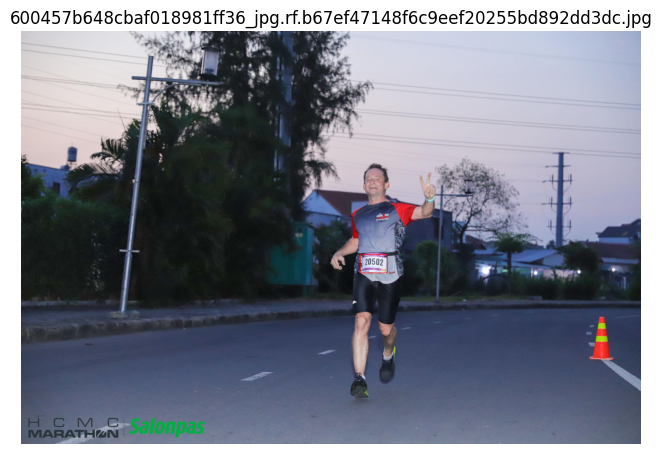

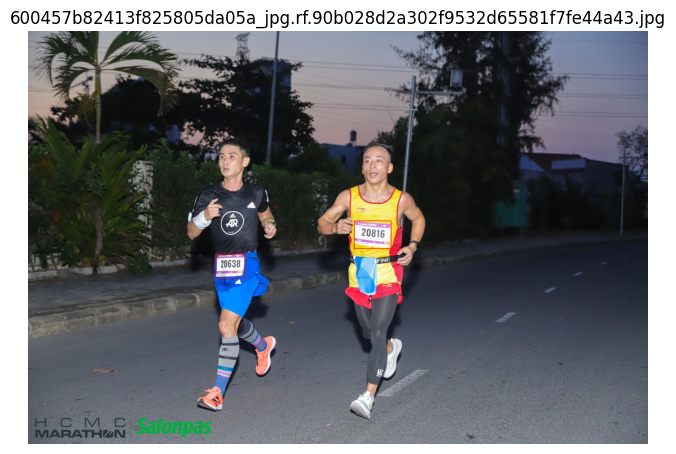

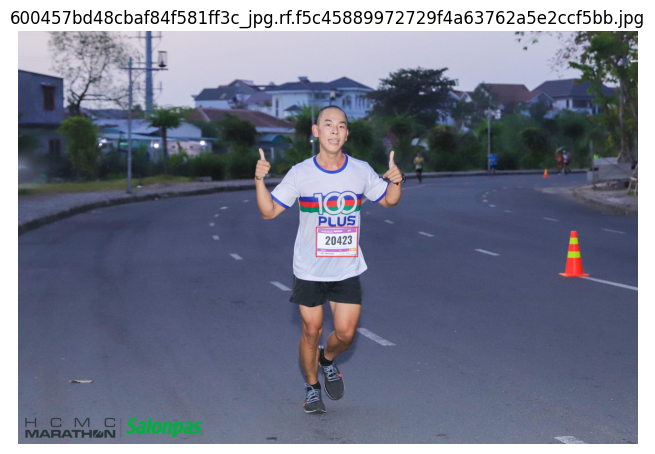

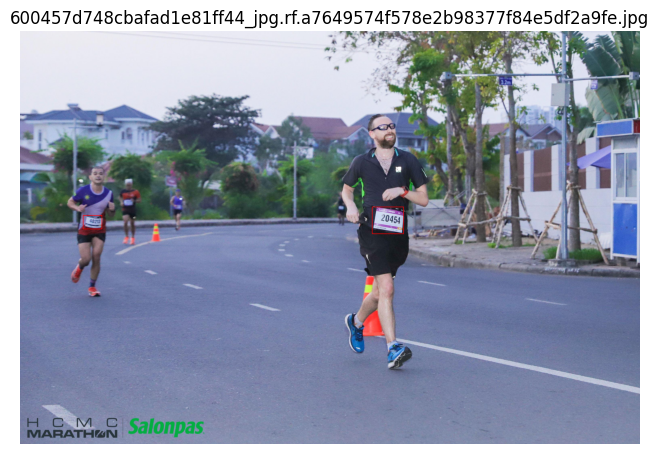

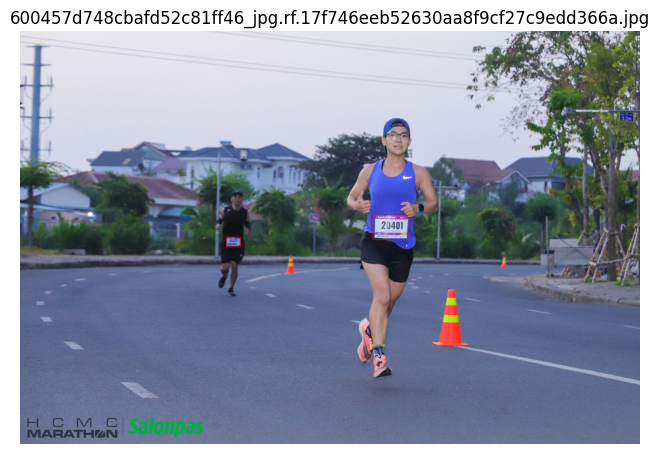

In [28]:
import cv2
import matplotlib.pyplot as plt
import os

# Paths to images and labels
img_dir = dataset.location + "/train/images"
label_dir = dataset.location + "/train/labels"

# Function to plot image + YOLOv8 bbox
def plot_yolo_image(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Read annotations
    with open(label_path, 'r') as f:
        for line in f:
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    plt.show()

# Show a few samples
image_files = sorted(os.listdir(img_dir))[:5]

for fname in image_files:
    if fname.endswith('.jpg') or fname.endswith('.png'):
        img_path = os.path.join(img_dir, fname)
        label_path = os.path.join(label_dir, fname.replace('.jpg', '.txt').replace('.png', '.txt'))
        plot_yolo_image(img_path, label_path)


In [31]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.0 MB/s eta 0:00:00


In [32]:
import os
import cv2
import torch
from ultralytics import YOLO
import easyocr
from pathlib import Path
from tqdm import tqdm
import json

# === Paths ===
input_image_dir = "./bib-detection-big-data-3/train/images"
synthetic_dataset_dir = "./synthetic_dataset"
os.makedirs(synthetic_dataset_dir, exist_ok=True)
os.makedirs(os.path.join(synthetic_dataset_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(synthetic_dataset_dir, 'labels'), exist_ok=True)

# === Load Models ===
human_model = YOLO("/content/human_detector_yolov8.pt")  # replace with your human detection weights
easyocr_reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

# === Process Images ===
for img_file in tqdm(sorted(Path(input_image_dir).glob("*.jpg"))):
    image = cv2.imread(str(img_file))
    h, w = image.shape[:2]

    # Save original image into synthetic_dataset/images
    target_img_path = os.path.join(synthetic_dataset_dir, 'images', img_file.name)
    cv2.imwrite(target_img_path, image)

    # Run YOLOv8 Human Detection
    results = human_model(image)[0]
    boxes = results.boxes.data.cpu().numpy()  # xyxy + conf + cls

    # Only take class 0 (person)
    person_boxes = [b[:4].astype(int) for b in boxes if int(b[5]) == 0]

    label_data = []

    for box in person_boxes:
        x1, y1, x2, y2 = box
        crop = image[y1:y2, x1:x2]

        # Run EasyOCR on human crop
        detections = easyocr_reader.readtext(crop)

        for bbox, text, conf in detections:
            if len(bbox) != 4:
                continue
            # Map OCR box to original image coords
            bbox_abs = [(int(pt[0] + x1), int(pt[1] + y1)) for pt in bbox]
            label_data.append({"bbox": bbox_abs})

    # Save labels to JSON
    if label_data:
        with open(os.path.join(synthetic_dataset_dir, 'labels', f"{img_file.stem}.json"), 'w') as f:
            json.dump(label_data, f, indent=2)

print(" Finished creating synthetic_dataset with original images and OCR-only labels.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

  0%|          | 0/440 [00:00<?, ?it/s]


0: 448x640 1 person, 63.0ms
Speed: 2.7ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


  0%|          | 1/440 [00:02<16:19,  2.23s/it]


0: 448x640 2 persons, 36.7ms
Speed: 2.5ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  0%|          | 2/440 [00:04<17:19,  2.37s/it]


0: 448x640 1 person, 36.2ms
Speed: 2.4ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  1%|          | 3/440 [00:06<15:45,  2.16s/it]


0: 448x640 2 persons, 35.8ms
Speed: 2.6ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  1%|          | 4/440 [00:07<13:17,  1.83s/it]


0: 448x640 2 persons, 35.8ms
Speed: 2.6ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  1%|          | 5/440 [00:09<11:52,  1.64s/it]


0: 448x640 3 persons, 36.9ms
Speed: 2.5ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  1%|▏         | 6/440 [00:11<12:12,  1.69s/it]


0: 480x640 2 persons, 58.4ms
Speed: 3.2ms preprocess, 58.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 7/440 [00:12<11:25,  1.58s/it]


0: 448x640 1 person, 35.7ms
Speed: 2.7ms preprocess, 35.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  2%|▏         | 8/440 [00:13<10:20,  1.44s/it]


0: 448x640 1 person, 35.9ms
Speed: 2.9ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  2%|▏         | 9/440 [00:15<10:32,  1.47s/it]


0: 448x640 1 person, 35.2ms
Speed: 2.6ms preprocess, 35.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|▏         | 10/440 [00:15<09:03,  1.26s/it]


0: 448x640 1 person, 39.7ms
Speed: 2.6ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  2%|▎         | 11/440 [00:17<09:57,  1.39s/it]


0: 448x640 1 person, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  3%|▎         | 12/440 [00:18<09:17,  1.30s/it]


0: 448x640 3 persons, 35.1ms
Speed: 2.7ms preprocess, 35.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  3%|▎         | 13/440 [00:21<12:07,  1.70s/it]


0: 448x640 4 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|▎         | 14/440 [00:23<12:31,  1.76s/it]


0: 448x640 3 persons, 33.8ms
Speed: 2.7ms preprocess, 33.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|▎         | 15/440 [00:24<10:50,  1.53s/it]


0: 448x640 1 person, 35.8ms
Speed: 3.1ms preprocess, 35.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  4%|▎         | 16/440 [00:24<08:01,  1.14s/it]


0: 448x640 6 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  4%|▍         | 17/440 [00:28<14:12,  2.02s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.2ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  4%|▍         | 18/440 [00:31<16:04,  2.29s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  4%|▍         | 19/440 [00:35<20:28,  2.92s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  5%|▍         | 20/440 [00:37<17:51,  2.55s/it]


0: 448x640 4 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  5%|▍         | 21/440 [00:41<20:14,  2.90s/it]


0: 448x640 4 persons, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  5%|▌         | 22/440 [00:42<17:42,  2.54s/it]


0: 448x640 (no detections), 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  5%|▌         | 24/440 [00:46<14:49,  2.14s/it]


0: 448x640 2 persons, 36.1ms
Speed: 2.8ms preprocess, 36.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  6%|▌         | 25/440 [00:49<17:16,  2.50s/it]


0: 448x640 1 person, 40.4ms
Speed: 3.3ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  6%|▌         | 26/440 [00:51<15:13,  2.21s/it]


0: 448x640 4 persons, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  6%|▌         | 27/440 [00:54<18:09,  2.64s/it]


0: 448x640 5 persons, 39.8ms
Speed: 3.3ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  6%|▋         | 28/440 [00:57<17:53,  2.61s/it]


0: 448x640 7 persons, 36.0ms
Speed: 2.9ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  7%|▋         | 29/440 [01:01<19:40,  2.87s/it]


0: 448x640 5 persons, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  7%|▋         | 30/440 [01:04<20:09,  2.95s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|▋         | 31/440 [01:06<19:43,  2.89s/it]


0: 448x640 7 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|▋         | 32/440 [01:11<22:56,  3.37s/it]


0: 448x640 7 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|▊         | 33/440 [01:17<28:37,  4.22s/it]


0: 448x640 4 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  8%|▊         | 34/440 [01:20<26:37,  3.94s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|▊         | 35/440 [01:23<23:55,  3.54s/it]


0: 448x640 7 persons, 39.7ms
Speed: 3.3ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  8%|▊         | 36/440 [01:26<22:53,  3.40s/it]


0: 448x640 4 persons, 41.3ms
Speed: 3.4ms preprocess, 41.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|▊         | 37/440 [01:32<28:19,  4.22s/it]


0: 448x640 (no detections), 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  9%|▉         | 39/440 [01:35<18:43,  2.80s/it]


0: 448x640 4 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  9%|▉         | 40/440 [01:37<18:31,  2.78s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  9%|▉         | 41/440 [01:40<19:15,  2.89s/it]


0: 448x640 2 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 10%|▉         | 42/440 [01:44<19:33,  2.95s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|▉         | 43/440 [01:49<24:50,  3.75s/it]


0: 448x640 (no detections), 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|█         | 45/440 [01:54<19:50,  3.01s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 10%|█         | 46/440 [01:56<18:46,  2.86s/it]


0: 448x640 1 person, 39.6ms
Speed: 3.0ms preprocess, 39.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 11%|█         | 47/440 [01:57<15:09,  2.31s/it]


0: 448x640 (no detections), 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 11%|█         | 49/440 [01:57<08:58,  1.38s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 11%|█▏        | 50/440 [01:57<07:32,  1.16s/it]


0: 448x640 1 person, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 12%|█▏        | 51/440 [01:59<07:34,  1.17s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 12%|█▏        | 52/440 [02:01<09:22,  1.45s/it]


0: 448x640 1 person, 41.1ms
Speed: 3.0ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█▏        | 53/440 [02:01<07:38,  1.18s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█▏        | 54/440 [02:02<06:23,  1.01it/s]


0: 448x640 5 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 12%|█▎        | 55/440 [02:04<08:10,  1.27s/it]


0: 448x640 1 person, 39.8ms
Speed: 3.3ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 13%|█▎        | 56/440 [02:05<07:17,  1.14s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 13%|█▎        | 57/440 [02:07<10:27,  1.64s/it]


0: 448x640 2 persons, 41.8ms
Speed: 3.2ms preprocess, 41.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 13%|█▎        | 58/440 [02:09<09:49,  1.54s/it]


0: 448x640 1 person, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 13%|█▎        | 59/440 [02:10<09:29,  1.49s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|█▎        | 60/440 [02:12<09:47,  1.55s/it]


0: 448x640 1 person, 41.9ms
Speed: 3.1ms preprocess, 41.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|█▍        | 61/440 [02:13<09:53,  1.57s/it]


0: 448x640 3 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|█▍        | 62/440 [02:16<12:01,  1.91s/it]


0: 448x640 2 persons, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|█▍        | 63/440 [02:18<12:13,  1.95s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 15%|█▍        | 64/440 [02:20<11:29,  1.83s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 15%|█▍        | 65/440 [02:21<10:50,  1.74s/it]


0: 448x640 (no detections), 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 15%|█▌        | 66/440 [02:21<07:45,  1.25s/it]


0: 448x640 3 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|█▌        | 67/440 [02:25<12:46,  2.05s/it]


0: 448x640 5 persons, 40.5ms
Speed: 2.9ms preprocess, 40.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 15%|█▌        | 68/440 [02:30<18:39,  3.01s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▌        | 69/440 [02:31<13:46,  2.23s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▌        | 70/440 [02:31<10:24,  1.69s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▌        | 71/440 [02:32<09:02,  1.47s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▋        | 72/440 [02:33<07:36,  1.24s/it]


0: 448x640 1 person, 39.6ms
Speed: 3.4ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█▋        | 73/440 [02:34<07:01,  1.15s/it]


0: 448x640 (no detections), 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 17%|█▋        | 74/440 [02:34<05:05,  1.20it/s]


0: 448x640 (no detections), 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 17%|█▋        | 75/440 [02:34<03:44,  1.63it/s]


0: 448x640 1 person, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█▋        | 76/440 [02:36<05:17,  1.15it/s]


0: 448x640 (no detections), 40.8ms
Speed: 3.4ms preprocess, 40.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 18%|█▊        | 77/440 [02:36<03:53,  1.56it/s]


0: 448x640 (no detections), 40.6ms
Speed: 3.2ms preprocess, 40.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 18%|█▊        | 78/440 [02:36<02:54,  2.08it/s]


0: 448x640 (no detections), 39.7ms
Speed: 3.4ms preprocess, 39.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 18%|█▊        | 79/440 [02:36<02:13,  2.71it/s]


0: 448x640 (no detections), 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 18%|█▊        | 80/440 [02:36<01:44,  3.46it/s]


0: 448x640 (no detections), 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 18%|█▊        | 81/440 [02:36<01:23,  4.28it/s]


0: 448x640 (no detections), 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 19%|█▉        | 83/440 [02:36<01:01,  5.81it/s]


0: 448x640 1 person, 40.6ms
Speed: 3.1ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|█▉        | 84/440 [02:37<01:10,  5.04it/s]


0: 448x640 (no detections), 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 19%|█▉        | 85/440 [02:37<01:01,  5.77it/s]


0: 448x640 (no detections), 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 20%|█▉        | 86/440 [02:37<00:54,  6.50it/s]


0: 448x640 1 person, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|█▉        | 87/440 [02:37<01:42,  3.43it/s]


0: 448x640 2 persons, 40.7ms
Speed: 3.2ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|██        | 88/440 [02:41<07:17,  1.24s/it]


0: 448x640 3 persons, 39.4ms
Speed: 3.3ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|██        | 89/440 [02:43<08:59,  1.54s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 20%|██        | 90/440 [02:45<08:39,  1.49s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|██        | 91/440 [02:46<08:07,  1.40s/it]


0: 448x640 5 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 21%|██        | 92/440 [02:48<09:47,  1.69s/it]


0: 448x640 5 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 21%|██        | 93/440 [02:50<09:20,  1.62s/it]


0: 448x640 4 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 21%|██▏       | 94/440 [02:56<17:42,  3.07s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|██▏       | 95/440 [02:59<16:38,  2.89s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 22%|██▏       | 96/440 [03:03<18:46,  3.27s/it]


0: 448x640 4 persons, 40.2ms
Speed: 2.9ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|██▏       | 97/440 [03:04<15:49,  2.77s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 22%|██▏       | 98/440 [03:06<13:10,  2.31s/it]


0: 448x640 2 persons, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 22%|██▎       | 99/440 [03:07<11:44,  2.07s/it]


0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|██▎       | 100/440 [03:11<14:29,  2.56s/it]


0: 448x640 1 person, 41.1ms
Speed: 3.2ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|██▎       | 101/440 [03:13<13:47,  2.44s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 23%|██▎       | 102/440 [03:14<10:40,  1.90s/it]


0: 448x640 (no detections), 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▎       | 104/440 [03:15<07:41,  1.37s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▍       | 105/440 [03:19<10:27,  1.87s/it]


0: 448x640 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▍       | 106/440 [03:21<11:37,  2.09s/it]


0: 448x640 3 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▍       | 107/440 [03:28<18:04,  3.26s/it]


0: 448x640 4 persons, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 25%|██▍       | 108/440 [03:36<26:22,  4.77s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 25%|██▍       | 109/440 [03:41<25:30,  4.63s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|██▌       | 110/440 [03:45<25:16,  4.60s/it]


0: 448x640 2 persons, 40.2ms
Speed: 2.8ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 25%|██▌       | 111/440 [03:50<26:27,  4.83s/it]


0: 448x640 1 person, 40.7ms
Speed: 2.9ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|██▌       | 112/440 [03:54<23:33,  4.31s/it]


0: 448x640 (no detections), 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▌       | 114/440 [03:57<17:09,  3.16s/it]


0: 448x640 (no detections), 40.8ms
Speed: 3.0ms preprocess, 40.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▌       | 115/440 [03:57<13:02,  2.41s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▋       | 116/440 [04:00<13:51,  2.57s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.0ms preprocess, 39.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 27%|██▋       | 117/440 [04:03<13:38,  2.53s/it]


0: 448x640 3 persons, 39.6ms
Speed: 3.1ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|██▋       | 118/440 [04:08<17:03,  3.18s/it]


0: 448x640 3 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|██▋       | 119/440 [04:12<19:16,  3.60s/it]


0: 448x640 3 persons, 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|██▋       | 120/440 [04:16<19:26,  3.65s/it]


0: 448x640 3 persons, 40.8ms
Speed: 3.0ms preprocess, 40.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|██▊       | 121/440 [04:19<18:55,  3.56s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|██▊       | 122/440 [04:20<14:56,  2.82s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 28%|██▊       | 123/440 [04:21<11:41,  2.21s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 28%|██▊       | 124/440 [04:22<09:53,  1.88s/it]


0: 448x640 2 persons, 40.0ms
Speed: 3.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|██▊       | 125/440 [04:25<10:36,  2.02s/it]


0: 448x640 4 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 29%|██▊       | 126/440 [04:29<13:45,  2.63s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 29%|██▉       | 127/440 [04:30<11:32,  2.21s/it]


0: 448x640 5 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 29%|██▉       | 128/440 [04:36<17:40,  3.40s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 29%|██▉       | 129/440 [04:37<13:30,  2.61s/it]


0: 448x640 1 person, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 30%|██▉       | 130/440 [04:38<11:47,  2.28s/it]


0: 448x640 4 persons, 41.2ms
Speed: 2.9ms preprocess, 41.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 30%|██▉       | 131/440 [04:42<14:13,  2.76s/it]


0: 448x640 1 person, 42.7ms
Speed: 3.0ms preprocess, 42.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 30%|███       | 132/440 [04:44<12:43,  2.48s/it]


0: 448x640 4 persons, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 30%|███       | 133/440 [04:47<13:58,  2.73s/it]


0: 448x640 4 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███       | 134/440 [04:50<14:26,  2.83s/it]


0: 448x640 3 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 31%|███       | 135/440 [04:56<18:45,  3.69s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 31%|███       | 136/440 [04:59<17:52,  3.53s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|███       | 137/440 [05:05<20:37,  4.08s/it]


0: 448x640 3 persons, 39.4ms
Speed: 2.7ms preprocess, 39.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 31%|███▏      | 138/440 [05:09<21:05,  4.19s/it]


0: 448x640 3 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 32%|███▏      | 139/440 [05:14<22:11,  4.42s/it]


0: 448x640 1 person, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 32%|███▏      | 140/440 [05:16<18:04,  3.62s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|███▏      | 141/440 [05:20<18:14,  3.66s/it]


0: 448x640 5 persons, 42.0ms
Speed: 3.6ms preprocess, 42.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 32%|███▏      | 142/440 [05:32<30:54,  6.22s/it]


0: 448x640 3 persons, 42.4ms
Speed: 3.8ms preprocess, 42.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|███▎      | 143/440 [05:39<32:04,  6.48s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.6ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 33%|███▎      | 144/440 [05:44<30:15,  6.13s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 33%|███▎      | 145/440 [05:53<34:13,  6.96s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|███▎      | 146/440 [05:57<30:14,  6.17s/it]


0: 448x640 4 persons, 42.2ms
Speed: 3.6ms preprocess, 42.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|███▎      | 147/440 [06:05<32:47,  6.71s/it]


0: 448x640 1 person, 43.5ms
Speed: 3.8ms preprocess, 43.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 34%|███▎      | 148/440 [06:11<30:48,  6.33s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 34%|███▍      | 149/440 [06:22<38:06,  7.86s/it]


0: 448x640 1 person, 40.9ms
Speed: 3.5ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 34%|███▍      | 150/440 [06:27<32:59,  6.83s/it]


0: 448x640 1 person, 40.8ms
Speed: 3.8ms preprocess, 40.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 34%|███▍      | 151/440 [06:32<30:49,  6.40s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.7ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███▍      | 152/440 [06:42<35:28,  7.39s/it]


0: 448x640 2 persons, 38.0ms
Speed: 3.6ms preprocess, 38.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 35%|███▍      | 153/440 [06:43<26:56,  5.63s/it]


0: 448x640 4 persons, 37.0ms
Speed: 3.6ms preprocess, 37.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 35%|███▌      | 154/440 [06:57<39:04,  8.20s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.6ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███▌      | 155/440 [07:07<41:27,  8.73s/it]


0: 448x640 2 persons, 41.7ms
Speed: 3.7ms preprocess, 41.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███▌      | 156/440 [07:12<34:54,  7.37s/it]


0: 448x640 2 persons, 39.8ms
Speed: 3.8ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▌      | 157/440 [07:22<39:06,  8.29s/it]


0: 448x640 1 person, 39.3ms
Speed: 3.5ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▌      | 158/440 [07:30<38:16,  8.15s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.7ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▌      | 159/440 [07:36<35:04,  7.49s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 36%|███▋      | 160/440 [07:40<30:13,  6.48s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 37%|███▋      | 161/440 [07:44<27:27,  5.91s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.7ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 37%|███▋      | 162/440 [07:51<28:02,  6.05s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.6ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 37%|███▋      | 163/440 [07:58<29:45,  6.44s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 37%|███▋      | 164/440 [08:04<28:55,  6.29s/it]


0: 448x640 3 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 38%|███▊      | 165/440 [08:14<33:37,  7.34s/it]


0: 448x640 2 persons, 39.8ms
Speed: 3.3ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 38%|███▊      | 166/440 [08:18<28:46,  6.30s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.3ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 38%|███▊      | 167/440 [08:27<33:12,  7.30s/it]


0: 448x640 4 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 38%|███▊      | 168/440 [08:41<41:25,  9.14s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 38%|███▊      | 169/440 [08:47<37:10,  8.23s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.7ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 39%|███▊      | 170/440 [08:57<38:57,  8.66s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|███▉      | 171/440 [09:01<33:37,  7.50s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|███▉      | 172/440 [09:12<37:02,  8.29s/it]


0: 448x640 6 persons, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 39%|███▉      | 173/440 [09:27<46:06, 10.36s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 40%|███▉      | 174/440 [09:35<43:20,  9.78s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 40%|███▉      | 175/440 [09:51<51:00, 11.55s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|████      | 176/440 [10:07<57:20, 13.03s/it]


0: 448x640 8 persons, 38.5ms
Speed: 3.4ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|████      | 177/440 [10:19<55:33, 12.67s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.6ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 40%|████      | 178/440 [10:37<1:01:42, 14.13s/it]


0: 448x640 4 persons, 41.6ms
Speed: 2.9ms preprocess, 41.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 41%|████      | 179/440 [10:41<48:00, 11.04s/it]  


0: 448x640 5 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 41%|████      | 180/440 [10:45<39:37,  9.15s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 41%|████      | 181/440 [10:49<32:33,  7.54s/it]


0: 448x640 5 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 41%|████▏     | 182/440 [10:55<30:48,  7.16s/it]


0: 448x640 4 persons, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 42%|████▏     | 183/440 [10:59<25:45,  6.01s/it]


0: 448x640 4 persons, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████▏     | 184/440 [11:02<22:44,  5.33s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 42%|████▏     | 185/440 [11:04<18:02,  4.24s/it]


0: 448x640 1 person, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████▏     | 186/440 [11:05<13:24,  3.17s/it]


0: 448x640 1 person, 39.6ms
Speed: 3.0ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████▎     | 187/440 [11:06<11:23,  2.70s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 43%|████▎     | 188/440 [11:10<12:25,  2.96s/it]


0: 448x640 4 persons, 40.4ms
Speed: 3.1ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|████▎     | 189/440 [11:14<13:28,  3.22s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|████▎     | 190/440 [11:15<11:10,  2.68s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 43%|████▎     | 191/440 [11:17<09:58,  2.40s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|████▎     | 192/440 [11:19<09:11,  2.22s/it]


0: 448x640 2 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|████▍     | 193/440 [11:20<07:25,  1.80s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 44%|████▍     | 194/440 [11:22<07:32,  1.84s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|████▍     | 195/440 [11:25<09:04,  2.22s/it]


0: 448x640 3 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▍     | 196/440 [11:28<10:52,  2.67s/it]


0: 448x640 2 persons, 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▍     | 197/440 [11:29<08:15,  2.04s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▌     | 198/440 [11:29<06:23,  1.58s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.5ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▌     | 199/440 [11:42<19:13,  4.78s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.8ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|████▌     | 200/440 [11:46<18:17,  4.57s/it]


0: 640x448 3 persons, 67.5ms
Speed: 3.4ms preprocess, 67.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 46%|████▌     | 201/440 [11:58<27:16,  6.85s/it]


0: 448x640 3 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 46%|████▌     | 202/440 [12:12<35:47,  9.02s/it]


0: 448x640 2 persons, 39.8ms
Speed: 3.3ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 46%|████▌     | 203/440 [12:20<34:27,  8.73s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|████▋     | 204/440 [12:31<37:03,  9.42s/it]


0: 448x640 (no detections), 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 47%|████▋     | 205/440 [12:31<26:03,  6.65s/it]


0: 448x640 (no detections), 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 47%|████▋     | 206/440 [12:31<18:23,  4.71s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████▋     | 207/440 [12:36<17:41,  4.56s/it]


0: 448x640 1 person, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 47%|████▋     | 208/440 [12:41<18:47,  4.86s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 209/440 [12:53<27:02,  7.02s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.3ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 210/440 [13:07<34:09,  8.91s/it]


0: 448x640 3 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 211/440 [13:16<34:55,  9.15s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 212/440 [13:25<33:43,  8.88s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.8ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 48%|████▊     | 213/440 [13:31<30:43,  8.12s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|████▊     | 214/440 [13:37<28:35,  7.59s/it]


0: 448x640 2 persons, 40.6ms
Speed: 3.3ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|████▉     | 215/440 [13:44<27:21,  7.30s/it]


0: 448x640 (no detections), 40.2ms
Speed: 3.5ms preprocess, 40.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 49%|████▉     | 216/440 [13:44<19:15,  5.16s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 49%|████▉     | 217/440 [13:46<16:04,  4.33s/it]


0: 448x640 (no detections), 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 50%|████▉     | 218/440 [13:47<11:23,  3.08s/it]


0: 448x640 (no detections), 36.3ms
Speed: 3.2ms preprocess, 36.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 50%|████▉     | 219/440 [13:47<08:06,  2.20s/it]


0: 448x640 (no detections), 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 50%|█████     | 220/440 [13:47<05:50,  1.59s/it]


0: 448x640 (no detections), 41.2ms
Speed: 3.2ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 50%|█████     | 221/440 [13:47<04:15,  1.17s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 50%|█████     | 222/440 [13:49<04:43,  1.30s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|█████     | 223/440 [13:53<08:11,  2.26s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 51%|█████     | 224/440 [13:57<10:09,  2.82s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|█████     | 225/440 [14:04<13:58,  3.90s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.2ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 51%|█████▏    | 226/440 [14:08<14:29,  4.06s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▏    | 227/440 [14:14<16:43,  4.71s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▏    | 228/440 [14:27<25:06,  7.10s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▏    | 229/440 [14:41<31:52,  9.06s/it]


0: 448x640 3 persons, 40.2ms
Speed: 3.4ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▏    | 230/440 [14:54<36:15, 10.36s/it]


0: 448x640 (no detections), 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 52%|█████▎    | 231/440 [14:54<25:27,  7.31s/it]


0: 448x640 (no detections), 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████▎    | 232/440 [14:55<17:56,  5.18s/it]


0: 448x640 5 persons, 36.0ms
Speed: 3.3ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████▎    | 233/440 [15:08<26:55,  7.80s/it]


0: 448x640 4 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████▎    | 234/440 [15:21<32:03,  9.34s/it]


0: 448x640 3 persons, 40.2ms
Speed: 3.7ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████▎    | 235/440 [15:37<38:10, 11.18s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████▎    | 236/440 [15:42<32:07,  9.45s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████▍    | 237/440 [15:51<30:47,  9.10s/it]


0: 448x640 2 persons, 39.8ms
Speed: 3.6ms preprocess, 39.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████▍    | 238/440 [16:00<30:45,  9.14s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████▍    | 239/440 [16:09<30:42,  9.17s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▍    | 240/440 [16:14<26:41,  8.01s/it]


0: 448x640 3 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▍    | 241/440 [16:29<33:03,  9.97s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.2ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▌    | 242/440 [16:34<27:52,  8.45s/it]


0: 448x640 3 persons, 41.2ms
Speed: 3.3ms preprocess, 41.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▌    | 243/440 [16:40<25:40,  7.82s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|█████▌    | 244/440 [16:44<21:31,  6.59s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 56%|█████▌    | 245/440 [16:51<21:44,  6.69s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 56%|█████▌    | 246/440 [16:58<21:58,  6.80s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|█████▌    | 247/440 [17:08<25:05,  7.80s/it]


0: 448x640 3 persons, 40.4ms
Speed: 3.4ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 56%|█████▋    | 248/440 [17:22<30:56,  9.67s/it]


0: 448x640 (no detections), 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 57%|█████▋    | 249/440 [17:22<21:42,  6.82s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|█████▋    | 250/440 [17:28<20:20,  6.42s/it]


0: 448x640 5 persons, 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 57%|█████▋    | 251/440 [17:39<25:18,  8.03s/it]


0: 448x640 3 persons, 39.2ms
Speed: 3.7ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|█████▋    | 252/440 [17:51<28:02,  8.95s/it]


0: 448x640 (no detections), 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 57%|█████▊    | 253/440 [17:51<19:41,  6.32s/it]


0: 448x640 (no detections), 39.4ms
Speed: 3.3ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████▊    | 254/440 [17:51<13:53,  4.48s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████▊    | 255/440 [17:57<15:07,  4.91s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████▊    | 256/440 [18:02<15:10,  4.95s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████▊    | 257/440 [18:08<16:24,  5.38s/it]


0: 448x640 (no detections), 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████▊    | 258/440 [18:08<11:34,  3.81s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████▉    | 259/440 [18:13<12:16,  4.07s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████▉    | 260/440 [18:17<12:18,  4.10s/it]


0: 448x640 (no detections), 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████▉    | 261/440 [18:17<08:42,  2.92s/it]


0: 448x640 (no detections), 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 60%|█████▉    | 262/440 [18:18<06:12,  2.09s/it]


0: 448x640 (no detections), 37.4ms
Speed: 3.2ms preprocess, 37.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 60%|█████▉    | 263/440 [18:18<04:27,  1.51s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.6ms preprocess, 37.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████    | 264/440 [18:21<06:17,  2.14s/it]


0: 448x640 4 persons, 39.0ms
Speed: 3.6ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████    | 265/440 [18:37<18:10,  6.23s/it]


0: 448x640 4 persons, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████    | 266/440 [18:50<23:39,  8.16s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 61%|██████    | 267/440 [18:57<22:56,  7.95s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.7ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|██████    | 268/440 [19:06<23:13,  8.10s/it]


0: 448x640 6 persons, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|██████    | 269/440 [19:19<27:49,  9.76s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.7ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|██████▏   | 270/440 [19:30<28:21, 10.01s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|██████▏   | 271/440 [19:43<30:26, 10.81s/it]


0: 448x640 2 persons, 37.0ms
Speed: 3.5ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 62%|██████▏   | 272/440 [19:50<27:14,  9.73s/it]


0: 448x640 2 persons, 36.6ms
Speed: 3.6ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 62%|██████▏   | 273/440 [20:00<27:12,  9.78s/it]


0: 448x640 (no detections), 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 62%|██████▏   | 274/440 [20:00<19:04,  6.89s/it]


0: 640x448 4 persons, 67.7ms
Speed: 3.4ms preprocess, 67.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 62%|██████▎   | 275/440 [20:06<18:31,  6.74s/it]


0: 640x448 1 person, 37.8ms
Speed: 3.7ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 63%|██████▎   | 276/440 [20:08<14:05,  5.16s/it]


0: 640x448 1 person, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 63%|██████▎   | 277/440 [20:09<11:06,  4.09s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 63%|██████▎   | 278/440 [20:14<11:41,  4.33s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.6ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|██████▎   | 279/440 [20:24<15:45,  5.87s/it]


0: 448x640 4 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████▎   | 280/440 [20:42<25:27,  9.55s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████▍   | 281/440 [20:56<28:37, 10.80s/it]


0: 448x640 (no detections), 41.4ms
Speed: 3.5ms preprocess, 41.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████▍   | 282/440 [20:56<20:06,  7.63s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████▍   | 283/440 [20:58<15:39,  5.98s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.6ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▍   | 284/440 [21:01<13:27,  5.18s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▍   | 285/440 [21:11<16:47,  6.50s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▌   | 286/440 [21:12<12:25,  4.84s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▌   | 287/440 [21:12<08:55,  3.50s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.6ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▌   | 288/440 [21:14<07:59,  3.15s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|██████▌   | 289/440 [21:16<06:58,  2.77s/it]


0: 448x640 1 person, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 66%|██████▌   | 290/440 [21:21<08:29,  3.40s/it]


0: 448x640 6 persons, 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 66%|██████▌   | 291/440 [21:35<16:11,  6.52s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 66%|██████▋   | 292/440 [21:37<12:41,  5.14s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|██████▋   | 293/440 [21:38<09:45,  3.98s/it]


0: 448x640 1 person, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 67%|██████▋   | 294/440 [21:41<08:45,  3.60s/it]


0: 448x640 4 persons, 42.2ms
Speed: 3.9ms preprocess, 42.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|██████▋   | 295/440 [21:49<11:54,  4.93s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|██████▋   | 296/440 [22:00<15:55,  6.64s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|██████▊   | 297/440 [22:08<16:52,  7.08s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.6ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 68%|██████▊   | 298/440 [22:15<17:03,  7.21s/it]


0: 640x448 3 persons, 63.0ms
Speed: 3.6ms preprocess, 63.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 68%|██████▊   | 299/440 [22:22<16:27,  7.01s/it]


0: 448x640 6 persons, 39.5ms
Speed: 3.5ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 68%|██████▊   | 300/440 [22:37<21:48,  9.35s/it]


0: 448x640 6 persons, 37.7ms
Speed: 3.6ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|██████▊   | 301/440 [22:52<25:58, 11.21s/it]


0: 448x640 4 persons, 41.3ms
Speed: 3.9ms preprocess, 41.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 69%|██████▊   | 302/440 [23:01<24:12, 10.52s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 69%|██████▉   | 303/440 [23:08<21:53,  9.58s/it]


0: 448x640 (no detections), 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 2.7ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 69%|██████▉   | 305/440 [23:11<13:00,  5.78s/it]


0: 448x640 2 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████▉   | 306/440 [23:13<10:50,  4.85s/it]


0: 448x640 4 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████▉   | 307/440 [23:16<09:40,  4.37s/it]


0: 448x640 3 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 70%|███████   | 308/440 [23:19<08:59,  4.08s/it]


0: 448x640 (no detections), 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.9ms
Speed: 2.8ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 70%|███████   | 310/440 [23:21<05:52,  2.71s/it]


0: 448x640 (no detections), 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████   | 312/440 [23:21<03:37,  1.70s/it]


0: 448x640 4 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████   | 313/440 [23:26<05:06,  2.41s/it]


0: 448x640 4 persons, 40.3ms
Speed: 3.1ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████▏  | 314/440 [23:28<04:44,  2.26s/it]


0: 448x640 4 persons, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 315/440 [23:32<05:29,  2.63s/it]


0: 448x640 (no detections), 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 317/440 [23:32<03:12,  1.57s/it]


0: 448x640 3 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▏  | 318/440 [23:33<02:57,  1.46s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████▎  | 319/440 [23:34<02:40,  1.33s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 73%|███████▎  | 320/440 [23:36<02:54,  1.45s/it]


0: 448x640 3 persons, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 73%|███████▎  | 321/440 [23:41<04:46,  2.41s/it]


0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 73%|███████▎  | 322/440 [23:43<04:44,  2.41s/it]


0: 448x640 2 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 73%|███████▎  | 323/440 [23:46<04:38,  2.38s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|███████▎  | 324/440 [23:46<03:28,  1.80s/it]


0: 448x640 3 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|███████▍  | 325/440 [23:47<03:00,  1.57s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 74%|███████▍  | 326/440 [23:48<02:50,  1.49s/it]


0: 448x640 4 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|███████▍  | 327/440 [23:50<03:06,  1.65s/it]


0: 448x640 4 persons, 35.5ms
Speed: 2.7ms preprocess, 35.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|███████▍  | 328/440 [23:53<03:29,  1.87s/it]


0: 448x640 4 persons, 37.3ms
Speed: 2.6ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|███████▍  | 329/440 [23:54<03:22,  1.82s/it]


0: 448x640 2 persons, 37.9ms
Speed: 2.6ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 75%|███████▌  | 330/440 [23:56<02:59,  1.63s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|███████▌  | 331/440 [23:58<03:15,  1.80s/it]


0: 448x640 2 persons, 38.8ms
Speed: 2.7ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 75%|███████▌  | 332/440 [23:59<03:00,  1.68s/it]


0: 448x640 2 persons, 38.4ms
Speed: 2.6ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████▌  | 333/440 [24:01<03:01,  1.70s/it]


0: 448x640 2 persons, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████▌  | 334/440 [24:03<03:06,  1.76s/it]


0: 448x640 3 persons, 36.6ms
Speed: 2.5ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████▌  | 335/440 [24:06<03:32,  2.03s/it]


0: 448x640 4 persons, 38.6ms
Speed: 2.5ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████▋  | 336/440 [24:08<03:43,  2.15s/it]


0: 448x640 4 persons, 37.2ms
Speed: 3.1ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████▋  | 337/440 [24:11<03:55,  2.29s/it]


0: 448x640 4 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████▋  | 338/440 [24:13<03:55,  2.31s/it]


0: 448x640 4 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████▋  | 339/440 [24:16<04:05,  2.43s/it]


0: 448x640 4 persons, 40.0ms
Speed: 3.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████▋  | 340/440 [24:19<04:19,  2.59s/it]


0: 448x640 4 persons, 36.1ms
Speed: 3.0ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 78%|███████▊  | 341/440 [24:22<04:35,  2.79s/it]


0: 448x640 3 persons, 36.2ms
Speed: 2.9ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 78%|███████▊  | 342/440 [24:25<04:42,  2.88s/it]


0: 448x640 2 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 78%|███████▊  | 343/440 [24:29<05:09,  3.19s/it]


0: 448x640 3 persons, 40.8ms
Speed: 2.7ms preprocess, 40.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|███████▊  | 344/440 [24:34<05:55,  3.71s/it]


0: 448x640 3 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|███████▊  | 345/440 [24:39<06:37,  4.19s/it]


0: 448x640 2 persons, 40.5ms
Speed: 3.1ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|███████▊  | 346/440 [24:42<06:09,  3.93s/it]


0: 448x640 3 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 79%|███████▉  | 347/440 [24:47<06:14,  4.02s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 79%|███████▉  | 348/440 [24:52<06:37,  4.32s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|███████▉  | 349/440 [24:56<06:45,  4.46s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|███████▉  | 350/440 [25:01<06:46,  4.52s/it]


0: 448x640 2 persons, 38.7ms
Speed: 2.7ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|███████▉  | 351/440 [25:04<06:02,  4.08s/it]


0: 448x640 2 persons, 40.6ms
Speed: 3.0ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|████████  | 352/440 [25:07<05:35,  3.81s/it]


0: 448x640 2 persons, 37.2ms
Speed: 2.6ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 80%|████████  | 353/440 [25:11<05:18,  3.66s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 80%|████████  | 354/440 [25:14<05:01,  3.51s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 81%|████████  | 355/440 [25:17<05:01,  3.54s/it]


0: 448x640 (no detections), 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.8ms
Speed: 3.1ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|████████  | 357/440 [25:23<04:22,  3.17s/it]


0: 448x640 3 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|████████▏ | 358/440 [25:26<04:25,  3.24s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████▏ | 359/440 [25:29<04:13,  3.13s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████▏ | 360/440 [25:32<03:55,  2.95s/it]


0: 448x640 1 person, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████▏ | 361/440 [25:33<03:24,  2.59s/it]


0: 448x640 5 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████▏ | 362/440 [25:37<03:56,  3.03s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████▎ | 363/440 [25:39<03:30,  2.73s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████▎ | 364/440 [25:49<05:53,  4.65s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████▎ | 365/440 [25:56<06:55,  5.54s/it]


0: 448x640 4 persons, 37.8ms
Speed: 3.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████▎ | 366/440 [26:09<09:26,  7.65s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.7ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████▎ | 367/440 [26:25<12:28, 10.25s/it]


0: 448x640 (no detections), 42.5ms
Speed: 3.2ms preprocess, 42.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 84%|████████▎ | 368/440 [26:26<08:40,  7.23s/it]


0: 448x640 3 persons, 43.0ms
Speed: 3.1ms preprocess, 43.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 84%|████████▍ | 369/440 [26:27<06:30,  5.50s/it]


0: 448x640 1 person, 40.0ms
Speed: 3.9ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|████████▍ | 370/440 [26:31<05:44,  4.92s/it]


0: 448x640 2 persons, 40.7ms
Speed: 3.4ms preprocess, 40.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 84%|████████▍ | 371/440 [26:32<04:26,  3.87s/it]


0: 448x640 2 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 85%|████████▍ | 372/440 [26:35<04:14,  3.74s/it]


0: 448x640 2 persons, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 85%|████████▍ | 373/440 [26:38<03:57,  3.54s/it]


0: 640x448 2 persons, 66.9ms
Speed: 3.3ms preprocess, 66.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 85%|████████▌ | 374/440 [26:41<03:29,  3.18s/it]


0: 448x640 1 person, 41.4ms
Speed: 3.7ms preprocess, 41.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 85%|████████▌ | 375/440 [26:44<03:24,  3.15s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.6ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 85%|████████▌ | 376/440 [26:48<03:46,  3.55s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 86%|████████▌ | 377/440 [26:50<03:08,  3.00s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 86%|████████▌ | 378/440 [26:52<02:43,  2.63s/it]


0: 448x640 4 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 86%|████████▌ | 379/440 [27:03<05:14,  5.16s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|████████▋ | 380/440 [27:04<03:50,  3.84s/it]


0: 448x640 3 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|████████▋ | 381/440 [27:07<03:29,  3.55s/it]


0: 640x448 2 persons, 63.9ms
Speed: 3.0ms preprocess, 63.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 87%|████████▋ | 382/440 [27:14<04:35,  4.74s/it]


0: 640x448 2 persons, 40.5ms
Speed: 3.2ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 87%|████████▋ | 383/440 [27:20<04:49,  5.09s/it]


0: 640x448 1 person, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 87%|████████▋ | 384/440 [27:24<04:27,  4.77s/it]


0: 448x640 3 persons, 36.9ms
Speed: 3.0ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████▊ | 385/440 [27:29<04:30,  4.92s/it]


0: 448x640 3 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████▊ | 386/440 [27:32<03:55,  4.35s/it]


0: 448x640 2 persons, 39.7ms
Speed: 3.8ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████▊ | 387/440 [27:40<04:50,  5.48s/it]


0: 448x640 1 person, 36.0ms
Speed: 3.0ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████▊ | 388/440 [27:41<03:27,  3.99s/it]


0: 448x640 3 persons, 37.0ms
Speed: 3.2ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████▊ | 389/440 [27:43<02:55,  3.44s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|████████▊ | 390/440 [27:48<03:20,  4.02s/it]


0: 448x640 2 persons, 41.1ms
Speed: 3.5ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|████████▉ | 391/440 [27:51<02:54,  3.55s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|████████▉ | 392/440 [27:57<03:21,  4.20s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 89%|████████▉ | 393/440 [27:59<02:45,  3.52s/it]


0: 448x640 1 person, 39.9ms
Speed: 3.7ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|████████▉ | 394/440 [28:03<03:00,  3.93s/it]


0: 448x640 1 person, 36.7ms
Speed: 3.7ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|████████▉ | 395/440 [28:06<02:43,  3.64s/it]


0: 448x640 2 persons, 39.7ms
Speed: 3.4ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 90%|█████████ | 396/440 [28:13<03:21,  4.59s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 90%|█████████ | 397/440 [28:22<04:11,  5.84s/it]


0: 640x448 2 persons, 63.2ms
Speed: 3.5ms preprocess, 63.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 90%|█████████ | 398/440 [28:26<03:45,  5.37s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 91%|█████████ | 399/440 [28:28<02:54,  4.24s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 91%|█████████ | 400/440 [28:29<02:11,  3.29s/it]


0: 448x640 3 persons, 39.5ms
Speed: 3.8ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|█████████ | 401/440 [28:34<02:31,  3.89s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 91%|█████████▏| 402/440 [28:38<02:28,  3.91s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.6ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|█████████▏| 403/440 [28:43<02:32,  4.11s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 92%|█████████▏| 404/440 [28:48<02:35,  4.32s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.6ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|█████████▏| 405/440 [28:56<03:12,  5.50s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|█████████▏| 406/440 [29:05<03:44,  6.60s/it]


0: 448x640 4 persons, 37.5ms
Speed: 3.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|█████████▎| 407/440 [29:20<05:01,  9.14s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.6ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 93%|█████████▎| 408/440 [29:24<04:04,  7.64s/it]


0: 448x640 2 persons, 41.5ms
Speed: 3.5ms preprocess, 41.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 93%|█████████▎| 409/440 [29:33<04:05,  7.92s/it]


0: 448x640 5 persons, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|█████████▎| 410/440 [29:37<03:26,  6.89s/it]


0: 448x640 5 persons, 39.4ms
Speed: 3.2ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|█████████▎| 411/440 [29:45<03:24,  7.04s/it]


0: 448x640 5 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████▎| 412/440 [29:53<03:28,  7.43s/it]


0: 448x640 5 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████▍| 413/440 [30:01<03:21,  7.45s/it]


0: 448x640 5 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████▍| 414/440 [30:08<03:14,  7.50s/it]


0: 448x640 5 persons, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████▍| 415/440 [30:16<03:12,  7.70s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▍| 416/440 [30:24<03:03,  7.64s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▍| 417/440 [30:27<02:25,  6.32s/it]


0: 448x640 (no detections), 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▌| 418/440 [30:27<01:38,  4.46s/it]


0: 448x640 3 persons, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▌| 419/440 [30:29<01:16,  3.64s/it]


0: 448x640 4 persons, 37.3ms
Speed: 3.1ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▌| 420/440 [30:33<01:18,  3.91s/it]


0: 448x640 5 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|█████████▌| 421/440 [30:36<01:08,  3.62s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|█████████▌| 422/440 [30:39<01:02,  3.45s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|█████████▌| 423/440 [30:43<00:57,  3.39s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|█████████▋| 424/440 [30:47<00:58,  3.67s/it]


0: 448x640 3 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 97%|█████████▋| 425/440 [30:53<01:06,  4.41s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.6ms preprocess, 39.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 97%|█████████▋| 426/440 [31:01<01:15,  5.36s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 97%|█████████▋| 427/440 [31:02<00:52,  4.07s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 97%|█████████▋| 428/440 [31:05<00:46,  3.85s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.6ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|█████████▊| 429/440 [31:06<00:33,  3.04s/it]


0: 448x640 3 persons, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 98%|█████████▊| 430/440 [31:11<00:35,  3.59s/it]


0: 448x640 5 persons, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|█████████▊| 431/440 [31:14<00:30,  3.33s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|█████████▊| 432/440 [31:17<00:25,  3.21s/it]


0: 448x640 2 persons, 36.4ms
Speed: 3.7ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 98%|█████████▊| 433/440 [31:19<00:19,  2.81s/it]


0: 448x640 4 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████▊| 434/440 [31:22<00:17,  2.84s/it]


0: 448x640 5 persons, 37.7ms
Speed: 3.8ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████▉| 435/440 [31:39<00:35,  7.07s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████▉| 436/440 [31:44<00:26,  6.58s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████▉| 437/440 [31:49<00:18,  6.09s/it]


0: 448x640 1 person, 36.2ms
Speed: 3.3ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████▉| 438/440 [31:50<00:09,  4.68s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████▉| 439/440 [31:54<00:04,  4.32s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


100%|██████████| 440/440 [31:58<00:00,  4.36s/it]

 Finished creating synthetic_dataset with original images and OCR-only labels.


In [33]:
# === Paths ===
label_dir = "./synthetic_dataset/labels"
image_dir = "./synthetic_dataset/images"
mask_dir = "./synthetic_dataset/masks_from_json"
os.makedirs(mask_dir, exist_ok=True)

# === Convert Each JSON to Mask ===
for json_path in tqdm(sorted(Path(label_dir).glob("*.json"))):
    stem = json_path.stem
    img_path = os.path.join(image_dir, f"{stem}.jpg")
    if not os.path.exists(img_path):
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(json_path, 'r') as f:
        labels = json.load(f)
        for obj in labels:
            if "bbox" in obj:
                polygon = np.array(obj["bbox"], dtype=np.int32)
                cv2.fillPoly(mask, [polygon], 255)

    cv2.imwrite(os.path.join(mask_dir, f"{stem}.png"), mask)

print(" All masks generated from JSON labels.")

100%|██████████| 372/372 [00:35<00:00, 10.48it/s]

 All masks generated from JSON labels.


In [43]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim


# === Paths ===
image_dir = "./synthetic_dataset/images"
mask_dir = "./synthetic_dataset/masks_from_json"
human_model = YOLO("/content/human_detector_yolov8.pt")

# === Training Config ===
batch_size = 2
epochs = 10
lr = 1e-4
img_size = 768

# === Dataset ===
class HumanFilteredCRAFTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=768):
        self.img_paths = sorted(Path(image_dir).glob("*.jpg"))
        self.mask_dir = Path(mask_dir)
        self.img_size = img_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_dir / (img_path.stem + ".png")

        image = cv2.imread(str(img_path))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if mask is None or image is None:
            return self.__getitem__((idx + 1) % len(self))  # skip to next sample

        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = mask / 255.0

        # run human detection and crop all humans
        results = human_model(image)[0]
        boxes = results.boxes.data.cpu().numpy()
        person_boxes = [b[:4].astype(int) for b in boxes if int(b[5]) == 0]

        combined = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
        combined_mask = np.zeros((self.img_size, self.img_size), dtype=np.uint8)

        for box in person_boxes:
            x1, y1, x2, y2 = box
            crop_img = image[y1:y2, x1:x2]
            crop_mask = mask[y1:y2, x1:x2]

            if crop_img.size == 0 or crop_mask.size == 0:
                continue

            try:
                crop_img = cv2.resize(crop_img, (self.img_size, self.img_size))
                crop_mask = cv2.resize(crop_mask, (self.img_size, self.img_size))
            except Exception as e:
                continue

            combined = crop_img
            combined_mask = crop_mask
            break  # take first person box for simplicity

        img_tensor = torch.tensor(combined, dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask_tensor = torch.tensor(combined_mask, dtype=torch.float32).unsqueeze(0)
        return img_tensor, mask_tensor

# === Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load("craft_svt_trained.pth", map_location=device))
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

dataset = HumanFilteredCRAFTDataset(image_dir, mask_dir, img_size=img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# === Training Loop ===
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

# === Save Fine-tuned Model ===
torch.save(model.state_dict(), "craft_synthetic_trained.pth")
print(" Model fine-tuned on synthetic_dataset with human-filtered inputs.")


Epoch 1/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 8 persons, 41.0ms
Speed: 3.5ms preprocess, 41.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 3.6ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   0%|          | 1/220 [00:13<48:04, 13.17s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   1%|          | 2/220 [00:25<46:45, 12.87s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   1%|▏         | 3/220 [00:38<46:18, 12.80s/it]


0: 448x640 5 persons, 39.8ms
Speed: 3.0ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.0ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   2%|▏         | 4/220 [00:50<45:29, 12.64s/it]


0: 448x640 1 person, 41.7ms
Speed: 3.7ms preprocess, 41.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   2%|▏         | 5/220 [01:03<45:10, 12.61s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   3%|▎         | 6/220 [01:15<44:48, 12.56s/it]


0: 448x640 1 person, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   3%|▎         | 7/220 [01:28<44:31, 12.54s/it]


0: 448x640 5 persons, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   4%|▎         | 8/220 [01:40<44:17, 12.53s/it]


0: 448x640 2 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   4%|▍         | 9/220 [01:53<44:01, 12.52s/it]


0: 448x640 1 person, 41.4ms
Speed: 3.2ms preprocess, 41.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 68.2ms
Speed: 3.3ms preprocess, 68.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Epoch 1/10:   5%|▍         | 10/220 [02:06<43:56, 12.56s/it]


0: 448x640 4 persons, 40.4ms
Speed: 3.6ms preprocess, 40.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   5%|▌         | 11/220 [02:18<43:49, 12.58s/it]


0: 448x640 3 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   5%|▌         | 12/220 [02:31<43:33, 12.57s/it]


0: 448x640 1 person, 40.2ms
Speed: 3.0ms preprocess, 40.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   6%|▌         | 13/220 [02:43<43:28, 12.60s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   6%|▋         | 14/220 [02:56<43:19, 12.62s/it]


0: 448x640 7 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   7%|▋         | 15/220 [03:09<43:02, 12.60s/it]


0: 448x640 1 person, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 3.6ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   7%|▋         | 16/220 [03:21<42:57, 12.63s/it]


0: 448x640 4 persons, 40.6ms
Speed: 3.1ms preprocess, 40.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.3ms
Speed: 3.3ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   8%|▊         | 17/220 [03:34<42:40, 12.61s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   8%|▊         | 18/220 [03:46<42:17, 12.56s/it]


0: 448x640 3 persons, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 3.6ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   9%|▊         | 19/220 [03:59<42:08, 12.58s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:   9%|▉         | 20/220 [04:11<41:49, 12.55s/it]


0: 448x640 3 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  10%|▉         | 21/220 [04:24<41:36, 12.54s/it]


0: 448x640 1 person, 40.0ms
Speed: 2.8ms preprocess, 40.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  10%|█         | 22/220 [04:36<41:15, 12.50s/it]


0: 448x640 2 persons, 40.7ms
Speed: 3.5ms preprocess, 40.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  10%|█         | 23/220 [04:49<41:10, 12.54s/it]


0: 448x640 1 person, 40.8ms
Speed: 3.3ms preprocess, 40.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  11%|█         | 24/220 [05:02<41:10, 12.61s/it]


0: 448x640 4 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  11%|█▏        | 25/220 [05:14<40:45, 12.54s/it]


0: 448x640 2 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  12%|█▏        | 26/220 [05:27<40:39, 12.57s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  12%|█▏        | 27/220 [05:39<40:25, 12.57s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  13%|█▎        | 28/220 [05:52<40:12, 12.57s/it]


0: 448x640 3 persons, 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  13%|█▎        | 29/220 [06:05<40:02, 12.58s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.2ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  14%|█▎        | 30/220 [06:17<39:43, 12.54s/it]


0: 448x640 4 persons, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  14%|█▍        | 31/220 [06:29<39:25, 12.51s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  15%|█▍        | 32/220 [06:42<39:12, 12.52s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.7ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  15%|█▌        | 33/220 [06:55<39:05, 12.54s/it]


0: 448x640 4 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  15%|█▌        | 34/220 [07:07<38:54, 12.55s/it]


0: 448x640 4 persons, 38.3ms
Speed: 3.7ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  16%|█▌        | 35/220 [07:20<38:59, 12.65s/it]


0: 448x640 3 persons, 39.2ms
Speed: 2.7ms preprocess, 39.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.4ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  16%|█▋        | 36/220 [07:33<38:40, 12.61s/it]


0: 448x640 1 person, 41.1ms
Speed: 3.3ms preprocess, 41.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  17%|█▋        | 37/220 [07:45<38:32, 12.64s/it]


0: 448x640 1 person, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.3ms
Speed: 3.5ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  17%|█▋        | 38/220 [07:58<38:14, 12.61s/it]


0: 448x640 1 person, 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  18%|█▊        | 39/220 [08:10<37:58, 12.59s/it]


0: 448x640 2 persons, 40.4ms
Speed: 2.9ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  18%|█▊        | 40/220 [08:23<37:55, 12.64s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.9ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  19%|█▊        | 41/220 [08:36<37:43, 12.64s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  19%|█▉        | 42/220 [08:48<37:22, 12.60s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  20%|█▉        | 43/220 [09:01<37:03, 12.56s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  20%|██        | 44/220 [09:13<36:51, 12.57s/it]


0: 448x640 4 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  20%|██        | 45/220 [09:26<36:34, 12.54s/it]


0: 448x640 4 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  21%|██        | 46/220 [09:38<36:25, 12.56s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  21%|██▏       | 47/220 [09:51<36:07, 12.53s/it]


0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  22%|██▏       | 48/220 [10:03<35:54, 12.53s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  22%|██▏       | 49/220 [10:16<35:38, 12.50s/it]


0: 448x640 3 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  23%|██▎       | 50/220 [10:28<35:24, 12.50s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  23%|██▎       | 51/220 [10:41<35:12, 12.50s/it]


0: 448x640 2 persons, 39.8ms
Speed: 2.8ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  24%|██▎       | 52/220 [10:53<35:04, 12.53s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  24%|██▍       | 53/220 [11:06<34:56, 12.56s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  25%|██▍       | 54/220 [11:19<34:42, 12.54s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.2ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  25%|██▌       | 55/220 [11:31<34:20, 12.49s/it]


0: 448x640 2 persons, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.4ms
Speed: 2.8ms preprocess, 41.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  25%|██▌       | 56/220 [11:43<34:09, 12.50s/it]


0: 448x640 4 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  26%|██▌       | 57/220 [11:56<33:59, 12.51s/it]


0: 448x640 3 persons, 39.6ms
Speed: 3.3ms preprocess, 39.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  26%|██▋       | 58/220 [12:09<33:47, 12.52s/it]


0: 448x640 5 persons, 39.4ms
Speed: 3.2ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 1/10:  27%|██▋       | 59/220 [12:21<33:40, 12.55s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  27%|██▋       | 60/220 [12:34<33:30, 12.57s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.3ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.1ms
Speed: 2.9ms preprocess, 36.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  28%|██▊       | 61/220 [12:46<33:18, 12.57s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  28%|██▊       | 62/220 [12:59<33:03, 12.56s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  29%|██▊       | 63/220 [13:11<32:54, 12.58s/it]


0: 448x640 3 persons, 41.1ms
Speed: 3.4ms preprocess, 41.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  29%|██▉       | 64/220 [13:24<32:38, 12.55s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  30%|██▉       | 65/220 [13:36<32:23, 12.54s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 40.7ms
Speed: 3.0ms preprocess, 40.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  30%|███       | 66/220 [13:49<32:15, 12.57s/it]


0: 448x640 4 persons, 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  30%|███       | 67/220 [14:02<31:58, 12.54s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 3.5ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  31%|███       | 68/220 [14:14<31:51, 12.58s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.2ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 3.7ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  31%|███▏      | 69/220 [14:27<31:40, 12.59s/it]


0: 448x640 1 person, 40.4ms
Speed: 4.0ms preprocess, 40.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 41.4ms
Speed: 3.1ms preprocess, 41.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  32%|███▏      | 70/220 [14:39<31:29, 12.60s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  32%|███▏      | 71/220 [14:52<31:19, 12.62s/it]


0: 448x640 2 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  33%|███▎      | 72/220 [15:05<30:58, 12.56s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  33%|███▎      | 73/220 [15:17<30:52, 12.60s/it]


0: 448x640 3 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 3.2ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  34%|███▎      | 74/220 [15:30<30:30, 12.54s/it]


0: 448x640 4 persons, 40.8ms
Speed: 3.7ms preprocess, 40.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  34%|███▍      | 75/220 [15:42<30:19, 12.55s/it]


0: 448x640 3 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 3.6ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  35%|███▍      | 76/220 [15:55<30:11, 12.58s/it]


0: 448x640 1 person, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  35%|███▌      | 77/220 [16:07<30:00, 12.59s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  35%|███▌      | 78/220 [16:20<29:45, 12.58s/it]


0: 448x640 4 persons, 40.3ms
Speed: 3.2ms preprocess, 40.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  36%|███▌      | 79/220 [16:33<29:33, 12.58s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  36%|███▋      | 80/220 [16:45<29:13, 12.52s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  37%|███▋      | 81/220 [16:58<29:07, 12.57s/it]


0: 448x640 4 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  37%|███▋      | 82/220 [17:10<28:46, 12.51s/it]


0: 448x640 5 persons, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  38%|███▊      | 83/220 [17:23<28:35, 12.52s/it]


0: 448x640 2 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  38%|███▊      | 84/220 [17:35<28:19, 12.50s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  39%|███▊      | 85/220 [17:48<28:13, 12.54s/it]


0: 448x640 2 persons, 35.7ms
Speed: 3.3ms preprocess, 35.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  39%|███▉      | 86/220 [18:00<27:58, 12.52s/it]


0: 448x640 6 persons, 40.3ms
Speed: 3.7ms preprocess, 40.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  40%|███▉      | 87/220 [18:13<27:44, 12.51s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.1ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 41.0ms
Speed: 3.7ms preprocess, 41.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  40%|████      | 88/220 [18:25<27:30, 12.50s/it]


0: 448x640 2 persons, 36.4ms
Speed: 3.1ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  40%|████      | 89/220 [18:38<27:13, 12.47s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 1/10:  41%|████      | 90/220 [18:50<27:04, 12.50s/it]


0: 448x640 2 persons, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  41%|████▏     | 91/220 [19:03<26:58, 12.54s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  42%|████▏     | 92/220 [19:15<26:44, 12.54s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  42%|████▏     | 93/220 [19:28<26:29, 12.52s/it]


0: 448x640 4 persons, 41.0ms
Speed: 2.9ms preprocess, 41.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  43%|████▎     | 94/220 [19:40<26:15, 12.51s/it]


0: 448x640 7 persons, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  43%|████▎     | 95/220 [19:53<26:04, 12.52s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  44%|████▎     | 96/220 [20:05<25:55, 12.55s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.7ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.0ms
Speed: 3.7ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  44%|████▍     | 97/220 [20:18<25:48, 12.59s/it]


0: 448x640 3 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.1ms
Speed: 3.3ms preprocess, 36.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  45%|████▍     | 98/220 [20:31<25:34, 12.58s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.6ms
Speed: 3.2ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  45%|████▌     | 99/220 [20:43<25:22, 12.58s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  45%|████▌     | 100/220 [20:56<25:09, 12.58s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  46%|████▌     | 101/220 [21:08<24:51, 12.54s/it]


0: 640x448 1 person, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 36.3ms
Speed: 3.1ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  46%|████▋     | 102/220 [21:21<24:37, 12.52s/it]


0: 640x448 2 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  47%|████▋     | 103/220 [21:33<24:24, 12.51s/it]


0: 448x640 1 person, 39.6ms
Speed: 3.2ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  47%|████▋     | 104/220 [21:46<24:10, 12.50s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  48%|████▊     | 105/220 [21:58<23:59, 12.52s/it]


0: 448x640 1 person, 40.8ms
Speed: 3.3ms preprocess, 40.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 43.4ms
Speed: 3.4ms preprocess, 43.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  48%|████▊     | 106/220 [22:11<23:41, 12.47s/it]


0: 448x640 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.1ms
Speed: 2.9ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  49%|████▊     | 107/220 [22:23<23:28, 12.47s/it]


0: 448x640 5 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 3.2ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  49%|████▉     | 108/220 [22:35<23:13, 12.44s/it]


0: 448x640 3 persons, 39.5ms
Speed: 3.7ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  50%|████▉     | 109/220 [22:48<23:03, 12.46s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.2ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  50%|█████     | 110/220 [23:01<23:02, 12.57s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  50%|█████     | 111/220 [23:13<22:47, 12.55s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  51%|█████     | 112/220 [23:26<22:37, 12.57s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  51%|█████▏    | 113/220 [23:38<22:20, 12.53s/it]


0: 448x640 4 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  52%|█████▏    | 114/220 [23:51<22:05, 12.51s/it]


0: 448x640 5 persons, 38.9ms
Speed: 3.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  52%|█████▏    | 115/220 [24:04<22:01, 12.58s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  53%|█████▎    | 116/220 [24:16<21:45, 12.55s/it]


0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  53%|█████▎    | 117/220 [24:29<21:35, 12.58s/it]


0: 448x640 2 persons, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  54%|█████▎    | 118/220 [24:41<21:21, 12.56s/it]


0: 640x448 2 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 40.2ms
Speed: 3.4ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  54%|█████▍    | 119/220 [24:54<21:06, 12.54s/it]


0: 448x640 2 persons, 36.3ms
Speed: 3.0ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  55%|█████▍    | 120/220 [25:06<20:52, 12.53s/it]


0: 448x640 4 persons, 41.1ms
Speed: 3.2ms preprocess, 41.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  55%|█████▌    | 121/220 [25:19<20:39, 12.52s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  55%|█████▌    | 122/220 [25:31<20:21, 12.46s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  56%|█████▌    | 123/220 [25:44<20:11, 12.49s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  56%|█████▋    | 124/220 [25:56<19:59, 12.50s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  57%|█████▋    | 125/220 [26:09<19:57, 12.60s/it]


0: 448x640 5 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  57%|█████▋    | 126/220 [26:22<19:45, 12.61s/it]


0: 448x640 3 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  58%|█████▊    | 127/220 [26:34<19:28, 12.57s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  58%|█████▊    | 128/220 [26:47<19:21, 12.63s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.1ms
Speed: 3.7ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  59%|█████▊    | 129/220 [26:59<19:07, 12.61s/it]


0: 448x640 3 persons, 40.3ms
Speed: 3.4ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  59%|█████▉    | 130/220 [27:12<18:54, 12.61s/it]


0: 448x640 3 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  60%|█████▉    | 131/220 [27:24<18:39, 12.58s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.6ms preprocess, 37.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  60%|██████    | 132/220 [27:37<18:27, 12.59s/it]


0: 448x640 2 persons, 41.8ms
Speed: 3.2ms preprocess, 41.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  60%|██████    | 133/220 [27:50<18:12, 12.56s/it]


0: 448x640 4 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  61%|██████    | 134/220 [28:02<17:58, 12.55s/it]


0: 448x640 3 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  61%|██████▏   | 135/220 [28:15<17:47, 12.55s/it]


0: 480x640 2 persons, 70.6ms
Speed: 3.1ms preprocess, 70.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  62%|██████▏   | 136/220 [28:27<17:31, 12.52s/it]


0: 448x640 4 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  62%|██████▏   | 137/220 [28:40<17:22, 12.55s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.2ms
Speed: 3.5ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  63%|██████▎   | 138/220 [28:52<17:10, 12.57s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.6ms preprocess, 38.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.1ms
Speed: 3.2ms preprocess, 37.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  63%|██████▎   | 139/220 [29:05<16:58, 12.57s/it]


0: 448x640 3 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  64%|██████▎   | 140/220 [29:17<16:46, 12.58s/it]


0: 448x640 4 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  64%|██████▍   | 141/220 [29:30<16:32, 12.56s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  65%|██████▍   | 142/220 [29:43<16:20, 12.57s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  65%|██████▌   | 143/220 [29:55<16:06, 12.55s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  65%|██████▌   | 144/220 [30:08<16:02, 12.67s/it]


0: 448x640 5 persons, 40.7ms
Speed: 3.2ms preprocess, 40.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  66%|██████▌   | 145/220 [30:21<15:47, 12.63s/it]


0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  66%|██████▋   | 146/220 [30:33<15:31, 12.59s/it]


0: 448x640 3 persons, 36.2ms
Speed: 3.3ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  67%|██████▋   | 147/220 [30:46<15:21, 12.62s/it]


0: 448x640 1 person, 39.4ms
Speed: 3.3ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 3.5ms preprocess, 36.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  67%|██████▋   | 148/220 [30:59<15:18, 12.76s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.2ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  68%|██████▊   | 149/220 [31:11<15:00, 12.68s/it]


0: 448x640 3 persons, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.1ms
Speed: 2.7ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  68%|██████▊   | 150/220 [31:24<14:46, 12.66s/it]


0: 448x640 1 person, 40.6ms
Speed: 2.9ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.4ms
Speed: 3.5ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  69%|██████▊   | 151/220 [31:37<14:33, 12.66s/it]


0: 448x640 1 person, 37.2ms
Speed: 3.5ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  69%|██████▉   | 152/220 [31:49<14:19, 12.64s/it]


0: 448x640 3 persons, 42.2ms
Speed: 3.8ms preprocess, 42.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.2ms
Speed: 3.4ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  70%|██████▉   | 153/220 [32:02<14:08, 12.67s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  70%|███████   | 154/220 [32:15<14:07, 12.83s/it]


0: 448x640 1 person, 40.3ms
Speed: 2.9ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  70%|███████   | 155/220 [32:28<13:48, 12.75s/it]


0: 448x640 4 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  71%|███████   | 156/220 [32:40<13:32, 12.69s/it]


0: 448x640 5 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  71%|███████▏  | 157/220 [32:53<13:17, 12.65s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  72%|███████▏  | 158/220 [33:06<13:07, 12.71s/it]


0: 448x640 3 persons, 36.7ms
Speed: 2.7ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.8ms
Speed: 3.1ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  72%|███████▏  | 159/220 [33:19<12:57, 12.74s/it]


0: 448x640 5 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  73%|███████▎  | 160/220 [33:31<12:43, 12.73s/it]


0: 448x640 2 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  73%|███████▎  | 161/220 [33:44<12:31, 12.73s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  74%|███████▎  | 162/220 [33:57<12:16, 12.70s/it]


0: 448x640 3 persons, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 1/10:  74%|███████▍  | 163/220 [34:09<12:03, 12.69s/it]


0: 448x640 4 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  75%|███████▍  | 164/220 [34:22<11:49, 12.68s/it]


0: 448x640 3 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 3.5ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  75%|███████▌  | 165/220 [34:34<11:34, 12.64s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


Epoch 1/10:  75%|███████▌  | 166/220 [34:47<11:21, 12.63s/it]


0: 448x640 5 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  76%|███████▌  | 167/220 [35:00<11:07, 12.60s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.0ms
Speed: 3.5ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  76%|███████▋  | 168/220 [35:12<10:55, 12.61s/it]


0: 448x640 5 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 3.1ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  77%|███████▋  | 169/220 [35:25<10:42, 12.59s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  77%|███████▋  | 170/220 [35:37<10:30, 12.61s/it]


0: 448x640 1 person, 39.9ms
Speed: 3.5ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.6ms
Speed: 2.7ms preprocess, 39.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  78%|███████▊  | 171/220 [35:50<10:18, 12.61s/it]


0: 448x640 2 persons, 40.2ms
Speed: 2.8ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  78%|███████▊  | 172/220 [36:03<10:03, 12.57s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.6ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  79%|███████▊  | 173/220 [36:15<09:51, 12.59s/it]


0: 448x640 1 person, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  79%|███████▉  | 174/220 [36:28<09:39, 12.60s/it]


0: 448x640 3 persons, 41.4ms
Speed: 3.2ms preprocess, 41.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  80%|███████▉  | 175/220 [36:40<09:26, 12.58s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.2ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  80%|████████  | 176/220 [36:53<09:18, 12.69s/it]


0: 448x640 3 persons, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  80%|████████  | 177/220 [37:06<09:04, 12.66s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.3ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  81%|████████  | 178/220 [37:18<08:50, 12.64s/it]


0: 448x640 1 person, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.8ms
Speed: 3.5ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  81%|████████▏ | 179/220 [37:31<08:37, 12.63s/it]


0: 448x640 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.8ms
Speed: 2.8ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  82%|████████▏ | 180/220 [37:43<08:23, 12.58s/it]


0: 448x640 2 persons, 41.2ms
Speed: 3.1ms preprocess, 41.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  82%|████████▏ | 181/220 [37:56<08:10, 12.56s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  83%|████████▎ | 182/220 [38:09<07:56, 12.55s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  83%|████████▎ | 183/220 [38:21<07:46, 12.62s/it]


0: 448x640 1 person, 40.7ms
Speed: 3.4ms preprocess, 40.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  84%|████████▎ | 184/220 [38:34<07:34, 12.62s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  84%|████████▍ | 185/220 [38:46<07:20, 12.58s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  85%|████████▍ | 186/220 [38:59<07:12, 12.72s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  85%|████████▌ | 187/220 [39:12<06:56, 12.64s/it]


0: 448x640 2 persons, 36.6ms
Speed: 3.5ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  85%|████████▌ | 188/220 [39:25<06:44, 12.63s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  86%|████████▌ | 189/220 [39:37<06:31, 12.64s/it]


0: 448x640 4 persons, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 36.4ms
Speed: 3.0ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  86%|████████▋ | 190/220 [39:50<06:18, 12.60s/it]


0: 448x640 4 persons, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  87%|████████▋ | 191/220 [40:02<06:04, 12.59s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.6ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  87%|████████▋ | 192/220 [40:15<05:52, 12.58s/it]


0: 448x640 2 persons, 39.7ms
Speed: 3.4ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  88%|████████▊ | 193/220 [40:28<05:40, 12.61s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  88%|████████▊ | 194/220 [40:40<05:26, 12.57s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  89%|████████▊ | 195/220 [40:52<05:13, 12.55s/it]


0: 448x640 3 persons, 41.5ms
Speed: 3.3ms preprocess, 41.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.6ms
Speed: 3.3ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  89%|████████▉ | 196/220 [41:05<05:01, 12.56s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  90%|████████▉ | 197/220 [41:18<04:49, 12.61s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  90%|█████████ | 198/220 [41:30<04:37, 12.62s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.3ms preprocess, 39.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 1/10:  90%|█████████ | 199/220 [41:43<04:25, 12.64s/it]


0: 448x640 1 person, 39.8ms
Speed: 3.0ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  91%|█████████ | 200/220 [41:56<04:13, 12.66s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  91%|█████████▏| 201/220 [42:08<04:00, 12.64s/it]


0: 448x640 4 persons, 40.0ms
Speed: 3.7ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  92%|█████████▏| 202/220 [42:21<03:47, 12.67s/it]


0: 448x640 6 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  92%|█████████▏| 203/220 [42:34<03:35, 12.67s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.6ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  93%|█████████▎| 204/220 [42:46<03:22, 12.67s/it]


0: 640x448 2 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  93%|█████████▎| 205/220 [42:59<03:09, 12.65s/it]


0: 448x640 1 person, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  94%|█████████▎| 206/220 [43:12<02:56, 12.62s/it]


0: 448x640 1 person, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  94%|█████████▍| 207/220 [43:25<02:45, 12.74s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.7ms preprocess, 39.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 41.7ms
Speed: 3.4ms preprocess, 41.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  95%|█████████▍| 208/220 [43:38<02:33, 12.82s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.5ms
Speed: 3.3ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  95%|█████████▌| 209/220 [43:50<02:20, 12.78s/it]


0: 448x640 4 persons, 40.7ms
Speed: 3.4ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  95%|█████████▌| 210/220 [44:03<02:07, 12.73s/it]


0: 640x448 4 persons, 38.6ms
Speed: 3.8ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  96%|█████████▌| 211/220 [44:16<01:54, 12.69s/it]


0: 448x640 4 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.3ms
Speed: 2.8ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  96%|█████████▋| 212/220 [44:28<01:41, 12.63s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  97%|█████████▋| 213/220 [44:41<01:28, 12.61s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.4ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  97%|█████████▋| 214/220 [44:53<01:15, 12.61s/it]


0: 448x640 3 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  98%|█████████▊| 215/220 [45:06<01:02, 12.58s/it]


0: 448x640 3 persons, 36.2ms
Speed: 3.1ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  98%|█████████▊| 216/220 [45:18<00:50, 12.57s/it]


0: 448x640 3 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  99%|█████████▊| 217/220 [45:31<00:37, 12.54s/it]


0: 448x640 6 persons, 37.1ms
Speed: 3.7ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10:  99%|█████████▉| 218/220 [45:43<00:25, 12.54s/it]


0: 448x640 3 persons, 35.0ms
Speed: 3.4ms preprocess, 35.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10: 100%|█████████▉| 219/220 [45:56<00:12, 12.57s/it]


0: 448x640 3 persons, 39.8ms
Speed: 3.0ms preprocess, 39.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.4ms
Speed: 3.5ms preprocess, 35.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 1/10: 100%|██████████| 220/220 [46:09<00:00, 12.59s/it]


Epoch 1: Loss = 0.2068


Epoch 2/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 1 person, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   0%|          | 1/220 [00:12<46:23, 12.71s/it]


0: 640x448 2 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   1%|          | 2/220 [00:25<46:09, 12.71s/it]


0: 448x640 4 persons, 40.0ms
Speed: 3.3ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.6ms
Speed: 2.7ms preprocess, 36.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   1%|▏         | 3/220 [00:38<46:16, 12.79s/it]


0: 448x640 4 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.4ms
Speed: 3.7ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   2%|▏         | 4/220 [00:50<45:49, 12.73s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   2%|▏         | 5/220 [01:03<45:37, 12.73s/it]


0: 448x640 5 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   3%|▎         | 6/220 [01:16<45:04, 12.64s/it]


0: 448x640 2 persons, 37.0ms
Speed: 3.7ms preprocess, 37.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.0ms
Speed: 3.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   3%|▎         | 7/220 [01:28<44:55, 12.65s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   4%|▎         | 8/220 [01:41<45:00, 12.74s/it]


0: 448x640 3 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   4%|▍         | 9/220 [01:54<44:33, 12.67s/it]


0: 448x640 2 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   5%|▍         | 10/220 [02:06<44:08, 12.61s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   5%|▌         | 11/220 [02:19<43:53, 12.60s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   5%|▌         | 12/220 [02:31<43:33, 12.57s/it]


0: 448x640 4 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   6%|▌         | 13/220 [02:44<43:19, 12.56s/it]


0: 448x640 4 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   6%|▋         | 14/220 [02:56<43:06, 12.56s/it]


0: 448x640 1 person, 40.5ms
Speed: 3.1ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   7%|▋         | 15/220 [03:09<42:55, 12.57s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   7%|▋         | 16/220 [03:22<43:15, 12.72s/it]


0: 448x640 4 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 2/10:   8%|▊         | 17/220 [03:35<42:59, 12.71s/it]


0: 448x640 4 persons, 40.2ms
Speed: 2.8ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   8%|▊         | 18/220 [03:47<42:36, 12.66s/it]


0: 448x640 3 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.7ms
Speed: 3.0ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   9%|▊         | 19/220 [04:00<42:15, 12.61s/it]


0: 448x640 3 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.3ms
Speed: 3.6ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:   9%|▉         | 20/220 [04:12<42:01, 12.61s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.5ms preprocess, 39.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 2.9ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  10%|▉         | 21/220 [04:25<41:44, 12.58s/it]


0: 448x640 4 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.3ms
Speed: 2.9ms preprocess, 35.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  10%|█         | 22/220 [04:37<41:25, 12.55s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  10%|█         | 23/220 [04:50<41:23, 12.61s/it]


0: 448x640 1 person, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  11%|█         | 24/220 [05:03<41:10, 12.61s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.6ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  11%|█▏        | 25/220 [05:15<41:00, 12.62s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 3.4ms preprocess, 36.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  12%|█▏        | 26/220 [05:28<40:51, 12.64s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.7ms
Speed: 3.4ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  12%|█▏        | 27/220 [05:41<40:41, 12.65s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  13%|█▎        | 28/220 [05:53<40:27, 12.65s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  13%|█▎        | 29/220 [06:06<40:20, 12.67s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  14%|█▎        | 30/220 [06:19<40:26, 12.77s/it]


0: 448x640 3 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 2.9ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  14%|█▍        | 31/220 [06:32<40:07, 12.74s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.7ms
Speed: 3.6ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  15%|█▍        | 32/220 [06:44<39:52, 12.73s/it]


0: 448x640 4 persons, 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.1ms
Speed: 2.8ms preprocess, 40.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  15%|█▌        | 33/220 [06:57<39:29, 12.67s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  15%|█▌        | 34/220 [07:10<39:16, 12.67s/it]


0: 448x640 4 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 3.6ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  16%|█▌        | 35/220 [07:22<39:02, 12.66s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  16%|█▋        | 36/220 [07:35<38:44, 12.63s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  17%|█▋        | 37/220 [07:48<38:33, 12.64s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.6ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  17%|█▋        | 38/220 [08:00<38:20, 12.64s/it]


0: 448x640 2 persons, 40.8ms
Speed: 2.8ms preprocess, 40.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  18%|█▊        | 39/220 [08:13<38:05, 12.63s/it]


0: 448x640 3 persons, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  18%|█▊        | 40/220 [08:25<37:52, 12.62s/it]


0: 448x640 4 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  19%|█▊        | 41/220 [08:38<37:39, 12.63s/it]


0: 448x640 4 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  19%|█▉        | 42/220 [08:51<37:30, 12.64s/it]


0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  20%|█▉        | 43/220 [09:03<37:08, 12.59s/it]


0: 448x640 2 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  20%|██        | 44/220 [09:16<36:48, 12.55s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  20%|██        | 45/220 [09:28<36:40, 12.57s/it]


0: 448x640 2 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  21%|██        | 46/220 [09:41<36:24, 12.56s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  21%|██▏       | 47/220 [09:53<36:19, 12.60s/it]


0: 448x640 2 persons, 41.2ms
Speed: 3.1ms preprocess, 41.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 2/10:  22%|██▏       | 48/220 [10:06<36:09, 12.62s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.6ms
Speed: 2.7ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  22%|██▏       | 49/220 [10:19<35:55, 12.61s/it]


0: 448x640 1 person, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  23%|██▎       | 50/220 [10:32<35:54, 12.67s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  23%|██▎       | 51/220 [10:44<35:45, 12.70s/it]


0: 448x640 3 persons, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  24%|██▎       | 52/220 [10:57<35:28, 12.67s/it]


0: 448x640 3 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  24%|██▍       | 53/220 [11:09<35:10, 12.64s/it]


0: 448x640 5 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  25%|██▍       | 54/220 [11:22<34:58, 12.64s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


Epoch 2/10:  25%|██▌       | 55/220 [11:35<34:47, 12.65s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  25%|██▌       | 56/220 [11:48<34:40, 12.69s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  26%|██▌       | 57/220 [12:00<34:31, 12.71s/it]


0: 448x640 4 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  26%|██▋       | 58/220 [12:13<34:15, 12.69s/it]


0: 448x640 6 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.6ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  27%|██▋       | 59/220 [12:26<34:00, 12.68s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.6ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  27%|██▋       | 60/220 [12:38<33:43, 12.65s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.2ms preprocess, 37.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  28%|██▊       | 61/220 [12:51<33:50, 12.77s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.4ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  28%|██▊       | 62/220 [13:04<33:34, 12.75s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  29%|██▊       | 63/220 [13:16<33:10, 12.68s/it]


0: 448x640 6 persons, 37.4ms
Speed: 3.8ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.0ms
Speed: 3.4ms preprocess, 36.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  29%|██▉       | 64/220 [13:29<33:07, 12.74s/it]


0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  30%|██▉       | 65/220 [13:42<32:42, 12.66s/it]


0: 448x640 4 persons, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  30%|███       | 66/220 [13:55<32:41, 12.74s/it]


0: 448x640 3 persons, 37.4ms
Speed: 3.2ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  30%|███       | 67/220 [14:07<32:22, 12.69s/it]


0: 448x640 1 person, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  31%|███       | 68/220 [14:20<32:16, 12.74s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.8ms
Speed: 2.9ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  31%|███▏      | 69/220 [14:33<31:51, 12.66s/it]


0: 448x640 1 person, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.6ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  32%|███▏      | 70/220 [14:45<31:32, 12.62s/it]


0: 448x640 2 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  32%|███▏      | 71/220 [14:58<31:15, 12.58s/it]


0: 448x640 6 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  33%|███▎      | 72/220 [15:10<31:07, 12.62s/it]


0: 448x640 3 persons, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  33%|███▎      | 73/220 [15:23<30:53, 12.61s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.7ms
Speed: 2.7ms preprocess, 36.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  34%|███▎      | 74/220 [15:35<30:34, 12.57s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  34%|███▍      | 75/220 [15:48<30:31, 12.63s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  35%|███▍      | 76/220 [16:01<30:15, 12.61s/it]


0: 448x640 3 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  35%|███▌      | 77/220 [16:13<30:05, 12.62s/it]


0: 448x640 4 persons, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  35%|███▌      | 78/220 [16:26<29:56, 12.65s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 2.7ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  36%|███▌      | 79/220 [16:39<29:38, 12.61s/it]


0: 448x640 5 persons, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.5ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  36%|███▋      | 80/220 [16:51<29:26, 12.62s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  37%|███▋      | 81/220 [17:04<29:09, 12.59s/it]


0: 448x640 2 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  37%|███▋      | 82/220 [17:16<28:52, 12.55s/it]


0: 448x640 3 persons, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 2.6ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  38%|███▊      | 83/220 [17:29<28:37, 12.54s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.7ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  38%|███▊      | 84/220 [17:41<28:26, 12.55s/it]


0: 448x640 1 person, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  39%|███▊      | 85/220 [17:54<28:18, 12.58s/it]


0: 448x640 1 person, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 3.7ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  39%|███▉      | 86/220 [18:07<28:08, 12.60s/it]


0: 448x640 2 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.0ms
Speed: 3.3ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  40%|███▉      | 87/220 [18:19<27:55, 12.60s/it]


0: 448x640 2 persons, 35.7ms
Speed: 3.1ms preprocess, 35.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.5ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  40%|████      | 88/220 [18:32<27:43, 12.60s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Epoch 2/10:  40%|████      | 89/220 [18:44<27:25, 12.56s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  41%|████      | 90/220 [18:57<27:17, 12.60s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.6ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.8ms
Speed: 3.0ms preprocess, 35.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  41%|████▏     | 91/220 [19:10<27:06, 12.61s/it]


0: 448x640 1 person, 41.1ms
Speed: 3.1ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 42.2ms
Speed: 3.7ms preprocess, 42.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  42%|████▏     | 92/220 [19:23<27:20, 12.82s/it]


0: 448x640 3 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  42%|████▏     | 93/220 [19:36<27:01, 12.77s/it]


0: 640x448 1 person, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 6 persons, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  43%|████▎     | 94/220 [19:48<26:47, 12.76s/it]


0: 448x640 4 persons, 36.1ms
Speed: 2.7ms preprocess, 36.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  43%|████▎     | 95/220 [20:01<26:27, 12.70s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.4ms
Speed: 2.7ms preprocess, 35.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  44%|████▎     | 96/220 [20:13<26:07, 12.64s/it]


0: 448x640 5 persons, 36.7ms
Speed: 3.1ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 35.6ms
Speed: 2.8ms preprocess, 35.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  44%|████▍     | 97/220 [20:26<25:47, 12.58s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.6ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  45%|████▍     | 98/220 [20:38<25:32, 12.56s/it]


0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.1ms
Speed: 3.3ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  45%|████▌     | 99/220 [20:51<25:20, 12.57s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 3.5ms preprocess, 36.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  45%|████▌     | 100/220 [21:04<25:12, 12.60s/it]


0: 448x640 1 person, 36.0ms
Speed: 3.4ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  46%|████▌     | 101/220 [21:16<24:57, 12.59s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  46%|████▋     | 102/220 [21:29<24:53, 12.66s/it]


0: 448x640 1 person, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  47%|████▋     | 103/220 [21:42<24:37, 12.62s/it]


0: 640x448 4 persons, 36.7ms
Speed: 3.3ms preprocess, 36.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  47%|████▋     | 104/220 [21:54<24:17, 12.56s/it]


0: 448x640 3 persons, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  48%|████▊     | 105/220 [22:06<23:56, 12.49s/it]


0: 448x640 4 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  48%|████▊     | 106/220 [22:19<23:40, 12.46s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.4ms
Speed: 3.2ms preprocess, 35.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  49%|████▊     | 107/220 [22:31<23:32, 12.50s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.3ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  49%|████▉     | 108/220 [22:44<23:25, 12.55s/it]


0: 448x640 5 persons, 36.6ms
Speed: 3.3ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  50%|████▉     | 109/220 [22:56<23:11, 12.53s/it]


0: 448x640 4 persons, 35.2ms
Speed: 3.3ms preprocess, 35.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  50%|█████     | 110/220 [23:09<23:00, 12.55s/it]


0: 448x640 5 persons, 36.5ms
Speed: 3.2ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.2ms
Speed: 3.0ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  50%|█████     | 111/220 [23:21<22:42, 12.50s/it]


0: 448x640 3 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  51%|█████     | 112/220 [23:34<22:27, 12.48s/it]


0: 448x640 2 persons, 36.5ms
Speed: 3.1ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.5ms
Speed: 2.8ms preprocess, 35.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  51%|█████▏    | 113/220 [23:46<22:16, 12.49s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  52%|█████▏    | 114/220 [23:59<22:06, 12.52s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.6ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  52%|█████▏    | 115/220 [24:11<21:54, 12.52s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.7ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  53%|█████▎    | 116/220 [24:24<21:48, 12.58s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.8ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  53%|█████▎    | 117/220 [24:37<21:51, 12.73s/it]


0: 448x640 2 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  54%|█████▎    | 118/220 [24:50<21:36, 12.71s/it]


0: 448x640 2 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  54%|█████▍    | 119/220 [25:03<21:22, 12.69s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.1ms
Speed: 2.9ms preprocess, 36.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  55%|█████▍    | 120/220 [25:15<21:02, 12.62s/it]


0: 448x640 (no detections), 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 3.0ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  55%|█████▌    | 121/220 [25:28<20:47, 12.60s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.4ms
Speed: 3.6ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  55%|█████▌    | 122/220 [25:40<20:36, 12.62s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.8ms
Speed: 3.6ms preprocess, 39.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  56%|█████▌    | 123/220 [25:53<20:27, 12.66s/it]


0: 448x640 2 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  56%|█████▋    | 124/220 [26:06<20:29, 12.81s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.7ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  57%|█████▋    | 125/220 [26:19<20:11, 12.75s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  57%|█████▋    | 126/220 [26:31<19:55, 12.72s/it]


0: 448x640 5 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  58%|█████▊    | 127/220 [26:44<19:38, 12.67s/it]


0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  58%|█████▊    | 128/220 [26:56<19:21, 12.63s/it]


0: 448x640 2 persons, 40.8ms
Speed: 3.4ms preprocess, 40.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  59%|█████▊    | 129/220 [27:09<19:09, 12.63s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 37.2ms
Speed: 3.1ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  59%|█████▉    | 130/220 [27:22<18:54, 12.60s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  60%|█████▉    | 131/220 [27:34<18:40, 12.59s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  60%|██████    | 132/220 [27:47<18:27, 12.59s/it]


0: 640x448 3 persons, 38.0ms
Speed: 3.6ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  60%|██████    | 133/220 [28:00<18:21, 12.66s/it]


0: 448x640 5 persons, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  61%|██████    | 134/220 [28:12<18:06, 12.64s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 2.9ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  61%|██████▏   | 135/220 [28:25<17:49, 12.58s/it]


0: 448x640 2 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  62%|██████▏   | 136/220 [28:37<17:36, 12.58s/it]


0: 448x640 5 persons, 40.5ms
Speed: 3.3ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  62%|██████▏   | 137/220 [28:50<17:24, 12.58s/it]


0: 640x448 2 persons, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  63%|██████▎   | 138/220 [29:03<17:18, 12.67s/it]


0: 448x640 3 persons, 36.4ms
Speed: 3.0ms preprocess, 36.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  63%|██████▎   | 139/220 [29:15<17:07, 12.68s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  64%|██████▎   | 140/220 [29:28<16:51, 12.65s/it]


0: 448x640 1 person, 40.4ms
Speed: 3.4ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  64%|██████▍   | 141/220 [29:41<16:38, 12.65s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  65%|██████▍   | 142/220 [29:53<16:27, 12.66s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.4ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  65%|██████▌   | 143/220 [30:06<16:15, 12.67s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  65%|██████▌   | 144/220 [30:19<16:02, 12.67s/it]


0: 448x640 5 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  66%|██████▌   | 145/220 [30:31<15:49, 12.67s/it]


0: 448x640 2 persons, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  66%|██████▋   | 146/220 [30:44<15:39, 12.69s/it]


0: 448x640 5 persons, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  67%|██████▋   | 147/220 [30:57<15:27, 12.71s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.2ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.6ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  67%|██████▋   | 148/220 [31:10<15:14, 12.71s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  68%|██████▊   | 149/220 [31:22<15:01, 12.70s/it]


0: 448x640 1 person, 40.2ms
Speed: 2.8ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  68%|██████▊   | 150/220 [31:35<14:46, 12.66s/it]


0: 448x640 2 persons, 40.9ms
Speed: 3.0ms preprocess, 40.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  69%|██████▊   | 151/220 [31:47<14:30, 12.62s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  69%|██████▉   | 152/220 [32:00<14:21, 12.67s/it]


0: 448x640 3 persons, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.6ms
Speed: 3.6ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  70%|██████▉   | 153/220 [32:13<14:12, 12.73s/it]


0: 448x640 4 persons, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  70%|███████   | 154/220 [32:26<13:58, 12.71s/it]


0: 448x640 1 person, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  70%|███████   | 155/220 [32:38<13:44, 12.68s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  71%|███████   | 156/220 [32:51<13:31, 12.68s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  71%|███████▏  | 157/220 [33:04<13:18, 12.68s/it]


0: 448x640 2 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 41.1ms
Speed: 3.1ms preprocess, 41.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  72%|███████▏  | 158/220 [33:16<13:04, 12.65s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  72%|███████▏  | 159/220 [33:29<12:50, 12.62s/it]


0: 448x640 4 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  73%|███████▎  | 160/220 [33:41<12:37, 12.62s/it]


0: 448x640 1 person, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  73%|███████▎  | 161/220 [33:54<12:30, 12.71s/it]


0: 448x640 3 persons, 40.7ms
Speed: 2.9ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  74%|███████▎  | 162/220 [34:07<12:16, 12.69s/it]


0: 448x640 3 persons, 39.8ms
Speed: 3.4ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.7ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  74%|███████▍  | 163/220 [34:20<12:05, 12.73s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.1ms
Speed: 2.9ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  75%|███████▍  | 164/220 [34:32<11:51, 12.71s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  75%|███████▌  | 165/220 [34:45<11:34, 12.63s/it]


0: 448x640 4 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  75%|███████▌  | 166/220 [34:57<11:19, 12.59s/it]


0: 448x640 3 persons, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  76%|███████▌  | 167/220 [35:10<11:07, 12.59s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  76%|███████▋  | 168/220 [35:23<10:55, 12.60s/it]


0: 448x640 4 persons, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  77%|███████▋  | 169/220 [35:35<10:47, 12.69s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.7ms
Speed: 3.6ms preprocess, 36.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  77%|███████▋  | 170/220 [35:48<10:38, 12.77s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  78%|███████▊  | 171/220 [36:01<10:23, 12.73s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  78%|███████▊  | 172/220 [36:14<10:09, 12.70s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  79%|███████▊  | 173/220 [36:27<09:58, 12.74s/it]


0: 448x640 1 person, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  79%|███████▉  | 174/220 [36:39<09:43, 12.69s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  80%|███████▉  | 175/220 [36:52<09:32, 12.72s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  80%|████████  | 176/220 [37:04<09:17, 12.68s/it]


0: 448x640 3 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  80%|████████  | 177/220 [37:17<09:04, 12.65s/it]


0: 448x640 2 persons, 40.0ms
Speed: 3.3ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 3.6ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  81%|████████  | 178/220 [37:30<08:51, 12.66s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  81%|████████▏ | 179/220 [37:43<08:40, 12.70s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.0ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  82%|████████▏ | 180/220 [37:55<08:27, 12.68s/it]


0: 448x640 2 persons, 36.7ms
Speed: 3.4ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Epoch 2/10:  82%|████████▏ | 181/220 [38:08<08:14, 12.67s/it]


0: 448x640 2 persons, 41.7ms
Speed: 2.9ms preprocess, 41.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  83%|████████▎ | 182/220 [38:20<08:00, 12.65s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  83%|████████▎ | 183/220 [38:33<07:48, 12.68s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  84%|████████▎ | 184/220 [38:46<07:35, 12.66s/it]


0: 448x640 3 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  84%|████████▍ | 185/220 [38:59<07:24, 12.69s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  85%|████████▍ | 186/220 [39:11<07:10, 12.66s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  85%|████████▌ | 187/220 [39:24<06:56, 12.63s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  85%|████████▌ | 188/220 [39:36<06:44, 12.63s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  86%|████████▌ | 189/220 [39:49<06:32, 12.68s/it]


0: 448x640 5 persons, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  86%|████████▋ | 190/220 [40:02<06:19, 12.66s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  87%|████████▋ | 191/220 [40:14<06:07, 12.66s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.0ms
Speed: 3.3ms preprocess, 41.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  87%|████████▋ | 192/220 [40:27<05:55, 12.71s/it]


0: 448x640 4 persons, 38.3ms
Speed: 2.7ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  88%|████████▊ | 193/220 [40:40<05:42, 12.68s/it]


0: 640x448 3 persons, 40.2ms
Speed: 3.3ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  88%|████████▊ | 194/220 [40:52<05:29, 12.68s/it]


0: 448x640 1 person, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  89%|████████▊ | 195/220 [41:05<05:16, 12.64s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  89%|████████▉ | 196/220 [41:18<05:04, 12.69s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  90%|████████▉ | 197/220 [41:31<04:51, 12.68s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.7ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.2ms
Speed: 3.3ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  90%|█████████ | 198/220 [41:43<04:40, 12.74s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 3.6ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  90%|█████████ | 199/220 [41:56<04:27, 12.75s/it]


0: 448x640 1 person, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.2ms
Speed: 2.9ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  91%|█████████ | 200/220 [42:09<04:14, 12.70s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  91%|█████████▏| 201/220 [42:21<04:00, 12.68s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.5ms
Speed: 3.5ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  92%|█████████▏| 202/220 [42:34<03:49, 12.73s/it]


0: 448x640 2 persons, 36.8ms
Speed: 3.5ms preprocess, 36.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  92%|█████████▏| 203/220 [42:47<03:36, 12.73s/it]


0: 448x640 3 persons, 40.9ms
Speed: 2.9ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 40.4ms
Speed: 3.0ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  93%|█████████▎| 204/220 [43:00<03:23, 12.70s/it]


0: 448x640 3 persons, 40.7ms
Speed: 3.3ms preprocess, 40.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 41.6ms
Speed: 3.3ms preprocess, 41.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  93%|█████████▎| 205/220 [43:12<03:10, 12.70s/it]


0: 448x640 1 person, 40.3ms
Speed: 3.0ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 3.9ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  94%|█████████▎| 206/220 [43:25<02:57, 12.65s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  94%|█████████▍| 207/220 [43:37<02:44, 12.64s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  95%|█████████▍| 208/220 [43:50<02:31, 12.64s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  95%|█████████▌| 209/220 [44:03<02:19, 12.64s/it]


0: 448x640 3 persons, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  95%|█████████▌| 210/220 [44:15<02:06, 12.64s/it]


0: 448x640 (no detections), 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  96%|█████████▌| 211/220 [44:28<01:53, 12.66s/it]


0: 448x640 7 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  96%|█████████▋| 212/220 [44:41<01:41, 12.64s/it]


0: 448x640 4 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  97%|█████████▋| 213/220 [44:53<01:28, 12.63s/it]


0: 448x640 3 persons, 39.1ms
Speed: 3.3ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.5ms
Speed: 2.9ms preprocess, 35.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  97%|█████████▋| 214/220 [45:06<01:15, 12.65s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.7ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  98%|█████████▊| 215/220 [45:19<01:03, 12.67s/it]


0: 448x640 2 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  98%|█████████▊| 216/220 [45:31<00:50, 12.69s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  99%|█████████▊| 217/220 [45:44<00:38, 12.76s/it]


0: 448x640 4 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10:  99%|█████████▉| 218/220 [45:57<00:25, 12.83s/it]


0: 448x640 8 persons, 40.7ms
Speed: 3.5ms preprocess, 40.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10: 100%|█████████▉| 219/220 [46:10<00:12, 12.86s/it]


0: 640x448 2 persons, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 36.4ms
Speed: 3.0ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 2/10: 100%|██████████| 220/220 [46:23<00:00, 12.65s/it]


Epoch 2: Loss = 0.1327


Epoch 3/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 3 persons, 39.6ms
Speed: 2.8ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   0%|          | 1/220 [00:12<46:12, 12.66s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.6ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   1%|          | 2/220 [00:25<46:00, 12.66s/it]


0: 448x640 2 persons, 36.7ms
Speed: 3.0ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   1%|▏         | 3/220 [00:37<45:42, 12.64s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   2%|▏         | 4/220 [00:50<45:30, 12.64s/it]


0: 448x640 6 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   2%|▏         | 5/220 [01:03<45:24, 12.67s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   3%|▎         | 6/220 [01:15<45:12, 12.68s/it]


0: 448x640 2 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   3%|▎         | 7/220 [01:28<45:01, 12.68s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   4%|▎         | 8/220 [01:41<44:47, 12.68s/it]


0: 448x640 2 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   4%|▍         | 9/220 [01:53<44:31, 12.66s/it]


0: 640x448 2 persons, 40.8ms
Speed: 3.6ms preprocess, 40.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   5%|▍         | 10/220 [02:06<44:25, 12.69s/it]


0: 448x640 3 persons, 41.4ms
Speed: 2.9ms preprocess, 41.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   5%|▌         | 11/220 [02:19<44:17, 12.71s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 39.6ms
Speed: 3.4ms preprocess, 39.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   5%|▌         | 12/220 [02:32<44:21, 12.79s/it]


0: 448x640 5 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   6%|▌         | 13/220 [02:45<43:53, 12.72s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.6ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   6%|▋         | 14/220 [02:57<43:45, 12.74s/it]


0: 448x640 4 persons, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   7%|▋         | 15/220 [03:10<43:38, 12.77s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   7%|▋         | 16/220 [03:23<43:12, 12.71s/it]


0: 448x640 2 persons, 40.4ms
Speed: 3.2ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.1ms
Speed: 3.2ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   8%|▊         | 17/220 [03:35<42:53, 12.68s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 3.7ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   8%|▊         | 18/220 [03:48<42:38, 12.66s/it]


0: 448x640 2 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   9%|▊         | 19/220 [04:01<42:23, 12.66s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:   9%|▉         | 20/220 [04:13<42:25, 12.73s/it]


0: 448x640 2 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  10%|▉         | 21/220 [04:26<42:11, 12.72s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  10%|█         | 22/220 [04:39<42:01, 12.73s/it]


0: 448x640 4 persons, 42.8ms
Speed: 3.5ms preprocess, 42.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.9ms
Speed: 2.9ms preprocess, 41.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  10%|█         | 23/220 [04:52<41:47, 12.73s/it]


0: 448x640 1 person, 51.0ms
Speed: 3.0ms preprocess, 51.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 49.8ms
Speed: 3.3ms preprocess, 49.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  11%|█         | 24/220 [05:04<41:40, 12.76s/it]


0: 448x640 5 persons, 41.2ms
Speed: 3.6ms preprocess, 41.2ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.9ms
Speed: 3.1ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  11%|█▏        | 25/220 [05:17<41:29, 12.77s/it]


0: 448x640 1 person, 41.3ms
Speed: 3.5ms preprocess, 41.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 41.2ms
Speed: 2.9ms preprocess, 41.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  12%|█▏        | 26/220 [05:31<41:45, 12.92s/it]


0: 448x640 3 persons, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  12%|█▏        | 27/220 [05:43<41:30, 12.90s/it]


0: 640x448 4 persons, 41.4ms
Speed: 3.6ms preprocess, 41.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 38.3ms
Speed: 4.0ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  13%|█▎        | 28/220 [05:56<41:17, 12.90s/it]


0: 448x640 2 persons, 40.2ms
Speed: 3.7ms preprocess, 40.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  13%|█▎        | 29/220 [06:09<40:47, 12.81s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  14%|█▎        | 30/220 [06:22<40:40, 12.84s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  14%|█▍        | 31/220 [06:34<40:14, 12.77s/it]


0: 448x640 1 person, 39.6ms
Speed: 3.5ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  15%|█▍        | 32/220 [06:47<40:15, 12.85s/it]


0: 448x640 4 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 41.9ms
Speed: 3.3ms preprocess, 41.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  15%|█▌        | 33/220 [07:00<39:48, 12.77s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  15%|█▌        | 34/220 [07:13<39:25, 12.72s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  16%|█▌        | 35/220 [07:25<39:04, 12.67s/it]


0: 448x640 2 persons, 41.3ms
Speed: 3.4ms preprocess, 41.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  16%|█▋        | 36/220 [07:38<38:54, 12.69s/it]


0: 448x640 3 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  17%|█▋        | 37/220 [07:50<38:29, 12.62s/it]


0: 448x640 6 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  17%|█▋        | 38/220 [08:03<38:20, 12.64s/it]


0: 640x448 1 person, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  18%|█▊        | 39/220 [08:16<38:02, 12.61s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  18%|█▊        | 40/220 [08:29<38:08, 12.71s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  19%|█▊        | 41/220 [08:41<37:49, 12.68s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  19%|█▉        | 42/220 [08:54<37:37, 12.68s/it]


0: 448x640 4 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  20%|█▉        | 43/220 [09:07<37:22, 12.67s/it]


0: 448x640 6 persons, 39.8ms
Speed: 4.0ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.7ms
Speed: 4.0ms preprocess, 41.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  20%|██        | 44/220 [09:19<37:09, 12.66s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.0ms
Speed: 3.1ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  20%|██        | 45/220 [09:32<36:55, 12.66s/it]


0: 448x640 3 persons, 36.4ms
Speed: 3.5ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  21%|██        | 46/220 [09:45<36:53, 12.72s/it]


0: 448x640 4 persons, 39.7ms
Speed: 3.6ms preprocess, 39.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  21%|██▏       | 47/220 [09:57<36:39, 12.71s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  22%|██▏       | 48/220 [10:10<36:29, 12.73s/it]


0: 448x640 4 persons, 39.7ms
Speed: 2.9ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  22%|██▏       | 49/220 [10:23<36:23, 12.77s/it]


0: 448x640 2 persons, 40.7ms
Speed: 2.8ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  23%|██▎       | 50/220 [10:36<36:06, 12.75s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  23%|██▎       | 51/220 [10:48<35:52, 12.74s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.6ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  24%|██▎       | 52/220 [11:01<35:32, 12.69s/it]


0: 448x640 5 persons, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  24%|██▍       | 53/220 [11:14<35:24, 12.72s/it]


0: 448x640 1 person, 38.5ms
Speed: 2.7ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  25%|██▍       | 54/220 [11:26<35:07, 12.70s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  25%|██▌       | 55/220 [11:39<34:50, 12.67s/it]


0: 448x640 1 person, 40.9ms
Speed: 2.9ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  25%|██▌       | 56/220 [11:52<34:35, 12.65s/it]


0: 448x640 4 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  26%|██▌       | 57/220 [12:04<34:22, 12.66s/it]


0: 448x640 3 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  26%|██▋       | 58/220 [12:17<34:11, 12.67s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  27%|██▋       | 59/220 [12:30<34:00, 12.67s/it]


0: 448x640 4 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  27%|██▋       | 60/220 [12:42<33:42, 12.64s/it]


0: 448x640 3 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  28%|██▊       | 61/220 [12:55<33:35, 12.67s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 3/10:  28%|██▊       | 62/220 [13:08<33:21, 12.67s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.4ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  29%|██▊       | 63/220 [13:20<33:11, 12.69s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.3ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  29%|██▉       | 64/220 [13:33<32:57, 12.68s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  30%|██▉       | 65/220 [13:46<32:41, 12.65s/it]


0: 640x448 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  30%|███       | 66/220 [13:58<32:30, 12.67s/it]


0: 448x640 2 persons, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  30%|███       | 67/220 [14:11<32:22, 12.70s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.8ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  31%|███       | 68/220 [14:24<32:07, 12.68s/it]


0: 448x640 4 persons, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  31%|███▏      | 69/220 [14:36<31:46, 12.63s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  32%|███▏      | 70/220 [14:49<31:31, 12.61s/it]


0: 448x640 2 persons, 42.4ms
Speed: 2.9ms preprocess, 42.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  32%|███▏      | 71/220 [15:02<31:26, 12.66s/it]


0: 448x640 5 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  33%|███▎      | 72/220 [15:14<31:11, 12.64s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 39.8ms
Speed: 3.4ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 3/10:  33%|███▎      | 73/220 [15:27<31:03, 12.67s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  34%|███▎      | 74/220 [15:40<30:46, 12.65s/it]


0: 448x640 3 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 3.3ms preprocess, 38.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  34%|███▍      | 75/220 [15:52<30:37, 12.67s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  35%|███▍      | 76/220 [16:05<30:22, 12.65s/it]


0: 448x640 4 persons, 40.5ms
Speed: 2.8ms preprocess, 40.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  35%|███▌      | 77/220 [16:18<30:11, 12.67s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 2.7ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  35%|███▌      | 78/220 [16:30<29:55, 12.64s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  36%|███▌      | 79/220 [16:43<29:50, 12.70s/it]


0: 448x640 3 persons, 39.5ms
Speed: 3.4ms preprocess, 39.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  36%|███▋      | 80/220 [16:56<29:42, 12.73s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  37%|███▋      | 81/220 [17:09<29:27, 12.72s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  37%|███▋      | 82/220 [17:21<29:17, 12.73s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.8ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  38%|███▊      | 83/220 [17:34<28:54, 12.66s/it]


0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  38%|███▊      | 84/220 [17:46<28:41, 12.65s/it]


0: 448x640 4 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 3.9ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  39%|███▊      | 85/220 [17:59<28:30, 12.67s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  39%|███▉      | 86/220 [18:12<28:11, 12.62s/it]


0: 448x640 4 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  40%|███▉      | 87/220 [18:24<28:01, 12.64s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 41.0ms
Speed: 3.3ms preprocess, 41.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  40%|████      | 88/220 [18:37<27:55, 12.69s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  40%|████      | 89/220 [18:50<27:45, 12.72s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  41%|████      | 90/220 [19:02<27:24, 12.65s/it]


0: 448x640 3 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.1ms
Speed: 3.5ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  41%|████▏     | 91/220 [19:15<27:11, 12.65s/it]


0: 448x640 4 persons, 40.9ms
Speed: 2.9ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.4ms
Speed: 3.2ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  42%|████▏     | 92/220 [19:28<26:56, 12.63s/it]


0: 448x640 4 persons, 40.1ms
Speed: 3.1ms preprocess, 40.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.6ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  42%|████▏     | 93/220 [19:40<26:49, 12.67s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.1ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  43%|████▎     | 94/220 [19:53<26:41, 12.71s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  43%|████▎     | 95/220 [20:06<26:26, 12.69s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  44%|████▎     | 96/220 [20:18<26:10, 12.67s/it]


0: 448x640 3 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 3.3ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  44%|████▍     | 97/220 [20:31<25:56, 12.66s/it]


0: 448x640 4 persons, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  45%|████▍     | 98/220 [20:44<25:40, 12.63s/it]


0: 448x640 2 persons, 36.1ms
Speed: 3.1ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 35.9ms
Speed: 2.8ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  45%|████▌     | 99/220 [20:56<25:26, 12.61s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  45%|████▌     | 100/220 [21:09<25:24, 12.71s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  46%|████▌     | 101/220 [21:22<25:14, 12.73s/it]


0: 448x640 6 persons, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  46%|████▋     | 102/220 [21:35<25:05, 12.75s/it]


0: 448x640 4 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.6ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  47%|████▋     | 103/220 [21:48<24:53, 12.76s/it]


0: 448x640 4 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.5ms
Speed: 3.7ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  47%|████▋     | 104/220 [22:00<24:44, 12.80s/it]


0: 640x448 1 person, 40.2ms
Speed: 3.6ms preprocess, 40.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 38.9ms
Speed: 3.7ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  48%|████▊     | 105/220 [22:13<24:29, 12.78s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  48%|████▊     | 106/220 [22:26<24:08, 12.71s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  49%|████▊     | 107/220 [22:38<23:54, 12.70s/it]


0: 448x640 1 person, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.2ms
Speed: 3.2ms preprocess, 36.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  49%|████▉     | 108/220 [22:51<23:49, 12.76s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  50%|████▉     | 109/220 [23:04<23:31, 12.71s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 3.6ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  50%|█████     | 110/220 [23:17<23:21, 12.74s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.6ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.2ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  50%|█████     | 111/220 [23:29<23:06, 12.72s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  51%|█████     | 112/220 [23:42<22:48, 12.67s/it]


0: 448x640 3 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  51%|█████▏    | 113/220 [23:54<22:31, 12.63s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.6ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  52%|█████▏    | 114/220 [24:07<22:23, 12.68s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  52%|█████▏    | 115/220 [24:20<22:06, 12.64s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 41.4ms
Speed: 3.2ms preprocess, 41.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Epoch 3/10:  53%|█████▎    | 116/220 [24:32<21:52, 12.62s/it]


0: 448x640 1 person, 39.5ms
Speed: 3.3ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  53%|█████▎    | 117/220 [24:45<21:41, 12.63s/it]


0: 448x640 5 persons, 39.9ms
Speed: 3.7ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  54%|█████▎    | 118/220 [24:58<21:33, 12.68s/it]


0: 448x640 4 persons, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  54%|█████▍    | 119/220 [25:11<21:28, 12.76s/it]


0: 448x640 2 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.9ms
Speed: 2.8ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  55%|█████▍    | 120/220 [25:23<21:07, 12.68s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.9ms
Speed: 3.6ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  55%|█████▌    | 121/220 [25:36<20:58, 12.71s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  55%|█████▌    | 122/220 [25:49<20:45, 12.71s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  56%|█████▌    | 123/220 [26:01<20:32, 12.71s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  56%|█████▋    | 124/220 [26:14<20:19, 12.70s/it]


0: 448x640 5 persons, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  57%|█████▋    | 125/220 [26:27<20:04, 12.68s/it]


0: 448x640 1 person, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  57%|█████▋    | 126/220 [26:39<19:51, 12.68s/it]


0: 448x640 1 person, 41.8ms
Speed: 3.4ms preprocess, 41.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  58%|█████▊    | 127/220 [26:52<19:45, 12.74s/it]


0: 448x640 6 persons, 39.6ms
Speed: 3.6ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.3ms
Speed: 3.7ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  58%|█████▊    | 128/220 [27:05<19:35, 12.78s/it]


0: 448x640 (no detections), 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.3ms
Speed: 3.1ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  59%|█████▊    | 129/220 [27:18<19:21, 12.76s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.8ms
Speed: 3.5ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  59%|█████▉    | 130/220 [27:31<19:07, 12.75s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.7ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.7ms
Speed: 3.1ms preprocess, 40.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  60%|█████▉    | 131/220 [27:44<18:59, 12.80s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  60%|██████    | 132/220 [27:56<18:47, 12.81s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  60%|██████    | 133/220 [28:09<18:40, 12.88s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.0ms
Speed: 3.1ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  61%|██████    | 134/220 [28:22<18:22, 12.82s/it]


0: 448x640 4 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  61%|██████▏   | 135/220 [28:35<18:04, 12.76s/it]


0: 448x640 4 persons, 41.4ms
Speed: 3.0ms preprocess, 41.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  62%|██████▏   | 136/220 [28:47<17:48, 12.72s/it]


0: 448x640 3 persons, 39.2ms
Speed: 2.7ms preprocess, 39.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  62%|██████▏   | 137/220 [29:00<17:30, 12.66s/it]


0: 448x640 7 persons, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  63%|██████▎   | 138/220 [29:13<17:18, 12.67s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.9ms
Speed: 3.0ms preprocess, 35.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  63%|██████▎   | 139/220 [29:25<17:05, 12.66s/it]


0: 448x640 1 person, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 3.0ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  64%|██████▎   | 140/220 [29:38<16:58, 12.74s/it]


0: 448x640 1 person, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.6ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  64%|██████▍   | 141/220 [29:51<16:50, 12.79s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.2ms preprocess, 39.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  65%|██████▍   | 142/220 [30:04<16:36, 12.77s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  65%|██████▌   | 143/220 [30:16<16:21, 12.74s/it]


0: 448x640 1 person, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  65%|██████▌   | 144/220 [30:29<16:07, 12.72s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  66%|██████▌   | 145/220 [30:42<15:55, 12.73s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  66%|██████▋   | 146/220 [30:55<15:41, 12.72s/it]


0: 448x640 5 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  67%|██████▋   | 147/220 [31:07<15:26, 12.70s/it]


0: 448x640 2 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  67%|██████▋   | 148/220 [31:20<15:11, 12.67s/it]


0: 448x640 2 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  68%|██████▊   | 149/220 [31:33<15:01, 12.70s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.1ms
Speed: 2.9ms preprocess, 35.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  68%|██████▊   | 150/220 [31:45<14:49, 12.71s/it]


0: 448x640 1 person, 36.8ms
Speed: 3.5ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  69%|██████▊   | 151/220 [31:58<14:36, 12.70s/it]


0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.0ms
Speed: 3.4ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  69%|██████▉   | 152/220 [32:11<14:24, 12.71s/it]


0: 448x640 4 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.6ms
Speed: 3.5ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  70%|██████▉   | 153/220 [32:24<14:14, 12.76s/it]


0: 448x640 3 persons, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.7ms
Speed: 2.9ms preprocess, 35.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  70%|███████   | 154/220 [32:36<14:01, 12.75s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  70%|███████   | 155/220 [32:49<13:48, 12.74s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  71%|███████   | 156/220 [33:02<13:35, 12.74s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  71%|███████▏  | 157/220 [33:14<13:19, 12.69s/it]


0: 448x640 2 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  72%|███████▏  | 158/220 [33:27<13:14, 12.81s/it]


0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  72%|███████▏  | 159/220 [33:40<12:58, 12.76s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  73%|███████▎  | 160/220 [33:53<12:45, 12.75s/it]


0: 448x640 7 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.1ms
Speed: 2.7ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  73%|███████▎  | 161/220 [34:05<12:30, 12.72s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  74%|███████▎  | 162/220 [34:18<12:16, 12.69s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  74%|███████▍  | 163/220 [34:31<12:03, 12.70s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 3.1ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  75%|███████▍  | 164/220 [34:44<11:59, 12.84s/it]


0: 640x448 2 persons, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 37.2ms
Speed: 3.1ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  75%|███████▌  | 165/220 [34:57<11:43, 12.80s/it]


0: 448x640 1 person, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 36.6ms
Speed: 3.5ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 3/10:  75%|███████▌  | 166/220 [35:09<11:29, 12.78s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.0ms
Speed: 3.4ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  76%|███████▌  | 167/220 [35:22<11:17, 12.79s/it]


0: 640x448 2 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 (no detections), 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  76%|███████▋  | 168/220 [35:35<11:02, 12.73s/it]


0: 448x640 4 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.4ms
Speed: 3.3ms preprocess, 39.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  77%|███████▋  | 169/220 [35:48<10:52, 12.79s/it]


0: 448x640 3 persons, 42.6ms
Speed: 3.2ms preprocess, 42.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  77%|███████▋  | 170/220 [36:00<10:38, 12.77s/it]


0: 448x640 1 person, 36.7ms
Speed: 3.0ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  78%|███████▊  | 171/220 [36:14<10:32, 12.90s/it]


0: 448x640 1 person, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  78%|███████▊  | 172/220 [36:26<10:15, 12.82s/it]


0: 448x640 1 person, 39.8ms
Speed: 3.0ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  79%|███████▊  | 173/220 [36:39<10:04, 12.86s/it]


0: 448x640 2 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  79%|███████▉  | 174/220 [36:52<09:49, 12.82s/it]


0: 448x640 3 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  80%|███████▉  | 175/220 [37:05<09:34, 12.77s/it]


0: 448x640 5 persons, 40.2ms
Speed: 3.3ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  80%|████████  | 176/220 [37:17<09:22, 12.79s/it]


0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.6ms
Speed: 2.7ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  80%|████████  | 177/220 [37:30<09:08, 12.75s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.7ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  81%|████████  | 178/220 [37:43<08:56, 12.77s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  81%|████████▏ | 179/220 [37:56<08:41, 12.72s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  82%|████████▏ | 180/220 [38:08<08:27, 12.69s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  82%|████████▏ | 181/220 [38:21<08:13, 12.66s/it]


0: 448x640 3 persons, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 4.2ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  83%|████████▎ | 182/220 [38:34<08:02, 12.69s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.6ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.5ms
Speed: 3.2ms preprocess, 38.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  83%|████████▎ | 183/220 [38:46<07:50, 12.70s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  84%|████████▎ | 184/220 [38:59<07:39, 12.78s/it]


0: 448x640 8 persons, 40.2ms
Speed: 3.6ms preprocess, 40.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  84%|████████▍ | 185/220 [39:12<07:26, 12.77s/it]


0: 448x640 4 persons, 37.6ms
Speed: 3.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  85%|████████▍ | 186/220 [39:25<07:16, 12.83s/it]


0: 448x640 2 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  85%|████████▌ | 187/220 [39:38<07:01, 12.78s/it]


0: 640x448 2 persons, 40.0ms
Speed: 3.2ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  85%|████████▌ | 188/220 [39:50<06:47, 12.74s/it]


0: 448x640 2 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  86%|████████▌ | 189/220 [40:03<06:33, 12.70s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  86%|████████▋ | 190/220 [40:16<06:21, 12.71s/it]


0: 448x640 4 persons, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  87%|████████▋ | 191/220 [40:28<06:09, 12.73s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  87%|████████▋ | 192/220 [40:41<05:56, 12.74s/it]


0: 448x640 5 persons, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  88%|████████▊ | 193/220 [40:54<05:43, 12.73s/it]


0: 448x640 2 persons, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  88%|████████▊ | 194/220 [41:07<05:31, 12.73s/it]


0: 448x640 4 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.5ms
Speed: 3.7ms preprocess, 40.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  89%|████████▊ | 195/220 [41:19<05:18, 12.75s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  89%|████████▉ | 196/220 [41:32<05:05, 12.72s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.7ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  90%|████████▉ | 197/220 [41:45<04:53, 12.76s/it]


0: 448x640 4 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.6ms
Speed: 3.3ms preprocess, 36.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  90%|█████████ | 198/220 [41:58<04:41, 12.81s/it]


0: 448x640 4 persons, 37.1ms
Speed: 3.0ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  90%|█████████ | 199/220 [42:11<04:30, 12.87s/it]


0: 448x640 4 persons, 40.6ms
Speed: 3.1ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  91%|█████████ | 200/220 [42:24<04:16, 12.83s/it]


0: 448x640 2 persons, 38.0ms
Speed: 3.6ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  91%|█████████▏| 201/220 [42:36<04:03, 12.82s/it]


0: 448x640 4 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  92%|█████████▏| 202/220 [42:49<03:50, 12.83s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.2ms
Speed: 3.3ms preprocess, 36.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  92%|█████████▏| 203/220 [43:02<03:38, 12.84s/it]


0: 448x640 5 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  93%|█████████▎| 204/220 [43:15<03:24, 12.80s/it]


0: 448x640 1 person, 36.3ms
Speed: 3.4ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  93%|█████████▎| 205/220 [43:27<03:11, 12.78s/it]


0: 448x640 1 person, 43.1ms
Speed: 3.3ms preprocess, 43.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  94%|█████████▎| 206/220 [43:41<03:00, 12.92s/it]


0: 448x640 1 person, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  94%|█████████▍| 207/220 [43:53<02:47, 12.87s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 36.4ms
Speed: 3.0ms preprocess, 36.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  95%|█████████▍| 208/220 [44:06<02:34, 12.84s/it]


0: 448x640 4 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 3.6ms preprocess, 37.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  95%|█████████▌| 209/220 [44:19<02:21, 12.82s/it]


0: 448x640 3 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  95%|█████████▌| 210/220 [44:32<02:08, 12.80s/it]


0: 448x640 2 persons, 36.6ms
Speed: 3.3ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.8ms
Speed: 3.1ms preprocess, 36.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  96%|█████████▌| 211/220 [44:44<01:54, 12.75s/it]


0: 448x640 3 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  96%|█████████▋| 212/220 [44:57<01:41, 12.70s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  97%|█████████▋| 213/220 [45:10<01:28, 12.70s/it]


0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  97%|█████████▋| 214/220 [45:22<01:16, 12.68s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  98%|█████████▊| 215/220 [45:35<01:03, 12.70s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  98%|█████████▊| 216/220 [45:48<00:50, 12.68s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  99%|█████████▊| 217/220 [46:00<00:38, 12.70s/it]


0: 448x640 1 person, 40.2ms
Speed: 3.7ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10:  99%|█████████▉| 218/220 [46:13<00:25, 12.70s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10: 100%|█████████▉| 219/220 [46:26<00:12, 12.72s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 3/10: 100%|██████████| 220/220 [46:39<00:00, 12.72s/it]


Epoch 3: Loss = 0.0932


Epoch 4/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 2 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   0%|          | 1/220 [00:12<47:08, 12.92s/it]


0: 448x640 5 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.5ms
Speed: 3.0ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   1%|          | 2/220 [00:25<46:39, 12.84s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   1%|▏         | 3/220 [00:38<46:04, 12.74s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Epoch 4/10:   2%|▏         | 4/220 [00:51<45:52, 12.74s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.4ms
Speed: 3.1ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   2%|▏         | 5/220 [01:03<45:50, 12.79s/it]


0: 448x640 3 persons, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 36.4ms
Speed: 3.0ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   3%|▎         | 6/220 [01:16<45:30, 12.76s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.7ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   3%|▎         | 7/220 [01:29<45:17, 12.76s/it]


0: 448x640 6 persons, 38.5ms
Speed: 3.7ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   4%|▎         | 8/220 [01:42<45:32, 12.89s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 4/10:   4%|▍         | 9/220 [01:55<45:18, 12.88s/it]


0: 448x640 6 persons, 40.8ms
Speed: 3.6ms preprocess, 40.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 39.0ms
Speed: 3.1ms preprocess, 39.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   5%|▍         | 10/220 [02:08<45:12, 12.92s/it]


0: 448x640 4 persons, 41.7ms
Speed: 3.4ms preprocess, 41.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   5%|▌         | 11/220 [02:21<45:04, 12.94s/it]


0: 448x640 3 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   5%|▌         | 12/220 [02:34<44:42, 12.89s/it]


0: 448x640 3 persons, 40.7ms
Speed: 3.1ms preprocess, 40.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   6%|▌         | 13/220 [02:46<44:21, 12.86s/it]


0: 448x640 3 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   6%|▋         | 14/220 [02:59<43:59, 12.81s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   7%|▋         | 15/220 [03:12<43:38, 12.77s/it]


0: 448x640 3 persons, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   7%|▋         | 16/220 [03:25<43:26, 12.78s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   8%|▊         | 17/220 [03:38<43:21, 12.82s/it]


0: 448x640 7 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 2.7ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   8%|▊         | 18/220 [03:50<43:09, 12.82s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   9%|▊         | 19/220 [04:03<43:04, 12.86s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.1ms
Speed: 3.6ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:   9%|▉         | 20/220 [04:16<42:54, 12.87s/it]


0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  10%|▉         | 21/220 [04:29<42:40, 12.87s/it]


0: 448x640 4 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 4/10:  10%|█         | 22/220 [04:42<42:19, 12.82s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  10%|█         | 23/220 [04:55<42:21, 12.90s/it]


0: 448x640 3 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  11%|█         | 24/220 [05:08<42:02, 12.87s/it]


0: 448x640 4 persons, 40.8ms
Speed: 2.9ms preprocess, 40.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.4ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  11%|█▏        | 25/220 [05:21<42:05, 12.95s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.8ms preprocess, 39.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.1ms
Speed: 3.2ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  12%|█▏        | 26/220 [05:34<41:43, 12.91s/it]


0: 448x640 (no detections), 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  12%|█▏        | 27/220 [05:46<41:16, 12.83s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.1ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  13%|█▎        | 28/220 [05:59<40:57, 12.80s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  13%|█▎        | 29/220 [06:12<40:42, 12.79s/it]


0: 640x448 4 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  14%|█▎        | 30/220 [06:25<40:35, 12.82s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  14%|█▍        | 31/220 [06:37<40:21, 12.81s/it]


0: 448x640 4 persons, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  15%|█▍        | 32/220 [06:50<40:05, 12.79s/it]


0: 448x640 5 persons, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  15%|█▌        | 33/220 [07:03<39:57, 12.82s/it]


0: 448x640 4 persons, 41.0ms
Speed: 3.6ms preprocess, 41.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.5ms
Speed: 3.3ms preprocess, 40.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  15%|█▌        | 34/220 [07:16<39:44, 12.82s/it]


0: 448x640 3 persons, 38.9ms
Speed: 2.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  16%|█▌        | 35/220 [07:29<39:20, 12.76s/it]


0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  16%|█▋        | 36/220 [07:42<39:22, 12.84s/it]


0: 640x448 3 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  17%|█▋        | 37/220 [07:54<39:05, 12.81s/it]


0: 448x640 6 persons, 37.5ms
Speed: 3.6ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  17%|█▋        | 38/220 [08:07<39:09, 12.91s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  18%|█▊        | 39/220 [08:20<38:45, 12.85s/it]


0: 448x640 5 persons, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  18%|█▊        | 40/220 [08:33<38:33, 12.85s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  19%|█▊        | 41/220 [08:46<38:32, 12.92s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  19%|█▉        | 42/220 [08:59<38:15, 12.90s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  20%|█▉        | 43/220 [09:12<37:51, 12.83s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.5ms
Speed: 3.5ms preprocess, 41.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  20%|██        | 44/220 [09:24<37:34, 12.81s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  20%|██        | 45/220 [09:37<37:18, 12.79s/it]


0: 448x640 1 person, 45.3ms
Speed: 3.0ms preprocess, 45.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 45.5ms
Speed: 3.4ms preprocess, 45.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  21%|██        | 46/220 [09:50<37:23, 12.89s/it]


0: 448x640 1 person, 36.6ms
Speed: 3.4ms preprocess, 36.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  21%|██▏       | 47/220 [10:03<37:06, 12.87s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.6ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  22%|██▏       | 48/220 [10:16<36:53, 12.87s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  22%|██▏       | 49/220 [10:29<36:28, 12.80s/it]


0: 448x640 4 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  23%|██▎       | 50/220 [10:41<36:07, 12.75s/it]


0: 448x640 1 person, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 3.6ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  23%|██▎       | 51/220 [10:54<36:00, 12.78s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.7ms preprocess, 39.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  24%|██▎       | 52/220 [11:07<35:46, 12.77s/it]


0: 448x640 1 person, 36.7ms
Speed: 3.0ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  24%|██▍       | 53/220 [11:20<35:28, 12.74s/it]


0: 448x640 3 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  25%|██▍       | 54/220 [11:32<35:09, 12.70s/it]


0: 640x448 1 person, 41.7ms
Speed: 3.2ms preprocess, 41.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  25%|██▌       | 55/220 [11:45<34:57, 12.71s/it]


0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  25%|██▌       | 56/220 [11:58<34:47, 12.73s/it]


0: 448x640 2 persons, 36.7ms
Speed: 3.3ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  26%|██▌       | 57/220 [12:10<34:32, 12.71s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.5ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.7ms
Speed: 3.4ms preprocess, 40.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  26%|██▋       | 58/220 [12:23<34:21, 12.73s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  27%|██▋       | 59/220 [12:36<34:02, 12.69s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  27%|██▋       | 60/220 [12:48<33:47, 12.67s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  28%|██▊       | 61/220 [13:01<33:31, 12.65s/it]


0: 448x640 1 person, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 3.3ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  28%|██▊       | 62/220 [13:14<33:29, 12.72s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  29%|██▊       | 63/220 [13:26<33:15, 12.71s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 4/10:  29%|██▉       | 64/220 [13:39<33:03, 12.72s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.4ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  30%|██▉       | 65/220 [13:52<32:53, 12.73s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.0ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  30%|███       | 66/220 [14:05<32:37, 12.71s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.7ms
Speed: 3.5ms preprocess, 35.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  30%|███       | 67/220 [14:18<32:34, 12.77s/it]


0: 448x640 5 persons, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  31%|███       | 68/220 [14:30<32:16, 12.74s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  31%|███▏      | 69/220 [14:43<32:11, 12.79s/it]


0: 448x640 5 persons, 40.5ms
Speed: 3.5ms preprocess, 40.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  32%|███▏      | 70/220 [14:56<31:56, 12.78s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  32%|███▏      | 71/220 [15:09<31:44, 12.78s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 4/10:  33%|███▎      | 72/220 [15:21<31:30, 12.77s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  33%|███▎      | 73/220 [15:34<31:13, 12.74s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  34%|███▎      | 74/220 [15:47<31:00, 12.74s/it]


0: 448x640 3 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  34%|███▍      | 75/220 [16:00<30:47, 12.74s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  35%|███▍      | 76/220 [16:13<30:44, 12.81s/it]


0: 448x640 2 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.3ms
Speed: 3.0ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  35%|███▌      | 77/220 [16:25<30:27, 12.78s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.3ms
Speed: 3.2ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  35%|███▌      | 78/220 [16:38<30:18, 12.81s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 3.2ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  36%|███▌      | 79/220 [16:51<30:05, 12.81s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.7ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  36%|███▋      | 80/220 [17:04<29:51, 12.80s/it]


0: 448x640 1 person, 36.0ms
Speed: 3.3ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  37%|███▋      | 81/220 [17:16<29:36, 12.78s/it]


0: 448x640 3 persons, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  37%|███▋      | 82/220 [17:29<29:20, 12.76s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  38%|███▊      | 83/220 [17:42<29:06, 12.75s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  38%|███▊      | 84/220 [17:55<28:55, 12.76s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.4ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  39%|███▊      | 85/220 [18:07<28:41, 12.75s/it]


0: 448x640 3 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  39%|███▉      | 86/220 [18:20<28:30, 12.76s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  40%|███▉      | 87/220 [18:33<28:20, 12.79s/it]


0: 448x640 4 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  40%|████      | 88/220 [18:46<28:11, 12.81s/it]


0: 448x640 4 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  40%|████      | 89/220 [18:59<27:54, 12.78s/it]


0: 448x640 4 persons, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  41%|████      | 90/220 [19:11<27:38, 12.76s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  41%|████▏     | 91/220 [19:24<27:21, 12.73s/it]


0: 448x640 2 persons, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.7ms
Speed: 3.1ms preprocess, 36.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  42%|████▏     | 92/220 [19:37<27:13, 12.76s/it]


0: 448x640 1 person, 36.4ms
Speed: 3.1ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  42%|████▏     | 93/220 [19:50<27:18, 12.90s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  43%|████▎     | 94/220 [20:03<26:56, 12.83s/it]


0: 448x640 4 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  43%|████▎     | 95/220 [20:15<26:38, 12.79s/it]


0: 448x640 2 persons, 36.3ms
Speed: 3.4ms preprocess, 36.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.0ms
Speed: 3.1ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  44%|████▎     | 96/220 [20:28<26:23, 12.77s/it]


0: 448x640 4 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  44%|████▍     | 97/220 [20:41<26:12, 12.78s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  45%|████▍     | 98/220 [20:54<26:01, 12.80s/it]


0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  45%|████▌     | 99/220 [21:07<25:47, 12.79s/it]


0: 448x640 5 persons, 39.7ms
Speed: 3.3ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.2ms
Speed: 3.5ms preprocess, 36.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  45%|████▌     | 100/220 [21:19<25:38, 12.82s/it]


0: 448x640 4 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  46%|████▌     | 101/220 [21:32<25:24, 12.81s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  46%|████▋     | 102/220 [21:45<25:11, 12.81s/it]


0: 448x640 7 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  47%|████▋     | 103/220 [21:58<24:56, 12.79s/it]


0: 448x640 5 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  47%|████▋     | 104/220 [22:11<24:43, 12.79s/it]


0: 448x640 3 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 3.6ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  48%|████▊     | 105/220 [22:23<24:30, 12.78s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  48%|████▊     | 106/220 [22:36<24:16, 12.78s/it]


0: 448x640 3 persons, 41.0ms
Speed: 3.1ms preprocess, 41.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  49%|████▊     | 107/220 [22:49<24:03, 12.77s/it]


0: 448x640 1 person, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 4/10:  49%|████▉     | 108/220 [23:02<23:47, 12.74s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 2.9ms preprocess, 36.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  50%|████▉     | 109/220 [23:14<23:41, 12.80s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  50%|█████     | 110/220 [23:27<23:32, 12.84s/it]


0: 448x640 1 person, 36.3ms
Speed: 3.6ms preprocess, 36.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  50%|█████     | 111/220 [23:40<23:19, 12.84s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.0ms
Speed: 3.1ms preprocess, 36.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  51%|█████     | 112/220 [23:53<23:15, 12.93s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.6ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  51%|█████▏    | 113/220 [24:06<23:04, 12.94s/it]


0: 448x640 4 persons, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  52%|█████▏    | 114/220 [24:19<22:43, 12.87s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  52%|█████▏    | 115/220 [24:32<22:31, 12.87s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  53%|█████▎    | 116/220 [24:45<22:16, 12.85s/it]


0: 448x640 5 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  53%|█████▎    | 117/220 [24:58<22:02, 12.84s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  54%|█████▎    | 118/220 [25:10<21:47, 12.82s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.6ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.5ms
Speed: 3.3ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  54%|█████▍    | 119/220 [25:24<21:55, 13.02s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  55%|█████▍    | 120/220 [25:37<21:34, 12.95s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 3.6ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  55%|█████▌    | 121/220 [25:50<21:26, 12.99s/it]


0: 448x640 6 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  55%|█████▌    | 122/220 [26:02<21:06, 12.93s/it]


0: 448x640 3 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  56%|█████▌    | 123/220 [26:15<20:53, 12.92s/it]


0: 448x640 4 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  56%|█████▋    | 124/220 [26:28<20:43, 12.95s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  57%|█████▋    | 125/220 [26:41<20:32, 12.97s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  57%|█████▋    | 126/220 [26:54<20:17, 12.95s/it]


0: 448x640 1 person, 41.0ms
Speed: 3.6ms preprocess, 41.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  58%|█████▊    | 127/220 [27:07<20:03, 12.94s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.1ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 40.1ms
Speed: 3.2ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  58%|█████▊    | 128/220 [27:20<19:49, 12.92s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.6ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  59%|█████▊    | 129/220 [27:33<19:34, 12.90s/it]


0: 448x640 4 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.5ms
Speed: 3.7ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  59%|█████▉    | 130/220 [27:46<19:22, 12.92s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  60%|█████▉    | 131/220 [27:59<19:09, 12.91s/it]


0: 448x640 3 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  60%|██████    | 132/220 [28:12<18:59, 12.94s/it]


0: 448x640 6 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  60%|██████    | 133/220 [28:25<18:44, 12.93s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.3ms
Speed: 3.6ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  61%|██████    | 134/220 [28:37<18:28, 12.89s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  61%|██████▏   | 135/220 [28:50<18:13, 12.86s/it]


0: 448x640 4 persons, 38.3ms
Speed: 3.7ms preprocess, 38.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


Epoch 4/10:  62%|██████▏   | 136/220 [29:03<18:03, 12.89s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.0ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  62%|██████▏   | 137/220 [29:16<17:46, 12.85s/it]


0: 448x640 3 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  63%|██████▎   | 138/220 [29:29<17:31, 12.82s/it]


0: 448x640 1 person, 40.1ms
Speed: 3.2ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  63%|██████▎   | 139/220 [29:42<17:17, 12.81s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  64%|██████▎   | 140/220 [29:54<17:05, 12.82s/it]


0: 448x640 4 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  64%|██████▍   | 141/220 [30:07<16:52, 12.81s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  65%|██████▍   | 142/220 [30:20<16:43, 12.87s/it]


0: 448x640 5 persons, 37.2ms
Speed: 3.1ms preprocess, 37.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  65%|██████▌   | 143/220 [30:33<16:32, 12.89s/it]


0: 448x640 6 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.0ms
Speed: 3.6ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  65%|██████▌   | 144/220 [30:46<16:20, 12.91s/it]


0: 448x640 4 persons, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  66%|██████▌   | 145/220 [30:59<16:07, 12.89s/it]


0: 448x640 4 persons, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  66%|██████▋   | 146/220 [31:12<15:54, 12.90s/it]


0: 448x640 3 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  67%|██████▋   | 147/220 [31:25<15:42, 12.91s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  67%|██████▋   | 148/220 [31:37<15:24, 12.85s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  68%|██████▊   | 149/220 [31:50<15:10, 12.82s/it]


0: 448x640 2 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  68%|██████▊   | 150/220 [32:03<14:53, 12.76s/it]


0: 448x640 3 persons, 41.4ms
Speed: 3.2ms preprocess, 41.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  69%|██████▊   | 151/220 [32:16<14:42, 12.79s/it]


0: 448x640 3 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  69%|██████▉   | 152/220 [32:28<14:29, 12.79s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  70%|██████▉   | 153/220 [32:41<14:16, 12.79s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.6ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  70%|███████   | 154/220 [32:54<14:05, 12.81s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  70%|███████   | 155/220 [33:07<13:49, 12.76s/it]


0: 448x640 4 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  71%|███████   | 156/220 [33:19<13:35, 12.74s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.3ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  71%|███████▏  | 157/220 [33:32<13:24, 12.77s/it]


0: 448x640 1 person, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  72%|███████▏  | 158/220 [33:45<13:10, 12.76s/it]


0: 448x640 1 person, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  72%|███████▏  | 159/220 [33:58<12:54, 12.70s/it]


0: 448x640 5 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  73%|███████▎  | 160/220 [34:10<12:40, 12.68s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  73%|███████▎  | 161/220 [34:23<12:28, 12.69s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  74%|███████▎  | 162/220 [34:36<12:17, 12.72s/it]


0: 448x640 3 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  74%|███████▍  | 163/220 [34:48<12:05, 12.73s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  75%|███████▍  | 164/220 [35:01<11:54, 12.75s/it]


0: 448x640 1 person, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  75%|███████▌  | 165/220 [35:14<11:41, 12.76s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.1ms
Speed: 3.7ms preprocess, 36.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  75%|███████▌  | 166/220 [35:27<11:32, 12.82s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  76%|███████▌  | 167/220 [35:40<11:17, 12.77s/it]


0: 448x640 4 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  76%|███████▋  | 168/220 [35:52<11:01, 12.72s/it]


0: 448x640 1 person, 39.4ms
Speed: 2.8ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  77%|███████▋  | 169/220 [36:05<10:51, 12.77s/it]


0: 448x640 3 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  77%|███████▋  | 170/220 [36:18<10:36, 12.73s/it]


0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  78%|███████▊  | 171/220 [36:30<10:22, 12.70s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.9ms
Speed: 3.0ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  78%|███████▊  | 172/220 [36:43<10:07, 12.67s/it]


0: 448x640 3 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  79%|███████▊  | 173/220 [36:56<09:56, 12.68s/it]


0: 448x640 1 person, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 3.6ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  79%|███████▉  | 174/220 [37:09<09:46, 12.75s/it]


0: 448x640 1 person, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  80%|███████▉  | 175/220 [37:21<09:31, 12.71s/it]


0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 2.7ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  80%|████████  | 176/220 [37:34<09:17, 12.68s/it]


0: 448x640 3 persons, 40.3ms
Speed: 3.6ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  80%|████████  | 177/220 [37:47<09:06, 12.70s/it]


0: 448x640 2 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.7ms
Speed: 3.2ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  81%|████████  | 178/220 [37:59<08:55, 12.75s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  81%|████████▏ | 179/220 [38:12<08:41, 12.71s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.2ms
Speed: 3.1ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  82%|████████▏ | 180/220 [38:25<08:29, 12.74s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 3.4ms preprocess, 36.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  82%|████████▏ | 181/220 [38:38<08:18, 12.78s/it]


0: 448x640 4 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  83%|████████▎ | 182/220 [38:50<08:04, 12.74s/it]


0: 448x640 2 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.6ms preprocess, 37.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  83%|████████▎ | 183/220 [39:03<07:54, 12.82s/it]


0: 448x640 2 persons, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  84%|████████▎ | 184/220 [39:16<07:41, 12.83s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  84%|████████▍ | 185/220 [39:29<07:29, 12.84s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  85%|████████▍ | 186/220 [39:42<07:17, 12.87s/it]


0: 448x640 2 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  85%|████████▌ | 187/220 [39:55<07:04, 12.86s/it]


0: 448x640 8 persons, 39.9ms
Speed: 3.5ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.5ms
Speed: 3.4ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  85%|████████▌ | 188/220 [40:08<06:52, 12.89s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  86%|████████▌ | 189/220 [40:21<06:37, 12.84s/it]


0: 448x640 2 persons, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.6ms
Speed: 2.7ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  86%|████████▋ | 190/220 [40:33<06:23, 12.78s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  87%|████████▋ | 191/220 [40:46<06:10, 12.76s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  87%|████████▋ | 192/220 [40:59<05:56, 12.75s/it]


0: 448x640 2 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  88%|████████▊ | 193/220 [41:11<05:43, 12.74s/it]


0: 448x640 1 person, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  88%|████████▊ | 194/220 [41:24<05:30, 12.69s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  89%|████████▊ | 195/220 [41:37<05:17, 12.72s/it]


0: 448x640 1 person, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  89%|████████▉ | 196/220 [41:50<05:06, 12.76s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  90%|████████▉ | 197/220 [42:02<04:53, 12.75s/it]


0: 448x640 2 persons, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 4/10:  90%|█████████ | 198/220 [42:15<04:40, 12.74s/it]


0: 448x640 3 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.1ms
Speed: 3.3ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  90%|█████████ | 199/220 [42:28<04:27, 12.75s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  91%|█████████ | 200/220 [42:41<04:14, 12.75s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  91%|█████████▏| 201/220 [42:53<04:02, 12.76s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  92%|█████████▏| 202/220 [43:06<03:49, 12.73s/it]


0: 448x640 5 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  92%|█████████▏| 203/220 [43:19<03:37, 12.79s/it]


0: 448x640 3 persons, 36.5ms
Speed: 3.7ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.5ms preprocess, 37.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  93%|█████████▎| 204/220 [43:32<03:25, 12.84s/it]


0: 448x640 5 persons, 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  93%|█████████▎| 205/220 [43:45<03:12, 12.80s/it]


0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  94%|█████████▎| 206/220 [43:57<02:58, 12.73s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.7ms
Speed: 2.7ms preprocess, 35.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  94%|█████████▍| 207/220 [44:10<02:46, 12.78s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  95%|█████████▍| 208/220 [44:23<02:32, 12.75s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  95%|█████████▌| 209/220 [44:35<02:20, 12.74s/it]


0: 448x640 2 persons, 36.7ms
Speed: 3.6ms preprocess, 36.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  95%|█████████▌| 210/220 [44:48<02:07, 12.77s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  96%|█████████▌| 211/220 [45:01<01:55, 12.80s/it]


0: 448x640 4 persons, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 39.4ms
Speed: 3.3ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 4/10:  96%|█████████▋| 212/220 [45:14<01:42, 12.77s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.3ms
Speed: 3.3ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  97%|█████████▋| 213/220 [45:27<01:29, 12.75s/it]


0: 448x640 3 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  97%|█████████▋| 214/220 [45:39<01:16, 12.71s/it]


0: 448x640 (no detections), 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  98%|█████████▊| 215/220 [45:52<01:03, 12.75s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.4ms
Speed: 2.7ms preprocess, 35.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  98%|█████████▊| 216/220 [46:05<00:50, 12.75s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.0ms
Speed: 3.1ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  99%|█████████▊| 217/220 [46:17<00:38, 12.70s/it]


0: 448x640 4 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.0ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10:  99%|█████████▉| 218/220 [46:30<00:25, 12.70s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10: 100%|█████████▉| 219/220 [46:43<00:12, 12.69s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 4/10: 100%|██████████| 220/220 [46:56<00:00, 12.80s/it]


Epoch 4: Loss = 0.0665


Epoch 5/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 1 person, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.5ms
Speed: 3.4ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   0%|          | 1/220 [00:12<46:47, 12.82s/it]


0: 448x640 4 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   1%|          | 2/220 [00:26<47:29, 13.07s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.8ms preprocess, 38.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   1%|▏         | 3/220 [00:38<46:48, 12.94s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   2%|▏         | 4/220 [00:51<46:13, 12.84s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   2%|▏         | 5/220 [01:04<45:43, 12.76s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.9ms
Speed: 2.7ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   3%|▎         | 6/220 [01:16<45:27, 12.74s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   3%|▎         | 7/220 [01:29<45:14, 12.74s/it]


0: 448x640 2 persons, 36.8ms
Speed: 3.5ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   4%|▎         | 8/220 [01:42<45:00, 12.74s/it]


0: 448x640 1 person, 39.3ms
Speed: 3.5ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   4%|▍         | 9/220 [01:55<44:57, 12.78s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   5%|▍         | 10/220 [02:08<44:48, 12.80s/it]


0: 448x640 5 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   5%|▌         | 11/220 [02:20<44:21, 12.74s/it]


0: 448x640 4 persons, 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   5%|▌         | 12/220 [02:33<43:59, 12.69s/it]


0: 448x640 4 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   6%|▌         | 13/220 [02:46<43:54, 12.73s/it]


0: 448x640 4 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   6%|▋         | 14/220 [02:58<43:43, 12.74s/it]


0: 448x640 5 persons, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   7%|▋         | 15/220 [03:11<43:25, 12.71s/it]


0: 448x640 1 person, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   7%|▋         | 16/220 [03:24<43:18, 12.74s/it]


0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   8%|▊         | 17/220 [03:37<43:12, 12.77s/it]


0: 448x640 1 person, 40.4ms
Speed: 2.9ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.0ms
Speed: 3.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   8%|▊         | 18/220 [03:50<43:09, 12.82s/it]


0: 448x640 3 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   9%|▊         | 19/220 [04:02<42:46, 12.77s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:   9%|▉         | 20/220 [04:15<42:33, 12.77s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  10%|▉         | 21/220 [04:28<42:13, 12.73s/it]


0: 448x640 4 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  10%|█         | 22/220 [04:40<42:07, 12.76s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.1ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  10%|█         | 23/220 [04:53<42:01, 12.80s/it]


0: 640x448 2 persons, 40.6ms
Speed: 3.3ms preprocess, 40.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 39.2ms
Speed: 3.6ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  11%|█         | 24/220 [05:06<41:49, 12.81s/it]


0: 448x640 4 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  11%|█▏        | 25/220 [05:19<41:29, 12.77s/it]


0: 448x640 2 persons, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  12%|█▏        | 26/220 [05:31<41:10, 12.74s/it]


0: 448x640 3 persons, 39.9ms
Speed: 2.7ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.5ms
Speed: 3.5ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  12%|█▏        | 27/220 [05:44<41:10, 12.80s/it]


0: 448x640 3 persons, 38.3ms
Speed: 4.0ms preprocess, 38.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  13%|█▎        | 28/220 [05:57<40:55, 12.79s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  13%|█▎        | 29/220 [06:10<40:47, 12.82s/it]


0: 448x640 2 persons, 41.2ms
Speed: 3.6ms preprocess, 41.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  14%|█▎        | 30/220 [06:23<40:44, 12.87s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  14%|█▍        | 31/220 [06:36<40:36, 12.89s/it]


0: 448x640 3 persons, 39.8ms
Speed: 2.8ms preprocess, 39.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  15%|█▍        | 32/220 [06:49<40:25, 12.90s/it]


0: 448x640 3 persons, 40.5ms
Speed: 3.2ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  15%|█▌        | 33/220 [07:02<40:05, 12.86s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  15%|█▌        | 34/220 [07:14<39:43, 12.82s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  16%|█▌        | 35/220 [07:27<39:30, 12.81s/it]


0: 448x640 5 persons, 38.9ms
Speed: 3.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.2ms
Speed: 3.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  16%|█▋        | 36/220 [07:40<39:28, 12.87s/it]


0: 448x640 1 person, 40.4ms
Speed: 3.9ms preprocess, 40.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 41.1ms
Speed: 4.3ms preprocess, 41.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  17%|█▋        | 37/220 [07:53<39:08, 12.83s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  17%|█▋        | 38/220 [08:06<38:56, 12.84s/it]


0: 640x448 3 persons, 39.8ms
Speed: 3.6ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  18%|█▊        | 39/220 [08:19<38:50, 12.87s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  18%|█▊        | 40/220 [08:32<38:42, 12.90s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.5ms
Speed: 3.5ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  19%|█▊        | 41/220 [08:45<38:27, 12.89s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 3.6ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  19%|█▉        | 42/220 [08:58<38:16, 12.90s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 3.0ms preprocess, 36.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  20%|█▉        | 43/220 [09:11<38:13, 12.96s/it]


0: 448x640 3 persons, 36.4ms
Speed: 3.5ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  20%|██        | 44/220 [09:23<37:50, 12.90s/it]


0: 448x640 2 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  20%|██        | 45/220 [09:36<37:29, 12.86s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  21%|██        | 46/220 [09:49<37:11, 12.82s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  21%|██▏       | 47/220 [10:02<37:01, 12.84s/it]


0: 448x640 5 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  22%|██▏       | 48/220 [10:15<37:04, 12.93s/it]


0: 448x640 4 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  22%|██▏       | 49/220 [10:28<36:48, 12.91s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  23%|██▎       | 50/220 [10:41<36:29, 12.88s/it]


0: 448x640 4 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  23%|██▎       | 51/220 [10:53<36:07, 12.83s/it]


0: 448x640 4 persons, 40.5ms
Speed: 3.6ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  24%|██▎       | 52/220 [11:06<36:03, 12.88s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  24%|██▍       | 53/220 [11:19<35:51, 12.88s/it]


0: 448x640 1 person, 39.4ms
Speed: 3.7ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 3.2ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  25%|██▍       | 54/220 [11:32<35:37, 12.88s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.5ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  25%|██▌       | 55/220 [11:45<35:25, 12.88s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.3ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  25%|██▌       | 56/220 [11:58<35:06, 12.84s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.2ms
Speed: 3.0ms preprocess, 35.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  26%|██▌       | 57/220 [12:10<34:45, 12.79s/it]


0: 448x640 4 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 3.2ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  26%|██▋       | 58/220 [12:23<34:35, 12.81s/it]


0: 448x640 4 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  27%|██▋       | 59/220 [12:36<34:22, 12.81s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  27%|██▋       | 60/220 [12:49<34:07, 12.79s/it]


0: 448x640 4 persons, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  28%|██▊       | 61/220 [13:01<33:48, 12.76s/it]


0: 448x640 3 persons, 36.3ms
Speed: 2.7ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  28%|██▊       | 62/220 [13:14<33:30, 12.72s/it]


0: 448x640 1 person, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  29%|██▊       | 63/220 [13:27<33:20, 12.74s/it]


0: 448x640 2 persons, 36.2ms
Speed: 3.4ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.5ms
Speed: 3.5ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  29%|██▉       | 64/220 [13:40<33:13, 12.78s/it]


0: 448x640 6 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  30%|██▉       | 65/220 [13:53<33:00, 12.78s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  30%|███       | 66/220 [14:05<32:40, 12.73s/it]


0: 448x640 5 persons, 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  30%|███       | 67/220 [14:18<32:24, 12.71s/it]


0: 448x640 3 persons, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  31%|███       | 68/220 [14:30<32:10, 12.70s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  31%|███▏      | 69/220 [14:43<32:00, 12.72s/it]


0: 640x448 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  32%|███▏      | 70/220 [14:56<31:45, 12.71s/it]


0: 448x640 4 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.5ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  32%|███▏      | 71/220 [15:09<31:37, 12.74s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.6ms preprocess, 38.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  33%|███▎      | 72/220 [15:21<31:24, 12.73s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  33%|███▎      | 73/220 [15:34<31:03, 12.68s/it]


0: 448x640 3 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 3.5ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  34%|███▎      | 74/220 [15:47<30:54, 12.70s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  34%|███▍      | 75/220 [16:00<30:43, 12.71s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  35%|███▍      | 76/220 [16:12<30:38, 12.77s/it]


0: 448x640 4 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  35%|███▌      | 77/220 [16:25<30:25, 12.77s/it]


0: 448x640 5 persons, 39.8ms
Speed: 3.5ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  35%|███▌      | 78/220 [16:38<30:11, 12.76s/it]


0: 448x640 4 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.6ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  36%|███▌      | 79/220 [16:51<29:58, 12.75s/it]


0: 448x640 7 persons, 36.6ms
Speed: 3.0ms preprocess, 36.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  36%|███▋      | 80/220 [17:03<29:39, 12.71s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  37%|███▋      | 81/220 [17:16<29:26, 12.71s/it]


0: 448x640 3 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  37%|███▋      | 82/220 [17:29<29:08, 12.67s/it]


0: 448x640 3 persons, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 2.6ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  38%|███▊      | 83/220 [17:41<28:55, 12.67s/it]


0: 448x640 2 persons, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.5ms
Speed: 2.9ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  38%|███▊      | 84/220 [17:54<28:43, 12.67s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  39%|███▊      | 85/220 [18:07<28:38, 12.73s/it]


0: 448x640 3 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  39%|███▉      | 86/220 [18:19<28:20, 12.69s/it]


0: 448x640 3 persons, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  40%|███▉      | 87/220 [18:32<28:09, 12.70s/it]


0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  40%|████      | 88/220 [18:45<28:06, 12.78s/it]


0: 448x640 3 persons, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  40%|████      | 89/220 [18:58<27:52, 12.76s/it]


0: 448x640 4 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  41%|████      | 90/220 [19:10<27:33, 12.72s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  41%|████▏     | 91/220 [19:23<27:21, 12.73s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  42%|████▏     | 92/220 [19:36<27:07, 12.71s/it]


0: 448x640 4 persons, 39.9ms
Speed: 3.6ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  42%|████▏     | 93/220 [19:49<26:57, 12.74s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 5/10:  43%|████▎     | 94/220 [20:01<26:44, 12.73s/it]


0: 448x640 4 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  43%|████▎     | 95/220 [20:14<26:34, 12.76s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  44%|████▎     | 96/220 [20:27<26:16, 12.72s/it]


0: 448x640 5 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  44%|████▍     | 97/220 [20:40<26:13, 12.79s/it]


0: 448x640 3 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  45%|████▍     | 98/220 [20:53<26:00, 12.79s/it]


0: 448x640 1 person, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 2.7ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  45%|████▌     | 99/220 [21:05<25:42, 12.74s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  45%|████▌     | 100/220 [21:18<25:33, 12.78s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  46%|████▌     | 101/220 [21:31<25:22, 12.79s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.1ms
Speed: 3.5ms preprocess, 36.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  46%|████▋     | 102/220 [21:44<25:11, 12.81s/it]


0: 448x640 4 persons, 44.8ms
Speed: 3.5ms preprocess, 44.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  47%|████▋     | 103/220 [21:57<25:01, 12.83s/it]


0: 448x640 4 persons, 36.8ms
Speed: 3.1ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 3.6ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  47%|████▋     | 104/220 [22:09<24:44, 12.79s/it]


0: 448x640 2 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  48%|████▊     | 105/220 [22:22<24:24, 12.73s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  48%|████▊     | 106/220 [22:35<24:17, 12.79s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  49%|████▊     | 107/220 [22:48<24:04, 12.78s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  49%|████▉     | 108/220 [23:00<23:49, 12.77s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  50%|████▉     | 109/220 [23:13<23:40, 12.79s/it]


0: 448x640 2 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  50%|█████     | 110/220 [23:26<23:19, 12.72s/it]


0: 448x640 6 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.2ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  50%|█████     | 111/220 [23:39<23:09, 12.75s/it]


0: 448x640 2 persons, 35.7ms
Speed: 3.4ms preprocess, 35.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  51%|█████     | 112/220 [23:51<23:00, 12.78s/it]


0: 448x640 4 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  51%|█████▏    | 113/220 [24:04<22:54, 12.85s/it]


0: 448x640 5 persons, 41.6ms
Speed: 3.2ms preprocess, 41.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  52%|█████▏    | 114/220 [24:17<22:40, 12.83s/it]


0: 448x640 1 person, 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  52%|█████▏    | 115/220 [24:30<22:23, 12.79s/it]


0: 448x640 1 person, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  53%|█████▎    | 116/220 [24:42<22:03, 12.73s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  53%|█████▎    | 117/220 [24:55<21:55, 12.77s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  54%|█████▎    | 118/220 [25:08<21:43, 12.78s/it]


0: 448x640 6 persons, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  54%|█████▍    | 119/220 [25:21<21:34, 12.82s/it]


0: 448x640 4 persons, 41.2ms
Speed: 3.1ms preprocess, 41.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  55%|█████▍    | 120/220 [25:34<21:19, 12.79s/it]


0: 448x640 5 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  55%|█████▌    | 121/220 [25:47<21:07, 12.80s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.7ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  55%|█████▌    | 122/220 [25:59<20:53, 12.79s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  56%|█████▌    | 123/220 [26:12<20:38, 12.77s/it]


0: 448x640 4 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  56%|█████▋    | 124/220 [26:25<20:28, 12.79s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  57%|█████▋    | 125/220 [26:38<20:18, 12.83s/it]


0: 448x640 1 person, 40.7ms
Speed: 3.2ms preprocess, 40.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.6ms
Speed: 3.1ms preprocess, 39.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  57%|█████▋    | 126/220 [26:51<20:10, 12.88s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  58%|█████▊    | 127/220 [27:03<19:50, 12.80s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  58%|█████▊    | 128/220 [27:16<19:34, 12.77s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  59%|█████▊    | 129/220 [27:29<19:22, 12.77s/it]


0: 448x640 4 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  59%|█████▉    | 130/220 [27:42<19:06, 12.74s/it]


0: 448x640 1 person, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  60%|█████▉    | 131/220 [27:55<19:09, 12.91s/it]


0: 448x640 4 persons, 39.8ms
Speed: 2.7ms preprocess, 39.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  60%|██████    | 132/220 [28:08<18:50, 12.85s/it]


0: 448x640 1 person, 35.7ms
Speed: 3.0ms preprocess, 35.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  60%|██████    | 133/220 [28:20<18:33, 12.80s/it]


0: 640x448 2 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 39.2ms
Speed: 2.7ms preprocess, 39.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  61%|██████    | 134/220 [28:33<18:24, 12.84s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.7ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  61%|██████▏   | 135/220 [28:46<18:17, 12.91s/it]


0: 448x640 3 persons, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  62%|██████▏   | 136/220 [28:59<18:10, 12.98s/it]


0: 640x448 3 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 40.0ms
Speed: 3.1ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  62%|██████▏   | 137/220 [29:12<17:53, 12.93s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  63%|██████▎   | 138/220 [29:25<17:41, 12.95s/it]


0: 448x640 2 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  63%|██████▎   | 139/220 [29:38<17:25, 12.91s/it]


0: 448x640 2 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  64%|██████▎   | 140/220 [29:51<17:09, 12.87s/it]


0: 448x640 1 person, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  64%|██████▍   | 141/220 [30:04<17:04, 12.97s/it]


0: 640x448 1 person, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  65%|██████▍   | 142/220 [30:17<16:48, 12.92s/it]


0: 448x640 1 person, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.3ms
Speed: 3.5ms preprocess, 35.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  65%|██████▌   | 143/220 [30:30<16:41, 13.00s/it]


0: 448x640 4 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  65%|██████▌   | 144/220 [30:43<16:20, 12.90s/it]


0: 448x640 2 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  66%|██████▌   | 145/220 [30:55<16:03, 12.85s/it]


0: 448x640 3 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  66%|██████▋   | 146/220 [31:08<15:51, 12.85s/it]


0: 448x640 4 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  67%|██████▋   | 147/220 [31:21<15:37, 12.84s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.1ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  67%|██████▋   | 148/220 [31:34<15:20, 12.78s/it]


0: 480x640 2 persons, 41.2ms
Speed: 3.0ms preprocess, 41.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  68%|██████▊   | 149/220 [31:46<15:05, 12.75s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  68%|██████▊   | 150/220 [31:59<14:49, 12.71s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.0ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  69%|██████▊   | 151/220 [32:12<14:37, 12.71s/it]


0: 448x640 4 persons, 36.7ms
Speed: 3.5ms preprocess, 36.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  69%|██████▉   | 152/220 [32:24<14:24, 12.72s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.3ms
Speed: 3.3ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  70%|██████▉   | 153/220 [32:37<14:13, 12.74s/it]


0: 448x640 1 person, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  70%|███████   | 154/220 [32:50<13:59, 12.72s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  70%|███████   | 155/220 [33:03<13:46, 12.71s/it]


0: 640x448 1 person, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  71%|███████   | 156/220 [33:16<13:37, 12.78s/it]


0: 448x640 4 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  71%|███████▏  | 157/220 [33:28<13:24, 12.77s/it]


0: 448x640 7 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.0ms
Speed: 3.1ms preprocess, 40.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  72%|███████▏  | 158/220 [33:41<13:10, 12.75s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  72%|███████▏  | 159/220 [33:54<13:01, 12.82s/it]


0: 448x640 2 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  73%|███████▎  | 160/220 [34:07<12:54, 12.90s/it]


0: 448x640 3 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  73%|███████▎  | 161/220 [34:20<12:41, 12.90s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  74%|███████▎  | 162/220 [34:33<12:26, 12.87s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  74%|███████▍  | 163/220 [34:46<12:13, 12.86s/it]


0: 448x640 3 persons, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  75%|███████▍  | 164/220 [34:58<11:59, 12.84s/it]


0: 448x640 1 person, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  75%|███████▌  | 165/220 [35:11<11:44, 12.80s/it]


0: 448x640 3 persons, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  75%|███████▌  | 166/220 [35:24<11:32, 12.82s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  76%|███████▌  | 167/220 [35:37<11:18, 12.80s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  76%|███████▋  | 168/220 [35:50<11:06, 12.82s/it]


0: 448x640 1 person, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  77%|███████▋  | 169/220 [36:02<10:53, 12.82s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  77%|███████▋  | 170/220 [36:15<10:39, 12.79s/it]


0: 448x640 2 persons, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.6ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  78%|███████▊  | 171/220 [36:28<10:27, 12.80s/it]


0: 448x640 2 persons, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  78%|███████▊  | 172/220 [36:41<10:15, 12.82s/it]


0: 448x640 3 persons, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  79%|███████▊  | 173/220 [36:54<10:01, 12.80s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.2ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  79%|███████▉  | 174/220 [37:06<09:48, 12.79s/it]


0: 448x640 2 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  80%|███████▉  | 175/220 [37:19<09:35, 12.78s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  80%|████████  | 176/220 [37:32<09:23, 12.82s/it]


0: 448x640 4 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  80%|████████  | 177/220 [37:45<09:11, 12.82s/it]


0: 448x640 2 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.8ms
Speed: 3.4ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  81%|████████  | 178/220 [37:58<08:57, 12.81s/it]


0: 448x640 2 persons, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  81%|████████▏ | 179/220 [38:10<08:44, 12.80s/it]


0: 448x640 8 persons, 39.5ms
Speed: 3.8ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  82%|████████▏ | 180/220 [38:23<08:32, 12.80s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  82%|████████▏ | 181/220 [38:36<08:19, 12.80s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  83%|████████▎ | 182/220 [38:49<08:06, 12.81s/it]


0: 448x640 3 persons, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 40.0ms
Speed: 3.3ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 5/10:  83%|████████▎ | 183/220 [39:02<07:53, 12.80s/it]


0: 448x640 3 persons, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Epoch 5/10:  84%|████████▎ | 184/220 [39:14<07:40, 12.80s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  84%|████████▍ | 185/220 [39:27<07:26, 12.76s/it]


0: 448x640 3 persons, 41.0ms
Speed: 3.1ms preprocess, 41.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  85%|████████▍ | 186/220 [39:40<07:12, 12.73s/it]


0: 448x640 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  85%|████████▌ | 187/220 [39:53<07:00, 12.74s/it]


0: 448x640 (no detections), 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  85%|████████▌ | 188/220 [40:05<06:48, 12.76s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  86%|████████▌ | 189/220 [40:18<06:36, 12.78s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 2.7ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  86%|████████▋ | 190/220 [40:31<06:23, 12.77s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  87%|████████▋ | 191/220 [40:44<06:10, 12.77s/it]


0: 448x640 4 persons, 41.2ms
Speed: 3.5ms preprocess, 41.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  87%|████████▋ | 192/220 [40:57<05:58, 12.79s/it]


0: 448x640 2 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  88%|████████▊ | 193/220 [41:09<05:44, 12.76s/it]


0: 448x640 4 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  88%|████████▊ | 194/220 [41:22<05:31, 12.73s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  89%|████████▊ | 195/220 [41:35<05:19, 12.76s/it]


0: 448x640 4 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  89%|████████▉ | 196/220 [41:48<05:06, 12.79s/it]


0: 448x640 2 persons, 40.7ms
Speed: 2.8ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.3ms
Speed: 2.7ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  90%|████████▉ | 197/220 [42:00<04:53, 12.78s/it]


0: 448x640 3 persons, 40.0ms
Speed: 2.8ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.5ms
Speed: 2.9ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  90%|█████████ | 198/220 [42:13<04:40, 12.74s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  90%|█████████ | 199/220 [42:26<04:28, 12.79s/it]


0: 448x640 3 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  91%|█████████ | 200/220 [42:39<04:15, 12.79s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  91%|█████████▏| 201/220 [42:51<04:03, 12.79s/it]


0: 448x640 5 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.7ms
Speed: 3.0ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  92%|█████████▏| 202/220 [43:04<03:49, 12.77s/it]


0: 448x640 2 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  92%|█████████▏| 203/220 [43:17<03:36, 12.75s/it]


0: 448x640 3 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  93%|█████████▎| 204/220 [43:30<03:24, 12.75s/it]


0: 448x640 1 person, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  93%|█████████▎| 205/220 [43:42<03:10, 12.71s/it]


0: 448x640 1 person, 39.9ms
Speed: 3.7ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  94%|█████████▎| 206/220 [43:55<02:58, 12.73s/it]


0: 448x640 2 persons, 40.5ms
Speed: 2.8ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  94%|█████████▍| 207/220 [44:08<02:45, 12.74s/it]


0: 448x640 1 person, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 5/10:  95%|█████████▍| 208/220 [44:20<02:32, 12.73s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.5ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  95%|█████████▌| 209/220 [44:33<02:19, 12.70s/it]


0: 448x640 2 persons, 41.3ms
Speed: 3.4ms preprocess, 41.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  95%|█████████▌| 210/220 [44:46<02:07, 12.76s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  96%|█████████▌| 211/220 [44:59<01:55, 12.82s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.2ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  96%|█████████▋| 212/220 [45:12<01:42, 12.82s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  97%|█████████▋| 213/220 [45:25<01:29, 12.79s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.6ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  97%|█████████▋| 214/220 [45:37<01:16, 12.80s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  98%|█████████▊| 215/220 [45:50<01:03, 12.78s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  98%|█████████▊| 216/220 [46:03<00:51, 12.75s/it]


0: 448x640 2 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  99%|█████████▊| 217/220 [46:16<00:38, 12.76s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10:  99%|█████████▉| 218/220 [46:28<00:25, 12.76s/it]


0: 448x640 4 persons, 40.3ms
Speed: 3.4ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.3ms
Speed: 3.7ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10: 100%|█████████▉| 219/220 [46:41<00:12, 12.83s/it]


0: 448x640 3 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.2ms
Speed: 3.3ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 5/10: 100%|██████████| 220/220 [46:55<00:00, 12.80s/it]


Epoch 5: Loss = 0.0486


Epoch 6/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 1 person, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   0%|          | 1/220 [00:12<46:29, 12.74s/it]


0: 448x640 5 persons, 40.5ms
Speed: 3.4ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   1%|          | 2/220 [00:25<46:16, 12.74s/it]


0: 448x640 2 persons, 36.7ms
Speed: 3.5ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   1%|▏         | 3/220 [00:38<46:09, 12.76s/it]


0: 448x640 4 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 3.1ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   2%|▏         | 4/220 [00:50<45:47, 12.72s/it]


0: 448x640 2 persons, 41.2ms
Speed: 3.7ms preprocess, 41.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   2%|▏         | 5/220 [01:03<45:56, 12.82s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   3%|▎         | 6/220 [01:16<45:38, 12.80s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   3%|▎         | 7/220 [01:29<45:29, 12.81s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.3ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 35.9ms
Speed: 3.1ms preprocess, 35.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   4%|▎         | 8/220 [01:42<45:22, 12.84s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   4%|▍         | 9/220 [01:55<45:05, 12.82s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.5ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   5%|▍         | 10/220 [02:08<44:55, 12.84s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   5%|▌         | 11/220 [02:20<44:42, 12.84s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.3ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 46.0ms
Speed: 3.4ms preprocess, 46.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   5%|▌         | 12/220 [02:33<44:31, 12.84s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   6%|▌         | 13/220 [02:46<44:19, 12.85s/it]


0: 448x640 1 person, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   6%|▋         | 14/220 [02:59<44:08, 12.86s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.7ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   7%|▋         | 15/220 [03:12<43:57, 12.87s/it]


0: 448x640 4 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   7%|▋         | 16/220 [03:25<43:42, 12.85s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   8%|▊         | 17/220 [03:37<43:17, 12.80s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   8%|▊         | 18/220 [03:50<43:06, 12.81s/it]


0: 448x640 4 persons, 36.1ms
Speed: 2.9ms preprocess, 36.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   9%|▊         | 19/220 [04:03<42:56, 12.82s/it]


0: 448x640 3 persons, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:   9%|▉         | 20/220 [04:16<42:35, 12.78s/it]


0: 448x640 5 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  10%|▉         | 21/220 [04:29<42:25, 12.79s/it]


0: 448x640 2 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  10%|█         | 22/220 [04:42<42:24, 12.85s/it]


0: 448x640 7 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  10%|█         | 23/220 [04:54<42:14, 12.86s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  11%|█         | 24/220 [05:08<42:15, 12.93s/it]


0: 448x640 4 persons, 39.7ms
Speed: 2.9ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.2ms
Speed: 3.6ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  11%|█▏        | 25/220 [05:21<42:06, 12.96s/it]


0: 448x640 4 persons, 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.1ms
Speed: 2.8ms preprocess, 36.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  12%|█▏        | 26/220 [05:33<41:39, 12.88s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  12%|█▏        | 27/220 [05:46<41:35, 12.93s/it]


0: 448x640 4 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.1ms
Speed: 3.3ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  13%|█▎        | 28/220 [05:59<41:14, 12.89s/it]


0: 448x640 6 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  13%|█▎        | 29/220 [06:12<40:58, 12.87s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.1ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  14%|█▎        | 30/220 [06:25<40:37, 12.83s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  14%|█▍        | 31/220 [06:38<40:34, 12.88s/it]


0: 448x640 (no detections), 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 2.6ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  15%|█▍        | 32/220 [06:50<40:08, 12.81s/it]


0: 448x640 4 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.6ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  15%|█▌        | 33/220 [07:03<40:00, 12.84s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  15%|█▌        | 34/220 [07:16<39:40, 12.80s/it]


0: 448x640 2 persons, 41.4ms
Speed: 3.7ms preprocess, 41.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  16%|█▌        | 35/220 [07:29<39:26, 12.79s/it]


0: 448x640 2 persons, 41.0ms
Speed: 3.7ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  16%|█▋        | 36/220 [07:42<39:21, 12.84s/it]


0: 448x640 2 persons, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  17%|█▋        | 37/220 [07:54<39:01, 12.80s/it]


0: 448x640 4 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  17%|█▋        | 38/220 [08:07<38:55, 12.83s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  18%|█▊        | 39/220 [08:20<38:49, 12.87s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.6ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 40.0ms
Speed: 3.6ms preprocess, 40.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


Epoch 6/10:  18%|█▊        | 40/220 [08:33<38:42, 12.90s/it]


0: 448x640 3 persons, 40.0ms
Speed: 2.8ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  19%|█▊        | 41/220 [08:46<38:25, 12.88s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  19%|█▉        | 42/220 [08:59<38:06, 12.85s/it]


0: 448x640 5 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.5ms
Speed: 3.7ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  20%|█▉        | 43/220 [09:12<38:02, 12.90s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  20%|██        | 44/220 [09:25<37:57, 12.94s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  20%|██        | 45/220 [09:38<37:59, 13.02s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  21%|██        | 46/220 [09:51<37:36, 12.97s/it]


0: 448x640 1 person, 40.5ms
Speed: 3.1ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.6ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  21%|██▏       | 47/220 [10:04<37:16, 12.93s/it]


0: 640x448 1 person, 39.0ms
Speed: 3.6ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  22%|██▏       | 48/220 [10:16<36:50, 12.85s/it]


0: 640x448 2 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  22%|██▏       | 49/220 [10:29<36:38, 12.85s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  23%|██▎       | 50/220 [10:43<36:47, 12.98s/it]


0: 448x640 4 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.6ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  23%|██▎       | 51/220 [10:55<36:29, 12.96s/it]


0: 448x640 1 person, 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  24%|██▎       | 52/220 [11:08<36:02, 12.87s/it]


0: 448x640 3 persons, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  24%|██▍       | 53/220 [11:21<35:55, 12.91s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  25%|██▍       | 54/220 [11:34<35:30, 12.83s/it]


0: 448x640 3 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  25%|██▌       | 55/220 [11:46<35:07, 12.77s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  25%|██▌       | 56/220 [11:59<34:50, 12.75s/it]


0: 448x640 3 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  26%|██▌       | 57/220 [12:12<34:37, 12.75s/it]


0: 448x640 1 person, 40.6ms
Speed: 3.0ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  26%|██▋       | 58/220 [12:25<34:29, 12.77s/it]


0: 448x640 4 persons, 39.4ms
Speed: 2.7ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  27%|██▋       | 59/220 [12:37<34:15, 12.77s/it]


0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  27%|██▋       | 60/220 [12:50<34:01, 12.76s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.7ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  28%|██▊       | 61/220 [13:03<33:45, 12.74s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  28%|██▊       | 62/220 [13:16<33:51, 12.86s/it]


0: 448x640 1 person, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  29%|██▊       | 63/220 [13:29<33:31, 12.81s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  29%|██▉       | 64/220 [13:42<33:29, 12.88s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  30%|██▉       | 65/220 [13:55<33:13, 12.86s/it]


0: 640x448 2 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  30%|███       | 66/220 [14:07<33:03, 12.88s/it]


0: 448x640 3 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 3.5ms preprocess, 39.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  30%|███       | 67/220 [14:21<33:01, 12.95s/it]


0: 448x640 1 person, 41.4ms
Speed: 3.6ms preprocess, 41.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  31%|███       | 68/220 [14:33<32:42, 12.91s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.2ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  31%|███▏      | 69/220 [14:46<32:26, 12.89s/it]


0: 448x640 1 person, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  32%|███▏      | 70/220 [14:59<32:18, 12.92s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.7ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  32%|███▏      | 71/220 [15:12<32:04, 12.92s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  33%|███▎      | 72/220 [15:25<31:44, 12.87s/it]


0: 448x640 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 2.6ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  33%|███▎      | 73/220 [15:38<31:33, 12.88s/it]


0: 448x640 4 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.3ms
Speed: 3.3ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  34%|███▎      | 74/220 [15:51<31:19, 12.88s/it]


0: 448x640 5 persons, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  34%|███▍      | 75/220 [16:04<31:05, 12.87s/it]


0: 448x640 4 persons, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  35%|███▍      | 76/220 [16:16<30:56, 12.89s/it]


0: 448x640 5 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  35%|███▌      | 77/220 [16:29<30:35, 12.84s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  35%|███▌      | 78/220 [16:42<30:23, 12.84s/it]


0: 448x640 3 persons, 40.5ms
Speed: 3.1ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  36%|███▌      | 79/220 [16:55<30:03, 12.79s/it]


0: 448x640 5 persons, 41.9ms
Speed: 3.5ms preprocess, 41.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  36%|███▋      | 80/220 [17:08<29:55, 12.82s/it]


0: 448x640 3 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.0ms
Speed: 3.1ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  37%|███▋      | 81/220 [17:21<29:54, 12.91s/it]


0: 448x640 4 persons, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  37%|███▋      | 82/220 [17:34<29:37, 12.88s/it]


0: 448x640 1 person, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  38%|███▊      | 83/220 [17:46<29:28, 12.91s/it]


0: 448x640 3 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.6ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  38%|███▊      | 84/220 [17:59<29:08, 12.86s/it]


0: 448x640 (no detections), 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  39%|███▊      | 85/220 [18:12<28:49, 12.81s/it]


0: 448x640 1 person, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  39%|███▉      | 86/220 [18:25<28:43, 12.86s/it]


0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  40%|███▉      | 87/220 [18:38<28:21, 12.79s/it]


0: 448x640 1 person, 39.6ms
Speed: 3.3ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  40%|████      | 88/220 [18:50<28:14, 12.83s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.1ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  40%|████      | 89/220 [19:03<28:00, 12.83s/it]


0: 448x640 1 person, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  41%|████      | 90/220 [19:16<27:50, 12.85s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  41%|████▏     | 91/220 [19:29<27:33, 12.82s/it]


0: 448x640 7 persons, 40.2ms
Speed: 3.0ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  42%|████▏     | 92/220 [19:42<27:20, 12.82s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.6ms preprocess, 38.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  42%|████▏     | 93/220 [19:55<27:11, 12.84s/it]


0: 448x640 1 person, 36.7ms
Speed: 3.1ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Epoch 6/10:  43%|████▎     | 94/220 [20:07<26:54, 12.82s/it]


0: 448x640 1 person, 38.8ms
Speed: 2.7ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  43%|████▎     | 95/220 [20:20<26:34, 12.75s/it]


0: 448x640 2 persons, 39.6ms
Speed: 3.6ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 2.7ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  44%|████▎     | 96/220 [20:33<26:22, 12.76s/it]


0: 448x640 1 person, 39.8ms
Speed: 3.4ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  44%|████▍     | 97/220 [20:46<26:09, 12.76s/it]


0: 448x640 1 person, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.2ms
Speed: 2.6ms preprocess, 36.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  45%|████▍     | 98/220 [20:58<25:55, 12.75s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  45%|████▌     | 99/220 [21:11<25:45, 12.78s/it]


0: 448x640 4 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  45%|████▌     | 100/220 [21:24<25:26, 12.72s/it]


0: 448x640 3 persons, 40.4ms
Speed: 3.0ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  46%|████▌     | 101/220 [21:36<25:10, 12.69s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  46%|████▋     | 102/220 [21:49<24:55, 12.67s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.5ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  47%|████▋     | 103/220 [22:02<24:46, 12.71s/it]


0: 448x640 5 persons, 42.5ms
Speed: 3.2ms preprocess, 42.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.0ms
Speed: 3.6ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  47%|████▋     | 104/220 [22:15<24:40, 12.76s/it]


0: 448x640 4 persons, 37.2ms
Speed: 3.5ms preprocess, 37.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.4ms
Speed: 3.1ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  48%|████▊     | 105/220 [22:27<24:30, 12.79s/it]


0: 448x640 3 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  48%|████▊     | 106/220 [22:40<24:18, 12.79s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.6ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  49%|████▊     | 107/220 [22:53<24:05, 12.79s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.6ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 36.0ms
Speed: 2.9ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  49%|████▉     | 108/220 [23:06<23:50, 12.77s/it]


0: 448x640 1 person, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  50%|████▉     | 109/220 [23:19<23:39, 12.79s/it]


0: 448x640 4 persons, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.3ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  50%|█████     | 110/220 [23:31<23:28, 12.80s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  50%|█████     | 111/220 [23:44<23:16, 12.81s/it]


0: 448x640 3 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  51%|█████     | 112/220 [23:57<23:01, 12.79s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  51%|█████▏    | 113/220 [24:10<22:50, 12.81s/it]


0: 448x640 5 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  52%|█████▏    | 114/220 [24:23<22:37, 12.81s/it]


0: 448x640 4 persons, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  52%|█████▏    | 115/220 [24:35<22:21, 12.77s/it]


0: 448x640 2 persons, 41.2ms
Speed: 3.6ms preprocess, 41.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 39.9ms
Speed: 3.5ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 6/10:  53%|█████▎    | 116/220 [24:48<22:09, 12.79s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  53%|█████▎    | 117/220 [25:01<21:56, 12.78s/it]


0: 448x640 5 persons, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  54%|█████▎    | 118/220 [25:14<21:47, 12.82s/it]


0: 448x640 4 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  54%|█████▍    | 119/220 [25:27<21:33, 12.81s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 3.6ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  55%|█████▍    | 120/220 [25:40<21:22, 12.82s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 3.7ms preprocess, 36.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  55%|█████▌    | 121/220 [25:53<21:28, 13.02s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  55%|█████▌    | 122/220 [26:06<21:14, 13.00s/it]


0: 448x640 2 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  56%|█████▌    | 123/220 [26:19<21:01, 13.00s/it]


0: 448x640 1 person, 36.6ms
Speed: 3.2ms preprocess, 36.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  56%|█████▋    | 124/220 [26:32<20:57, 13.09s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  57%|█████▋    | 125/220 [26:45<20:39, 13.04s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.6ms
Speed: 3.1ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  57%|█████▋    | 126/220 [26:58<20:20, 12.99s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  58%|█████▊    | 127/220 [27:11<20:08, 12.99s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  58%|█████▊    | 128/220 [27:24<19:52, 12.96s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  59%|█████▊    | 129/220 [27:37<19:39, 12.96s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  59%|█████▉    | 130/220 [27:50<19:20, 12.89s/it]


0: 448x640 3 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  60%|█████▉    | 131/220 [28:02<19:04, 12.86s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  60%|██████    | 132/220 [28:15<18:50, 12.85s/it]


0: 448x640 4 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  60%|██████    | 133/220 [28:28<18:44, 12.93s/it]


0: 448x640 4 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  61%|██████    | 134/220 [28:42<18:37, 12.99s/it]


0: 640x448 4 persons, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  61%|██████▏   | 135/220 [28:54<18:22, 12.97s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  62%|██████▏   | 136/220 [29:07<18:03, 12.89s/it]


0: 640x448 3 persons, 41.6ms
Speed: 3.8ms preprocess, 41.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 (no detections), 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  62%|██████▏   | 137/220 [29:20<17:48, 12.87s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  63%|██████▎   | 138/220 [29:33<17:34, 12.86s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  63%|██████▎   | 139/220 [29:46<17:24, 12.89s/it]


0: 448x640 4 persons, 39.4ms
Speed: 3.2ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  64%|██████▎   | 140/220 [29:59<17:08, 12.86s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  64%|██████▍   | 141/220 [30:12<17:00, 12.92s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.8ms
Speed: 3.3ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  65%|██████▍   | 142/220 [30:24<16:45, 12.90s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 6/10:  65%|██████▌   | 143/220 [30:37<16:29, 12.86s/it]


0: 448x640 5 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  65%|██████▌   | 144/220 [30:50<16:16, 12.85s/it]


0: 448x640 4 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  66%|██████▌   | 145/220 [31:03<16:03, 12.85s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  66%|██████▋   | 146/220 [31:16<15:49, 12.83s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  67%|██████▋   | 147/220 [31:29<15:39, 12.87s/it]


0: 448x640 4 persons, 40.3ms
Speed: 2.9ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.9ms
Speed: 3.4ms preprocess, 40.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  67%|██████▋   | 148/220 [31:41<15:26, 12.87s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 3.6ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  68%|██████▊   | 149/220 [31:55<15:17, 12.93s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.6ms preprocess, 39.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  68%|██████▊   | 150/220 [32:08<15:07, 12.96s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  69%|██████▊   | 151/220 [32:20<14:50, 12.91s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  69%|██████▉   | 152/220 [32:33<14:35, 12.88s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  70%|██████▉   | 153/220 [32:46<14:19, 12.83s/it]


0: 448x640 5 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  70%|███████   | 154/220 [32:59<14:04, 12.80s/it]


0: 448x640 2 persons, 38.9ms
Speed: 2.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  70%|███████   | 155/220 [33:12<13:53, 12.82s/it]


0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  71%|███████   | 156/220 [33:24<13:39, 12.80s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  71%|███████▏  | 157/220 [33:37<13:25, 12.79s/it]


0: 448x640 4 persons, 39.5ms
Speed: 3.3ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  72%|███████▏  | 158/220 [33:50<13:13, 12.80s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 41.6ms
Speed: 3.7ms preprocess, 41.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  72%|███████▏  | 159/220 [34:03<13:00, 12.80s/it]


0: 640x448 4 persons, 39.3ms
Speed: 3.3ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  73%|███████▎  | 160/220 [34:16<12:50, 12.85s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  73%|███████▎  | 161/220 [34:28<12:38, 12.86s/it]


0: 448x640 5 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  74%|███████▎  | 162/220 [34:41<12:26, 12.87s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  74%|███████▍  | 163/220 [34:54<12:11, 12.83s/it]


0: 448x640 3 persons, 40.5ms
Speed: 3.0ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  75%|███████▍  | 164/220 [35:07<11:56, 12.80s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  75%|███████▌  | 165/220 [35:20<11:42, 12.78s/it]


0: 448x640 2 persons, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.6ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  75%|███████▌  | 166/220 [35:32<11:29, 12.76s/it]


0: 448x640 3 persons, 50.6ms
Speed: 2.8ms preprocess, 50.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 50.0ms
Speed: 2.8ms preprocess, 50.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  76%|███████▌  | 167/220 [35:45<11:14, 12.74s/it]


0: 448x640 7 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  76%|███████▋  | 168/220 [35:58<11:01, 12.73s/it]


0: 448x640 5 persons, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  77%|███████▋  | 169/220 [36:11<10:51, 12.78s/it]


0: 448x640 1 person, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.4ms
Speed: 3.3ms preprocess, 39.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  77%|███████▋  | 170/220 [36:23<10:39, 12.78s/it]


0: 448x640 4 persons, 41.1ms
Speed: 2.8ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  78%|███████▊  | 171/220 [36:36<10:27, 12.80s/it]


0: 448x640 4 persons, 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  78%|███████▊  | 172/220 [36:49<10:13, 12.77s/it]


0: 448x640 5 persons, 40.2ms
Speed: 3.1ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  79%|███████▊  | 173/220 [37:02<10:00, 12.77s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.2ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  79%|███████▉  | 174/220 [37:15<09:49, 12.82s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  80%|███████▉  | 175/220 [37:28<09:38, 12.86s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  80%|████████  | 176/220 [37:40<09:25, 12.85s/it]


0: 448x640 3 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  80%|████████  | 177/220 [37:53<09:10, 12.79s/it]


0: 448x640 2 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  81%|████████  | 178/220 [38:06<08:56, 12.77s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  81%|████████▏ | 179/220 [38:18<08:42, 12.74s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  82%|████████▏ | 180/220 [38:31<08:29, 12.74s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  82%|████████▏ | 181/220 [38:44<08:16, 12.74s/it]


0: 448x640 1 person, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  83%|████████▎ | 182/220 [38:57<08:06, 12.80s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  83%|████████▎ | 183/220 [39:10<07:51, 12.75s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  84%|████████▎ | 184/220 [39:22<07:41, 12.81s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  84%|████████▍ | 185/220 [39:35<07:27, 12.80s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  85%|████████▍ | 186/220 [39:48<07:15, 12.81s/it]


0: 448x640 3 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  85%|████████▌ | 187/220 [40:01<07:01, 12.78s/it]


0: 448x640 4 persons, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  85%|████████▌ | 188/220 [40:14<06:49, 12.81s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  86%|████████▌ | 189/220 [40:26<06:36, 12.78s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  86%|████████▋ | 190/220 [40:39<06:25, 12.84s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 2.7ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  87%|████████▋ | 191/220 [40:52<06:11, 12.82s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  87%|████████▋ | 192/220 [41:05<05:57, 12.79s/it]


0: 448x640 3 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.1ms
Speed: 3.6ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  88%|████████▊ | 193/220 [41:18<05:45, 12.81s/it]


0: 448x640 3 persons, 40.4ms
Speed: 3.0ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  88%|████████▊ | 194/220 [41:30<05:32, 12.79s/it]


0: 448x640 4 persons, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  89%|████████▊ | 195/220 [41:43<05:19, 12.79s/it]


0: 448x640 2 persons, 36.7ms
Speed: 3.3ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 43.1ms
Speed: 3.3ms preprocess, 43.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  89%|████████▉ | 196/220 [41:57<05:11, 12.99s/it]


0: 448x640 3 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  90%|████████▉ | 197/220 [42:10<04:57, 12.94s/it]


0: 448x640 5 persons, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  90%|█████████ | 198/220 [42:22<04:43, 12.87s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.6ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  90%|█████████ | 199/220 [42:35<04:28, 12.80s/it]


0: 448x640 1 person, 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  91%|█████████ | 200/220 [42:48<04:15, 12.77s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  91%|█████████▏| 201/220 [43:00<04:02, 12.77s/it]


0: 448x640 3 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  92%|█████████▏| 202/220 [43:13<03:49, 12.74s/it]


0: 448x640 3 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  92%|█████████▏| 203/220 [43:26<03:36, 12.75s/it]


0: 448x640 1 person, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  93%|█████████▎| 204/220 [43:39<03:24, 12.80s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 40.5ms
Speed: 3.4ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  93%|█████████▎| 205/220 [43:51<03:12, 12.80s/it]


0: 448x640 3 persons, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  94%|█████████▎| 206/220 [44:04<02:58, 12.78s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  94%|█████████▍| 207/220 [44:17<02:45, 12.76s/it]


0: 448x640 3 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  95%|█████████▍| 208/220 [44:30<02:33, 12.82s/it]


0: 448x640 3 persons, 39.4ms
Speed: 2.8ms preprocess, 39.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  95%|█████████▌| 209/220 [44:43<02:21, 12.84s/it]


0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  95%|█████████▌| 210/220 [44:56<02:08, 12.83s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.6ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 38.7ms
Speed: 3.2ms preprocess, 38.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


Epoch 6/10:  96%|█████████▌| 211/220 [45:09<01:55, 12.86s/it]


0: 448x640 4 persons, 40.6ms
Speed: 3.5ms preprocess, 40.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 42.2ms
Speed: 3.1ms preprocess, 42.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Epoch 6/10:  96%|█████████▋| 212/220 [45:21<01:43, 12.88s/it]


0: 448x640 1 person, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  97%|█████████▋| 213/220 [45:34<01:29, 12.83s/it]


0: 448x640 4 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  97%|█████████▋| 214/220 [45:47<01:17, 12.87s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  98%|█████████▊| 215/220 [46:00<01:04, 12.87s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  98%|█████████▊| 216/220 [46:13<00:51, 12.92s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.6ms
Speed: 3.1ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  99%|█████████▊| 217/220 [46:26<00:38, 12.94s/it]


0: 448x640 6 persons, 39.2ms
Speed: 3.7ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10:  99%|█████████▉| 218/220 [46:39<00:25, 12.99s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.5ms
Speed: 2.8ms preprocess, 41.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10: 100%|█████████▉| 219/220 [46:52<00:12, 12.97s/it]


0: 448x640 5 persons, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 3.0ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 6/10: 100%|██████████| 220/220 [47:05<00:00, 12.84s/it]


Epoch 6: Loss = 0.0375


Epoch 7/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 3 persons, 39.8ms
Speed: 3.0ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   0%|          | 1/220 [00:12<47:17, 12.95s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 3.6ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   1%|          | 2/220 [00:25<46:59, 12.93s/it]


0: 640x448 4 persons, 40.4ms
Speed: 3.3ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 39.2ms
Speed: 3.6ms preprocess, 39.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   1%|▏         | 3/220 [00:38<47:04, 13.01s/it]


0: 448x640 4 persons, 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   2%|▏         | 4/220 [00:51<46:41, 12.97s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   2%|▏         | 5/220 [01:04<46:30, 12.98s/it]


0: 448x640 5 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   3%|▎         | 6/220 [01:17<46:12, 12.96s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 3.7ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   3%|▎         | 7/220 [01:30<46:13, 13.02s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.6ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.9ms
Speed: 3.0ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   4%|▎         | 8/220 [01:43<45:51, 12.98s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.6ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   4%|▍         | 9/220 [01:56<45:31, 12.95s/it]


0: 448x640 2 persons, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   5%|▍         | 10/220 [02:09<45:31, 13.00s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   5%|▌         | 11/220 [02:22<45:04, 12.94s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   5%|▌         | 12/220 [02:35<44:46, 12.91s/it]


0: 448x640 1 person, 40.2ms
Speed: 2.8ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   6%|▌         | 13/220 [02:48<44:23, 12.87s/it]


0: 448x640 2 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.6ms
Speed: 3.6ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   6%|▋         | 14/220 [03:01<44:26, 12.94s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.2ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   7%|▋         | 15/220 [03:14<44:07, 12.91s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.7ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   7%|▋         | 16/220 [03:27<43:57, 12.93s/it]


0: 448x640 3 persons, 40.4ms
Speed: 3.0ms preprocess, 40.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   8%|▊         | 17/220 [03:40<43:38, 12.90s/it]


0: 448x640 1 person, 42.6ms
Speed: 2.8ms preprocess, 42.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.7ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   8%|▊         | 18/220 [03:53<43:43, 12.99s/it]


0: 448x640 2 persons, 41.3ms
Speed: 3.5ms preprocess, 41.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   9%|▊         | 19/220 [04:06<43:24, 12.96s/it]


0: 448x640 1 person, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.7ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:   9%|▉         | 20/220 [04:19<43:15, 12.98s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  10%|▉         | 21/220 [04:32<43:03, 12.98s/it]


0: 448x640 1 person, 40.5ms
Speed: 3.5ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 7/10:  10%|█         | 22/220 [04:45<42:49, 12.97s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.2ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 3.6ms preprocess, 38.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  10%|█         | 23/220 [04:58<43:11, 13.16s/it]


0: 448x640 5 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  11%|█         | 24/220 [05:11<42:46, 13.10s/it]


0: 640x448 2 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  11%|█▏        | 25/220 [05:24<42:32, 13.09s/it]


0: 448x640 2 persons, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  12%|█▏        | 26/220 [05:37<42:17, 13.08s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 40.2ms
Speed: 3.1ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 7/10:  12%|█▏        | 27/220 [05:50<41:51, 13.01s/it]


0: 448x640 5 persons, 40.4ms
Speed: 3.1ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  13%|█▎        | 28/220 [06:03<41:33, 12.99s/it]


0: 448x640 3 persons, 40.1ms
Speed: 3.0ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 39.2ms
Speed: 3.6ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 7/10:  13%|█▎        | 29/220 [06:16<41:18, 12.98s/it]


0: 448x640 4 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  14%|█▎        | 30/220 [06:29<41:01, 12.95s/it]


0: 448x640 3 persons, 41.3ms
Speed: 2.9ms preprocess, 41.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  14%|█▍        | 31/220 [06:42<40:43, 12.93s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  15%|█▍        | 32/220 [06:55<40:31, 12.94s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  15%|█▌        | 33/220 [07:08<40:13, 12.91s/it]


0: 448x640 2 persons, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.6ms
Speed: 2.8ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  15%|█▌        | 34/220 [07:20<39:55, 12.88s/it]


0: 448x640 4 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  16%|█▌        | 35/220 [07:33<39:46, 12.90s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.3ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 39.6ms
Speed: 3.1ms preprocess, 39.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Epoch 7/10:  16%|█▋        | 36/220 [07:46<39:32, 12.90s/it]


0: 448x640 3 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  17%|█▋        | 37/220 [07:59<39:14, 12.87s/it]


0: 448x640 4 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 40.5ms
Speed: 3.5ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 7/10:  17%|█▋        | 38/220 [08:12<38:57, 12.85s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  18%|█▊        | 39/220 [08:25<38:43, 12.84s/it]


0: 448x640 4 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  18%|█▊        | 40/220 [08:37<38:22, 12.79s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.2ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  19%|█▊        | 41/220 [08:50<38:04, 12.76s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.2ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  19%|█▉        | 42/220 [09:03<37:55, 12.78s/it]


0: 448x640 5 persons, 39.8ms
Speed: 3.0ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  20%|█▉        | 43/220 [09:16<37:46, 12.80s/it]


0: 448x640 2 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.6ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  20%|██        | 44/220 [09:29<37:40, 12.84s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  20%|██        | 45/220 [09:41<37:20, 12.80s/it]


0: 448x640 5 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  21%|██        | 46/220 [09:54<37:12, 12.83s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  21%|██▏       | 47/220 [10:07<36:56, 12.81s/it]


0: 448x640 2 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  22%|██▏       | 48/220 [10:20<36:48, 12.84s/it]


0: 448x640 1 person, 40.4ms
Speed: 2.7ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  22%|██▏       | 49/220 [10:33<36:35, 12.84s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  23%|██▎       | 50/220 [10:46<36:24, 12.85s/it]


0: 448x640 2 persons, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  23%|██▎       | 51/220 [10:58<36:08, 12.83s/it]


0: 448x640 5 persons, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  24%|██▎       | 52/220 [11:11<35:53, 12.82s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  24%|██▍       | 53/220 [11:24<35:45, 12.84s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  25%|██▍       | 54/220 [11:37<35:31, 12.84s/it]


0: 448x640 3 persons, 39.3ms
Speed: 2.7ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  25%|██▌       | 55/220 [11:50<35:12, 12.81s/it]


0: 448x640 8 persons, 39.9ms
Speed: 3.7ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  25%|██▌       | 56/220 [12:02<35:02, 12.82s/it]


0: 448x640 1 person, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  26%|██▌       | 57/220 [12:15<34:47, 12.81s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  26%|██▋       | 58/220 [12:28<34:31, 12.79s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  27%|██▋       | 59/220 [12:41<34:14, 12.76s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  27%|██▋       | 60/220 [12:54<34:11, 12.82s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.7ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  28%|██▊       | 61/220 [13:06<33:55, 12.80s/it]


0: 448x640 3 persons, 36.0ms
Speed: 3.6ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  28%|██▊       | 62/220 [13:19<33:43, 12.81s/it]


0: 448x640 3 persons, 40.3ms
Speed: 2.9ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.5ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  29%|██▊       | 63/220 [13:32<33:29, 12.80s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  29%|██▉       | 64/220 [13:45<33:13, 12.78s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  30%|██▉       | 65/220 [13:57<32:58, 12.77s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.4ms
Speed: 3.1ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  30%|███       | 66/220 [14:10<32:49, 12.79s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  30%|███       | 67/220 [14:23<32:39, 12.81s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  31%|███       | 68/220 [14:36<32:27, 12.81s/it]


0: 448x640 5 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 2.7ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  31%|███▏      | 69/220 [14:49<32:10, 12.79s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  32%|███▏      | 70/220 [15:02<31:58, 12.79s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  32%|███▏      | 71/220 [15:14<31:46, 12.80s/it]


0: 448x640 3 persons, 40.2ms
Speed: 3.5ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  33%|███▎      | 72/220 [15:27<31:39, 12.84s/it]


0: 448x640 3 persons, 40.4ms
Speed: 3.1ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  33%|███▎      | 73/220 [15:40<31:18, 12.78s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  34%|███▎      | 74/220 [15:53<31:13, 12.83s/it]


0: 448x640 2 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  34%|███▍      | 75/220 [16:06<31:02, 12.84s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.2ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 3.8ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  35%|███▍      | 76/220 [16:19<31:12, 13.00s/it]


0: 448x640 3 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  35%|███▌      | 77/220 [16:32<30:51, 12.95s/it]


0: 448x640 4 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  35%|███▌      | 78/220 [16:45<30:27, 12.87s/it]


0: 448x640 3 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  36%|███▌      | 79/220 [16:57<30:06, 12.81s/it]


0: 448x640 3 persons, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  36%|███▋      | 80/220 [17:10<29:46, 12.76s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  37%|███▋      | 81/220 [17:23<29:40, 12.81s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  37%|███▋      | 82/220 [17:36<29:21, 12.77s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  38%|███▊      | 83/220 [17:48<29:14, 12.81s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  38%|███▊      | 84/220 [18:01<28:59, 12.79s/it]


0: 448x640 1 person, 40.1ms
Speed: 3.0ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  39%|███▊      | 85/220 [18:14<29:01, 12.90s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  39%|███▉      | 86/220 [18:27<28:45, 12.88s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.6ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  40%|███▉      | 87/220 [18:40<28:32, 12.88s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.6ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  40%|████      | 88/220 [18:53<28:24, 12.91s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  40%|████      | 89/220 [19:06<28:07, 12.88s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  41%|████      | 90/220 [19:19<27:52, 12.87s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  41%|████▏     | 91/220 [19:31<27:37, 12.85s/it]


0: 448x640 4 persons, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  42%|████▏     | 92/220 [19:44<27:21, 12.83s/it]


0: 448x640 4 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  42%|████▏     | 93/220 [19:57<27:02, 12.78s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  43%|████▎     | 94/220 [20:10<26:48, 12.77s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  43%|████▎     | 95/220 [20:23<26:38, 12.79s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  44%|████▎     | 96/220 [20:35<26:24, 12.78s/it]


0: 448x640 2 persons, 40.4ms
Speed: 3.5ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  44%|████▍     | 97/220 [20:48<26:14, 12.80s/it]


0: 448x640 4 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  45%|████▍     | 98/220 [21:01<25:55, 12.75s/it]


0: 448x640 4 persons, 36.5ms
Speed: 3.3ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  45%|████▌     | 99/220 [21:14<25:49, 12.81s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  45%|████▌     | 100/220 [21:26<25:34, 12.78s/it]


0: 448x640 1 person, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 7/10:  46%|████▌     | 101/220 [21:39<25:22, 12.79s/it]


0: 448x640 1 person, 40.2ms
Speed: 3.1ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  46%|████▋     | 102/220 [21:52<25:08, 12.78s/it]


0: 448x640 4 persons, 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  47%|████▋     | 103/220 [22:05<25:00, 12.83s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  47%|████▋     | 104/220 [22:18<24:53, 12.88s/it]


0: 448x640 1 person, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  48%|████▊     | 105/220 [22:31<24:41, 12.88s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.4ms
Speed: 3.1ms preprocess, 40.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  48%|████▊     | 106/220 [22:44<24:24, 12.85s/it]


0: 448x640 7 persons, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  49%|████▊     | 107/220 [22:56<24:11, 12.85s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  49%|████▉     | 108/220 [23:09<23:58, 12.85s/it]


0: 448x640 3 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  50%|████▉     | 109/220 [23:22<23:47, 12.86s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  50%|█████     | 110/220 [23:35<23:33, 12.85s/it]


0: 448x640 2 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  50%|█████     | 111/220 [23:48<23:17, 12.82s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  51%|█████     | 112/220 [24:01<23:03, 12.81s/it]


0: 448x640 2 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.1ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  51%|█████▏    | 113/220 [24:13<22:46, 12.78s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  52%|█████▏    | 114/220 [24:26<22:31, 12.75s/it]


0: 448x640 2 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 2.7ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  52%|█████▏    | 115/220 [24:39<22:22, 12.79s/it]


0: 448x640 1 person, 35.7ms
Speed: 3.3ms preprocess, 35.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  53%|█████▎    | 116/220 [24:52<22:20, 12.89s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  53%|█████▎    | 117/220 [25:05<22:09, 12.90s/it]


0: 448x640 1 person, 46.2ms
Speed: 3.2ms preprocess, 46.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 44.8ms
Speed: 2.9ms preprocess, 44.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  54%|█████▎    | 118/220 [25:18<21:55, 12.90s/it]


0: 448x640 5 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  54%|█████▍    | 119/220 [25:31<21:38, 12.86s/it]


0: 448x640 7 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 3.1ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  55%|█████▍    | 120/220 [25:43<21:20, 12.80s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.0ms
Speed: 3.3ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  55%|█████▌    | 121/220 [25:56<21:04, 12.77s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  55%|█████▌    | 122/220 [26:09<20:52, 12.78s/it]


0: 448x640 5 persons, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.6ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  56%|█████▌    | 123/220 [26:22<20:41, 12.80s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  56%|█████▋    | 124/220 [26:34<20:32, 12.84s/it]


0: 448x640 1 person, 38.3ms
Speed: 2.7ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  57%|█████▋    | 125/220 [26:47<20:13, 12.77s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.8ms
Speed: 2.6ms preprocess, 40.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  57%|█████▋    | 126/220 [27:00<19:59, 12.76s/it]


0: 448x640 3 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  58%|█████▊    | 127/220 [27:13<19:48, 12.78s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  58%|█████▊    | 128/220 [27:25<19:37, 12.80s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  59%|█████▊    | 129/220 [27:39<19:32, 12.88s/it]


0: 448x640 1 person, 40.6ms
Speed: 2.9ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  59%|█████▉    | 130/220 [27:51<19:13, 12.82s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.0ms preprocess, 40.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  60%|█████▉    | 131/220 [28:04<18:58, 12.79s/it]


0: 448x640 (no detections), 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 7/10:  60%|██████    | 132/220 [28:17<18:43, 12.77s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.6ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  60%|██████    | 133/220 [28:30<18:33, 12.79s/it]


0: 448x640 4 persons, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.8ms
Speed: 3.4ms preprocess, 35.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  61%|██████    | 134/220 [28:43<18:27, 12.87s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  61%|██████▏   | 135/220 [28:55<18:10, 12.84s/it]


0: 448x640 5 persons, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.1ms
Speed: 2.7ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  62%|██████▏   | 136/220 [29:08<17:49, 12.73s/it]


0: 448x640 2 persons, 35.4ms
Speed: 3.2ms preprocess, 35.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  62%|██████▏   | 137/220 [29:21<17:37, 12.75s/it]


0: 448x640 1 person, 36.6ms
Speed: 3.5ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  63%|██████▎   | 138/220 [29:33<17:26, 12.77s/it]


0: 448x640 4 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.4ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  63%|██████▎   | 139/220 [29:46<17:15, 12.78s/it]


0: 640x448 3 persons, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  64%|██████▎   | 140/220 [29:59<17:01, 12.76s/it]


0: 448x640 3 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  64%|██████▍   | 141/220 [30:12<16:46, 12.74s/it]


0: 448x640 2 persons, 40.8ms
Speed: 3.6ms preprocess, 40.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  65%|██████▍   | 142/220 [30:24<16:34, 12.74s/it]


0: 448x640 1 person, 40.0ms
Speed: 3.1ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.7ms
Speed: 2.9ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  65%|██████▌   | 143/220 [30:37<16:21, 12.74s/it]


0: 448x640 1 person, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  65%|██████▌   | 144/220 [30:50<16:10, 12.77s/it]


0: 448x640 4 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  66%|██████▌   | 145/220 [31:03<16:05, 12.87s/it]


0: 448x640 2 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.6ms
Speed: 2.8ms preprocess, 35.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  66%|██████▋   | 146/220 [31:16<15:55, 12.91s/it]


0: 448x640 1 person, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  67%|██████▋   | 147/220 [31:29<15:39, 12.87s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  67%|██████▋   | 148/220 [31:42<15:22, 12.81s/it]


0: 640x448 1 person, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 36.4ms
Speed: 2.6ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  68%|██████▊   | 149/220 [31:54<15:04, 12.74s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.0ms
Speed: 3.4ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  68%|██████▊   | 150/220 [32:07<14:51, 12.73s/it]


0: 448x640 4 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.4ms
Speed: 3.1ms preprocess, 35.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  69%|██████▊   | 151/220 [32:20<14:39, 12.75s/it]


0: 448x640 2 persons, 36.6ms
Speed: 3.4ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  69%|██████▉   | 152/220 [32:32<14:27, 12.76s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  70%|██████▉   | 153/220 [32:45<14:15, 12.77s/it]


0: 448x640 3 persons, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  70%|███████   | 154/220 [32:58<14:01, 12.75s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  70%|███████   | 155/220 [33:11<13:47, 12.73s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  71%|███████   | 156/220 [33:23<13:35, 12.74s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.7ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  71%|███████▏  | 157/220 [33:36<13:25, 12.78s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.3ms
Speed: 2.6ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  72%|███████▏  | 158/220 [33:49<13:13, 12.80s/it]


0: 448x640 3 persons, 36.6ms
Speed: 2.7ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  72%|███████▏  | 159/220 [34:02<12:59, 12.79s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.2ms
Speed: 2.7ms preprocess, 36.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  73%|███████▎  | 160/220 [34:15<12:50, 12.84s/it]


0: 448x640 1 person, 36.3ms
Speed: 3.4ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  73%|███████▎  | 161/220 [34:28<12:37, 12.85s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.0ms
Speed: 3.5ms preprocess, 37.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  74%|███████▎  | 162/220 [34:41<12:27, 12.89s/it]


0: 448x640 6 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  74%|███████▍  | 163/220 [34:53<12:11, 12.84s/it]


0: 448x640 4 persons, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.1ms
Speed: 2.7ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  75%|███████▍  | 164/220 [35:06<11:56, 12.80s/it]


0: 448x640 3 persons, 36.2ms
Speed: 3.0ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  75%|███████▌  | 165/220 [35:19<11:44, 12.80s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.3ms
Speed: 2.9ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  75%|███████▌  | 166/220 [35:32<11:28, 12.76s/it]


0: 448x640 6 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  76%|███████▌  | 167/220 [35:44<11:16, 12.77s/it]


0: 448x640 1 person, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  76%|███████▋  | 168/220 [35:57<11:02, 12.74s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  77%|███████▋  | 169/220 [36:10<10:52, 12.79s/it]


0: 448x640 1 person, 36.0ms
Speed: 3.6ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.4ms
Speed: 3.2ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  77%|███████▋  | 170/220 [36:23<10:41, 12.84s/it]


0: 448x640 7 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  78%|███████▊  | 171/220 [36:36<10:28, 12.83s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  78%|███████▊  | 172/220 [36:49<10:17, 12.87s/it]


0: 448x640 4 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  79%|███████▊  | 173/220 [37:01<10:03, 12.84s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  79%|███████▉  | 174/220 [37:15<09:58, 13.01s/it]


0: 448x640 3 persons, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  80%|███████▉  | 175/220 [37:28<09:43, 12.97s/it]


0: 448x640 5 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  80%|████████  | 176/220 [37:41<09:29, 12.94s/it]


0: 448x640 2 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  80%|████████  | 177/220 [37:53<09:16, 12.93s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  81%|████████  | 178/220 [38:06<09:02, 12.92s/it]


0: 448x640 (no detections), 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  81%|████████▏ | 179/220 [38:19<08:48, 12.90s/it]


0: 448x640 2 persons, 36.3ms
Speed: 2.9ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  82%|████████▏ | 180/220 [38:32<08:33, 12.84s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  82%|████████▏ | 181/220 [38:45<08:21, 12.87s/it]


0: 448x640 4 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.3ms
Speed: 2.7ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  83%|████████▎ | 182/220 [38:58<08:07, 12.82s/it]


0: 448x640 1 person, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.4ms
Speed: 3.4ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  83%|████████▎ | 183/220 [39:10<07:53, 12.80s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.7ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 2.6ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  84%|████████▎ | 184/220 [39:23<07:40, 12.78s/it]


0: 448x640 1 person, 41.1ms
Speed: 3.6ms preprocess, 41.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  84%|████████▍ | 185/220 [39:36<07:28, 12.80s/it]


0: 448x640 5 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.2ms
Speed: 2.7ms preprocess, 36.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  85%|████████▍ | 186/220 [39:49<07:15, 12.80s/it]


0: 448x640 1 person, 40.2ms
Speed: 3.6ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  85%|████████▌ | 187/220 [40:02<07:03, 12.84s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.2ms
Speed: 3.3ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  85%|████████▌ | 188/220 [40:14<06:49, 12.81s/it]


0: 448x640 5 persons, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  86%|████████▌ | 189/220 [40:27<06:36, 12.80s/it]


0: 448x640 4 persons, 39.6ms
Speed: 2.7ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  86%|████████▋ | 190/220 [40:40<06:23, 12.79s/it]


0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  87%|████████▋ | 191/220 [40:53<06:12, 12.83s/it]


0: 448x640 2 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  87%|████████▋ | 192/220 [41:06<05:58, 12.81s/it]


0: 448x640 6 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  88%|████████▊ | 193/220 [41:18<05:46, 12.83s/it]


0: 448x640 1 person, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  88%|████████▊ | 194/220 [41:31<05:33, 12.83s/it]


0: 448x640 4 persons, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 3.4ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  89%|████████▊ | 195/220 [41:44<05:20, 12.81s/it]


0: 448x640 2 persons, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  89%|████████▉ | 196/220 [41:57<05:06, 12.78s/it]


0: 448x640 4 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.3ms
Speed: 2.7ms preprocess, 35.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  90%|████████▉ | 197/220 [42:10<04:53, 12.78s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  90%|█████████ | 198/220 [42:23<04:43, 12.89s/it]


0: 448x640 3 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  90%|█████████ | 199/220 [42:36<04:31, 12.91s/it]


0: 448x640 5 persons, 40.6ms
Speed: 2.9ms preprocess, 40.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  91%|█████████ | 200/220 [42:48<04:17, 12.86s/it]


0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  91%|█████████▏| 201/220 [43:01<04:04, 12.86s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  92%|█████████▏| 202/220 [43:14<03:51, 12.84s/it]


0: 448x640 2 persons, 36.3ms
Speed: 3.6ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  92%|█████████▏| 203/220 [43:27<03:38, 12.85s/it]


0: 448x640 3 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  93%|█████████▎| 204/220 [43:40<03:24, 12.79s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.6ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  93%|█████████▎| 205/220 [43:52<03:12, 12.84s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  94%|█████████▎| 206/220 [44:06<03:00, 12.91s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.9ms
Speed: 2.8ms preprocess, 35.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  94%|█████████▍| 207/220 [44:18<02:47, 12.89s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.7ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  95%|█████████▍| 208/220 [44:31<02:34, 12.88s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  95%|█████████▌| 209/220 [44:44<02:21, 12.87s/it]


0: 448x640 3 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.6ms
Speed: 3.4ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  95%|█████████▌| 210/220 [44:57<02:09, 12.91s/it]


0: 448x640 4 persons, 40.4ms
Speed: 2.9ms preprocess, 40.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  96%|█████████▌| 211/220 [45:10<01:55, 12.85s/it]


0: 448x640 1 person, 36.4ms
Speed: 3.5ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  96%|█████████▋| 212/220 [45:23<01:42, 12.87s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 2.7ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  97%|█████████▋| 213/220 [45:36<01:30, 12.87s/it]


0: 448x640 1 person, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  97%|█████████▋| 214/220 [45:48<01:17, 12.84s/it]


0: 448x640 2 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  98%|█████████▊| 215/220 [46:01<01:03, 12.78s/it]


0: 448x640 4 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.6ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  98%|█████████▊| 216/220 [46:14<00:51, 12.79s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  99%|█████████▊| 217/220 [46:27<00:38, 12.88s/it]


0: 448x640 1 person, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10:  99%|█████████▉| 218/220 [46:40<00:25, 12.83s/it]


0: 448x640 4 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10: 100%|█████████▉| 219/220 [46:53<00:12, 12.83s/it]


0: 640x448 4 persons, 40.0ms
Speed: 3.3ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 7/10: 100%|██████████| 220/220 [47:05<00:00, 12.84s/it]


Epoch 7: Loss = 0.0301


Epoch 8/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 3 persons, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   0%|          | 1/220 [00:12<46:47, 12.82s/it]


0: 448x640 1 person, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   1%|          | 2/220 [00:25<46:59, 12.94s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.2ms
Speed: 3.2ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   1%|▏         | 3/220 [00:38<46:29, 12.85s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.6ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   2%|▏         | 4/220 [00:51<46:05, 12.80s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   2%|▏         | 5/220 [01:04<45:48, 12.78s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 3.3ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   3%|▎         | 6/220 [01:16<45:43, 12.82s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   3%|▎         | 7/220 [01:29<45:25, 12.80s/it]


0: 448x640 3 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.2ms
Speed: 3.0ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   4%|▎         | 8/220 [01:42<45:05, 12.76s/it]


0: 448x640 3 persons, 39.7ms
Speed: 2.7ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 3.2ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   4%|▍         | 9/220 [01:55<45:07, 12.83s/it]


0: 448x640 3 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 2.7ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   5%|▍         | 10/220 [02:08<44:48, 12.80s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.6ms
Speed: 3.4ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   5%|▌         | 11/220 [02:21<44:43, 12.84s/it]


0: 640x448 4 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   5%|▌         | 12/220 [02:34<44:40, 12.89s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   6%|▌         | 13/220 [02:46<44:12, 12.82s/it]


0: 448x640 3 persons, 39.6ms
Speed: 3.0ms preprocess, 39.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 40.7ms
Speed: 3.4ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 8/10:   6%|▋         | 14/220 [02:59<43:55, 12.80s/it]


0: 448x640 1 person, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   7%|▋         | 15/220 [03:12<43:31, 12.74s/it]


0: 448x640 3 persons, 36.7ms
Speed: 3.5ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 3.5ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   7%|▋         | 16/220 [03:24<43:24, 12.77s/it]


0: 448x640 3 persons, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   8%|▊         | 17/220 [03:37<43:07, 12.75s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   8%|▊         | 18/220 [03:50<42:47, 12.71s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.7ms
Speed: 2.8ms preprocess, 35.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   9%|▊         | 19/220 [04:02<42:38, 12.73s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.7ms
Speed: 3.0ms preprocess, 35.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:   9%|▉         | 20/220 [04:15<42:29, 12.75s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.7ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  10%|▉         | 21/220 [04:28<42:23, 12.78s/it]


0: 448x640 6 persons, 36.2ms
Speed: 3.4ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.3ms
Speed: 2.7ms preprocess, 35.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  10%|█         | 22/220 [04:41<42:10, 12.78s/it]


0: 448x640 4 persons, 38.5ms
Speed: 2.7ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  10%|█         | 23/220 [04:54<41:51, 12.75s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 8/10:  11%|█         | 24/220 [05:06<41:33, 12.72s/it]


0: 448x640 6 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  11%|█▏        | 25/220 [05:19<41:28, 12.76s/it]


0: 448x640 2 persons, 37.2ms
Speed: 3.5ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.6ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  12%|█▏        | 26/220 [05:32<41:33, 12.85s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  12%|█▏        | 27/220 [05:45<41:09, 12.79s/it]


0: 448x640 4 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  13%|█▎        | 28/220 [05:57<40:45, 12.73s/it]


0: 448x640 1 person, 36.5ms
Speed: 3.3ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.6ms
Speed: 3.2ms preprocess, 35.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  13%|█▎        | 29/220 [06:10<40:36, 12.76s/it]


0: 448x640 5 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 3.5ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  14%|█▎        | 30/220 [06:23<40:27, 12.78s/it]


0: 640x448 1 person, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  14%|█▍        | 31/220 [06:36<40:11, 12.76s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.6ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  15%|█▍        | 32/220 [06:49<40:04, 12.79s/it]


0: 448x640 2 persons, 39.4ms
Speed: 2.8ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  15%|█▌        | 33/220 [07:01<39:47, 12.77s/it]


0: 448x640 2 persons, 36.0ms
Speed: 3.2ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.8ms
Speed: 3.1ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  15%|█▌        | 34/220 [07:15<39:58, 12.90s/it]


0: 448x640 5 persons, 36.4ms
Speed: 3.1ms preprocess, 36.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  16%|█▌        | 35/220 [07:27<39:37, 12.85s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  16%|█▋        | 36/220 [07:40<39:17, 12.81s/it]


0: 448x640 1 person, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  17%|█▋        | 37/220 [07:53<39:16, 12.88s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.7ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  17%|█▋        | 38/220 [08:06<38:53, 12.82s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.9ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  18%|█▊        | 39/220 [08:19<38:46, 12.85s/it]


0: 640x448 3 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  18%|█▊        | 40/220 [08:31<38:32, 12.85s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  19%|█▊        | 41/220 [08:44<38:14, 12.82s/it]


0: 448x640 1 person, 39.7ms
Speed: 2.9ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  19%|█▉        | 42/220 [08:57<38:00, 12.81s/it]


0: 448x640 5 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 3.6ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  20%|█▉        | 43/220 [09:10<37:48, 12.81s/it]


0: 448x640 1 person, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 3.4ms preprocess, 36.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  20%|██        | 44/220 [09:23<37:35, 12.81s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 2.7ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  20%|██        | 45/220 [09:35<37:15, 12.77s/it]


0: 448x640 1 person, 37.2ms
Speed: 3.4ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  21%|██        | 46/220 [09:48<37:08, 12.81s/it]


0: 640x448 3 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 38.1ms
Speed: 2.6ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  21%|██▏       | 47/220 [10:01<37:01, 12.84s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  22%|██▏       | 48/220 [10:14<36:56, 12.89s/it]


0: 448x640 4 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  22%|██▏       | 49/220 [10:27<36:36, 12.85s/it]


0: 448x640 2 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  23%|██▎       | 50/220 [10:40<36:29, 12.88s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.8ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.2ms
Speed: 2.9ms preprocess, 35.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  23%|██▎       | 51/220 [10:53<36:23, 12.92s/it]


0: 448x640 4 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.9ms
Speed: 2.6ms preprocess, 35.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  24%|██▎       | 52/220 [11:06<36:01, 12.87s/it]


0: 448x640 2 persons, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  24%|██▍       | 53/220 [11:18<35:42, 12.83s/it]


0: 640x448 4 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  25%|██▍       | 54/220 [11:31<35:27, 12.82s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.6ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  25%|██▌       | 55/220 [11:44<35:18, 12.84s/it]


0: 448x640 2 persons, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  25%|██▌       | 56/220 [11:57<35:07, 12.85s/it]


0: 448x640 3 persons, 40.1ms
Speed: 2.9ms preprocess, 40.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  26%|██▌       | 57/220 [12:10<34:43, 12.79s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  26%|██▋       | 58/220 [12:22<34:21, 12.72s/it]


0: 448x640 1 person, 36.6ms
Speed: 3.4ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.4ms
Speed: 2.9ms preprocess, 35.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  27%|██▋       | 59/220 [12:35<34:14, 12.76s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  27%|██▋       | 60/220 [12:48<33:57, 12.73s/it]


0: 448x640 2 persons, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.8ms
Speed: 2.6ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  28%|██▊       | 61/220 [13:00<33:39, 12.70s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  28%|██▊       | 62/220 [13:13<33:46, 12.83s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  29%|██▊       | 63/220 [13:26<33:25, 12.77s/it]


0: 448x640 3 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  29%|██▉       | 64/220 [13:39<33:09, 12.75s/it]


0: 448x640 1 person, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  30%|██▉       | 65/220 [13:52<32:58, 12.76s/it]


0: 448x640 2 persons, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  30%|███       | 66/220 [14:04<32:42, 12.74s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.6ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  30%|███       | 67/220 [14:17<32:22, 12.70s/it]


0: 448x640 1 person, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  31%|███       | 68/220 [14:30<32:16, 12.74s/it]


0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  31%|███▏      | 69/220 [14:42<32:04, 12.74s/it]


0: 448x640 1 person, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.9ms
Speed: 2.8ms preprocess, 35.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  32%|███▏      | 70/220 [14:55<31:47, 12.72s/it]


0: 448x640 7 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.4ms
Speed: 2.7ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  32%|███▏      | 71/220 [15:08<31:32, 12.70s/it]


0: 448x640 2 persons, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  33%|███▎      | 72/220 [15:20<31:18, 12.69s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  33%|███▎      | 73/220 [15:33<31:03, 12.68s/it]


0: 448x640 3 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  34%|███▎      | 74/220 [15:46<30:49, 12.67s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  34%|███▍      | 75/220 [15:58<30:32, 12.64s/it]


0: 448x640 1 person, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  35%|███▍      | 76/220 [16:11<30:21, 12.65s/it]


0: 448x640 4 persons, 35.9ms
Speed: 2.7ms preprocess, 35.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.8ms
Speed: 2.8ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  35%|███▌      | 77/220 [16:24<30:09, 12.66s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  35%|███▌      | 78/220 [16:36<29:56, 12.65s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  36%|███▌      | 79/220 [16:49<29:44, 12.66s/it]


0: 448x640 1 person, 36.8ms
Speed: 3.3ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  36%|███▋      | 80/220 [17:02<29:40, 12.72s/it]


0: 448x640 4 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  37%|███▋      | 81/220 [17:14<29:18, 12.65s/it]


0: 448x640 3 persons, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  37%|███▋      | 82/220 [17:27<29:08, 12.67s/it]


0: 448x640 5 persons, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  38%|███▊      | 83/220 [17:40<29:01, 12.71s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 3.2ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  38%|███▊      | 84/220 [17:52<28:48, 12.71s/it]


0: 448x640 2 persons, 37.0ms
Speed: 3.2ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  39%|███▊      | 85/220 [18:05<28:40, 12.74s/it]


0: 448x640 2 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.9ms
Speed: 3.0ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  39%|███▉      | 86/220 [18:18<28:26, 12.73s/it]


0: 448x640 6 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  40%|███▉      | 87/220 [18:31<28:22, 12.80s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  40%|████      | 88/220 [18:44<28:17, 12.86s/it]


0: 448x640 3 persons, 36.3ms
Speed: 2.7ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  40%|████      | 89/220 [18:57<27:56, 12.80s/it]


0: 448x640 1 person, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  41%|████      | 90/220 [19:09<27:44, 12.81s/it]


0: 448x640 3 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  41%|████▏     | 91/220 [19:22<27:38, 12.86s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  42%|████▏     | 92/220 [19:35<27:22, 12.83s/it]


0: 448x640 5 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  42%|████▏     | 93/220 [19:48<27:06, 12.81s/it]


0: 448x640 3 persons, 36.8ms
Speed: 3.6ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  43%|████▎     | 94/220 [20:01<26:56, 12.83s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  43%|████▎     | 95/220 [20:14<26:42, 12.82s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  44%|████▎     | 96/220 [20:27<26:34, 12.86s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.7ms
Speed: 2.6ms preprocess, 35.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  44%|████▍     | 97/220 [20:39<26:22, 12.86s/it]


0: 448x640 2 persons, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  45%|████▍     | 98/220 [20:52<26:04, 12.83s/it]


0: 448x640 5 persons, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  45%|████▌     | 99/220 [21:05<25:46, 12.78s/it]


0: 448x640 2 persons, 37.7ms
Speed: 2.6ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.0ms
Speed: 3.2ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  45%|████▌     | 100/220 [21:18<25:37, 12.81s/it]


0: 448x640 2 persons, 36.1ms
Speed: 3.3ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.6ms
Speed: 3.3ms preprocess, 35.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  46%|████▌     | 101/220 [21:31<25:29, 12.85s/it]


0: 448x640 4 persons, 39.1ms
Speed: 2.8ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  46%|████▋     | 102/220 [21:44<25:14, 12.83s/it]


0: 448x640 4 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  47%|████▋     | 103/220 [21:56<24:57, 12.80s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  47%|████▋     | 104/220 [22:09<24:52, 12.87s/it]


0: 448x640 7 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  48%|████▊     | 105/220 [22:22<24:35, 12.83s/it]


0: 448x640 3 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  48%|████▊     | 106/220 [22:35<24:29, 12.89s/it]


0: 448x640 2 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  49%|████▊     | 107/220 [22:48<24:10, 12.84s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 35.9ms
Speed: 2.9ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  49%|████▉     | 108/220 [23:00<23:54, 12.81s/it]


0: 448x640 2 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.7ms
Speed: 3.4ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  50%|████▉     | 109/220 [23:13<23:42, 12.82s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.7ms
Speed: 3.3ms preprocess, 39.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  50%|█████     | 110/220 [23:26<23:36, 12.88s/it]


0: 448x640 1 person, 41.2ms
Speed: 2.8ms preprocess, 41.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 2.6ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  50%|█████     | 111/220 [23:39<23:17, 12.82s/it]


0: 448x640 4 persons, 36.3ms
Speed: 2.7ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  51%|█████     | 112/220 [23:52<23:13, 12.90s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  51%|█████▏    | 113/220 [24:05<23:02, 12.92s/it]


0: 448x640 4 persons, 39.8ms
Speed: 3.2ms preprocess, 39.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 3.6ms preprocess, 36.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  52%|█████▏    | 114/220 [24:18<22:55, 12.98s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  52%|█████▏    | 115/220 [24:31<22:32, 12.89s/it]


0: 448x640 1 person, 40.2ms
Speed: 2.9ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  53%|█████▎    | 116/220 [24:43<22:10, 12.79s/it]


0: 448x640 5 persons, 40.0ms
Speed: 2.8ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.8ms
Speed: 2.8ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  53%|█████▎    | 117/220 [24:56<21:52, 12.75s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  54%|█████▎    | 118/220 [25:09<21:41, 12.76s/it]


0: 448x640 1 person, 35.9ms
Speed: 3.0ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 3.4ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  54%|█████▍    | 119/220 [25:22<21:35, 12.83s/it]


0: 448x640 4 persons, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.5ms
Speed: 3.0ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  55%|█████▍    | 120/220 [25:34<21:16, 12.77s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  55%|█████▌    | 121/220 [25:47<21:04, 12.77s/it]


0: 448x640 (no detections), 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.0ms
Speed: 3.7ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  55%|█████▌    | 122/220 [26:00<20:50, 12.76s/it]


0: 448x640 4 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  56%|█████▌    | 123/220 [26:13<20:38, 12.77s/it]


0: 448x640 1 person, 36.5ms
Speed: 3.3ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  56%|█████▋    | 124/220 [26:26<20:27, 12.79s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  57%|█████▋    | 125/220 [26:38<20:12, 12.76s/it]


0: 448x640 5 persons, 39.5ms
Speed: 3.4ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.2ms
Speed: 3.1ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  57%|█████▋    | 126/220 [26:51<20:09, 12.87s/it]


0: 448x640 4 persons, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 35.7ms
Speed: 3.1ms preprocess, 35.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  58%|█████▊    | 127/220 [27:04<19:57, 12.88s/it]


0: 448x640 3 persons, 36.3ms
Speed: 3.1ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.3ms
Speed: 2.7ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  58%|█████▊    | 128/220 [27:17<19:40, 12.83s/it]


0: 448x640 3 persons, 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  59%|█████▊    | 129/220 [27:30<19:25, 12.80s/it]


0: 448x640 3 persons, 37.4ms
Speed: 3.2ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.7ms
Speed: 2.8ms preprocess, 35.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  59%|█████▉    | 130/220 [27:42<19:08, 12.76s/it]


0: 448x640 1 person, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  60%|█████▉    | 131/220 [27:55<18:55, 12.75s/it]


0: 448x640 3 persons, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  60%|██████    | 132/220 [28:08<18:40, 12.73s/it]


0: 448x640 1 person, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  60%|██████    | 133/220 [28:21<18:28, 12.74s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  61%|██████    | 134/220 [28:33<18:12, 12.70s/it]


0: 448x640 4 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  61%|██████▏   | 135/220 [28:46<18:00, 12.71s/it]


0: 448x640 8 persons, 39.3ms
Speed: 3.5ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  62%|██████▏   | 136/220 [28:59<17:53, 12.78s/it]


0: 448x640 3 persons, 36.5ms
Speed: 3.5ms preprocess, 36.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.4ms
Speed: 3.4ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  62%|██████▏   | 137/220 [29:12<17:42, 12.80s/it]


0: 448x640 5 persons, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  63%|██████▎   | 138/220 [29:24<17:26, 12.77s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  63%|██████▎   | 139/220 [29:37<17:11, 12.73s/it]


0: 448x640 2 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  64%|██████▎   | 140/220 [29:50<16:58, 12.73s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.6ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.7ms
Speed: 3.4ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  64%|██████▍   | 141/220 [30:03<16:47, 12.75s/it]


0: 448x640 (no detections), 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  65%|██████▍   | 142/220 [30:15<16:33, 12.74s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  65%|██████▌   | 143/220 [30:28<16:26, 12.81s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.5ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.0ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  65%|██████▌   | 144/220 [30:41<16:14, 12.82s/it]


0: 448x640 1 person, 40.0ms
Speed: 3.2ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  66%|██████▌   | 145/220 [30:54<16:00, 12.81s/it]


0: 448x640 1 person, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  66%|██████▋   | 146/220 [31:07<15:46, 12.79s/it]


0: 448x640 2 persons, 41.2ms
Speed: 3.0ms preprocess, 41.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  67%|██████▋   | 147/220 [31:19<15:32, 12.78s/it]


0: 480x640 2 persons, 41.6ms
Speed: 2.9ms preprocess, 41.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  67%|██████▋   | 148/220 [31:32<15:21, 12.79s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.7ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  68%|██████▊   | 149/220 [31:45<15:12, 12.86s/it]


0: 448x640 2 persons, 39.6ms
Speed: 2.8ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  68%|██████▊   | 150/220 [31:58<14:59, 12.86s/it]


0: 448x640 2 persons, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.2ms
Speed: 2.7ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  69%|██████▊   | 151/220 [32:11<14:45, 12.84s/it]


0: 448x640 1 person, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  69%|██████▉   | 152/220 [32:24<14:37, 12.90s/it]


0: 448x640 3 persons, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  70%|██████▉   | 153/220 [32:37<14:20, 12.85s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.6ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  70%|███████   | 154/220 [32:49<14:06, 12.83s/it]


0: 448x640 3 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 3.2ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  70%|███████   | 155/220 [33:02<13:52, 12.81s/it]


0: 448x640 2 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  71%|███████   | 156/220 [33:15<13:39, 12.80s/it]


0: 448x640 2 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  71%|███████▏  | 157/220 [33:28<13:25, 12.79s/it]


0: 448x640 5 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.1ms
Speed: 2.8ms preprocess, 36.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  72%|███████▏  | 158/220 [33:41<13:11, 12.76s/it]


0: 448x640 5 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  72%|███████▏  | 159/220 [33:53<12:59, 12.77s/it]


0: 448x640 2 persons, 40.4ms
Speed: 3.1ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  73%|███████▎  | 160/220 [34:06<12:46, 12.78s/it]


0: 448x640 3 persons, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  73%|███████▎  | 161/220 [34:19<12:37, 12.85s/it]


0: 448x640 3 persons, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 8/10:  74%|███████▎  | 162/220 [34:32<12:25, 12.85s/it]


0: 448x640 4 persons, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  74%|███████▍  | 163/220 [34:45<12:08, 12.79s/it]


0: 448x640 5 persons, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  75%|███████▍  | 164/220 [34:57<11:57, 12.81s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  75%|███████▌  | 165/220 [35:10<11:43, 12.79s/it]


0: 448x640 5 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  75%|███████▌  | 166/220 [35:23<11:34, 12.87s/it]


0: 448x640 1 person, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  76%|███████▌  | 167/220 [35:36<11:22, 12.87s/it]


0: 448x640 4 persons, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.6ms
Speed: 3.3ms preprocess, 40.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  76%|███████▋  | 168/220 [35:49<11:10, 12.90s/it]


0: 448x640 2 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  77%|███████▋  | 169/220 [36:02<10:58, 12.92s/it]


0: 448x640 7 persons, 36.9ms
Speed: 3.0ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  77%|███████▋  | 170/220 [36:15<10:45, 12.91s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.6ms
Speed: 3.5ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  78%|███████▊  | 171/220 [36:28<10:34, 12.95s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  78%|███████▊  | 172/220 [36:41<10:23, 13.00s/it]


0: 448x640 3 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  79%|███████▊  | 173/220 [36:54<10:08, 12.95s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  79%|███████▉  | 174/220 [37:07<09:57, 12.99s/it]


0: 448x640 1 person, 37.2ms
Speed: 3.5ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  80%|███████▉  | 175/220 [37:20<09:44, 12.99s/it]


0: 448x640 4 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.5ms
Speed: 3.4ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  80%|████████  | 176/220 [37:33<09:34, 13.05s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.0ms
Speed: 3.2ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  80%|████████  | 177/220 [37:46<09:21, 13.07s/it]


0: 448x640 3 persons, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.6ms
Speed: 3.4ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  81%|████████  | 178/220 [37:59<09:08, 13.07s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.3ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  81%|████████▏ | 179/220 [38:12<08:55, 13.07s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  82%|████████▏ | 180/220 [38:25<08:41, 13.04s/it]


0: 448x640 2 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  82%|████████▏ | 181/220 [38:38<08:27, 13.02s/it]


0: 448x640 3 persons, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  83%|████████▎ | 182/220 [38:51<08:14, 13.00s/it]


0: 448x640 4 persons, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  83%|████████▎ | 183/220 [39:04<08:01, 13.03s/it]


0: 448x640 (no detections), 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  84%|████████▎ | 184/220 [39:17<07:48, 13.01s/it]


0: 448x640 1 person, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.4ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  84%|████████▍ | 185/220 [39:31<07:40, 13.16s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.2ms preprocess, 39.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  85%|████████▍ | 186/220 [39:45<07:31, 13.29s/it]


0: 448x640 3 persons, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  85%|████████▌ | 187/220 [39:57<07:13, 13.14s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.1ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  85%|████████▌ | 188/220 [40:10<06:58, 13.08s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 40.2ms
Speed: 3.0ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 8/10:  86%|████████▌ | 189/220 [40:23<06:44, 13.04s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  86%|████████▋ | 190/220 [40:36<06:31, 13.05s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  87%|████████▋ | 191/220 [40:49<06:19, 13.09s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  87%|████████▋ | 192/220 [41:03<06:07, 13.11s/it]


0: 448x640 3 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  88%|████████▊ | 193/220 [41:16<05:52, 13.06s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  88%|████████▊ | 194/220 [41:29<05:39, 13.06s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.5ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  89%|████████▊ | 195/220 [41:42<05:25, 13.02s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  89%|████████▉ | 196/220 [41:54<05:11, 12.99s/it]


0: 448x640 1 person, 40.3ms
Speed: 3.4ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.2ms
Speed: 3.0ms preprocess, 40.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  90%|████████▉ | 197/220 [42:07<04:59, 13.01s/it]


0: 448x640 3 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  90%|█████████ | 198/220 [42:20<04:45, 12.96s/it]


0: 448x640 2 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  90%|█████████ | 199/220 [42:33<04:32, 12.99s/it]


0: 448x640 5 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.0ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  91%|█████████ | 200/220 [42:46<04:18, 12.95s/it]


0: 448x640 3 persons, 39.4ms
Speed: 3.5ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  91%|█████████▏| 201/220 [42:59<04:07, 13.02s/it]


0: 448x640 2 persons, 40.2ms
Speed: 2.9ms preprocess, 40.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  92%|█████████▏| 202/220 [43:13<03:54, 13.05s/it]


0: 448x640 4 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  92%|█████████▏| 203/220 [43:25<03:41, 13.01s/it]


0: 448x640 4 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  93%|█████████▎| 204/220 [43:38<03:27, 13.00s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  93%|█████████▎| 205/220 [43:51<03:15, 13.01s/it]


0: 448x640 2 persons, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 41.2ms
Speed: 3.1ms preprocess, 41.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


Epoch 8/10:  94%|█████████▎| 206/220 [44:04<03:01, 12.98s/it]


0: 448x640 1 person, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  94%|█████████▍| 207/220 [44:17<02:47, 12.89s/it]


0: 448x640 4 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  95%|█████████▍| 208/220 [44:30<02:33, 12.82s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  95%|█████████▌| 209/220 [44:43<02:21, 12.86s/it]


0: 448x640 2 persons, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  95%|█████████▌| 210/220 [44:55<02:08, 12.84s/it]


0: 448x640 5 persons, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  96%|█████████▌| 211/220 [45:08<01:55, 12.86s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  96%|█████████▋| 212/220 [45:21<01:42, 12.81s/it]


0: 448x640 2 persons, 40.5ms
Speed: 3.0ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 2.7ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  97%|█████████▋| 213/220 [45:34<01:29, 12.76s/it]


0: 448x640 1 person, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  97%|█████████▋| 214/220 [45:47<01:17, 12.87s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.8ms
Speed: 3.1ms preprocess, 35.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  98%|█████████▊| 215/220 [46:00<01:04, 12.87s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 3.5ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  98%|█████████▊| 216/220 [46:13<00:51, 12.85s/it]


0: 448x640 4 persons, 37.5ms
Speed: 3.6ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  99%|█████████▊| 217/220 [46:25<00:38, 12.88s/it]


0: 640x448 1 person, 39.3ms
Speed: 3.3ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10:  99%|█████████▉| 218/220 [46:38<00:25, 12.89s/it]


0: 448x640 1 person, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10: 100%|█████████▉| 219/220 [46:51<00:12, 12.94s/it]


0: 448x640 4 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 40.6ms
Speed: 3.4ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 8/10: 100%|██████████| 220/220 [47:04<00:00, 12.84s/it]


Epoch 8: Loss = 0.0247


Epoch 9/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 4 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 2.7ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   0%|          | 1/220 [00:12<46:41, 12.79s/it]


0: 448x640 2 persons, 39.0ms
Speed: 3.3ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   1%|          | 2/220 [00:25<46:31, 12.80s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.9ms
Speed: 2.7ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   1%|▏         | 3/220 [00:38<46:04, 12.74s/it]


0: 448x640 2 persons, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   2%|▏         | 4/220 [00:50<45:46, 12.72s/it]


0: 448x640 3 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   2%|▏         | 5/220 [01:03<45:46, 12.78s/it]


0: 448x640 2 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.0ms
Speed: 3.4ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   3%|▎         | 6/220 [01:16<45:40, 12.81s/it]


0: 448x640 1 person, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   3%|▎         | 7/220 [01:29<45:21, 12.78s/it]


0: 448x640 4 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.6ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   4%|▎         | 8/220 [01:42<45:12, 12.80s/it]


0: 448x640 3 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.0ms
Speed: 3.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   4%|▍         | 9/220 [01:55<45:02, 12.81s/it]


0: 448x640 5 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.2ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   5%|▍         | 10/220 [02:07<44:55, 12.84s/it]


0: 448x640 1 person, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.2ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   5%|▌         | 11/220 [02:20<44:35, 12.80s/it]


0: 448x640 4 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.1ms
Speed: 2.7ms preprocess, 35.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   5%|▌         | 12/220 [02:33<44:23, 12.81s/it]


0: 448x640 1 person, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.7ms
Speed: 2.9ms preprocess, 35.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   6%|▌         | 13/220 [02:46<44:07, 12.79s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.2ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   6%|▋         | 14/220 [02:58<43:48, 12.76s/it]


0: 448x640 5 persons, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   7%|▋         | 15/220 [03:11<43:30, 12.73s/it]


0: 448x640 1 person, 36.0ms
Speed: 2.7ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 3.4ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   7%|▋         | 16/220 [03:24<43:15, 12.72s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 3.6ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   8%|▊         | 17/220 [03:37<43:13, 12.78s/it]


0: 448x640 2 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   8%|▊         | 18/220 [03:49<42:54, 12.74s/it]


0: 448x640 2 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.6ms
Speed: 3.5ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   9%|▊         | 19/220 [04:02<42:48, 12.78s/it]


0: 448x640 3 persons, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:   9%|▉         | 20/220 [04:15<42:35, 12.78s/it]


0: 448x640 2 persons, 36.2ms
Speed: 2.9ms preprocess, 36.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  10%|▉         | 21/220 [04:28<42:16, 12.74s/it]


0: 448x640 4 persons, 39.6ms
Speed: 3.5ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.9ms
Speed: 3.1ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  10%|█         | 22/220 [04:41<42:09, 12.78s/it]


0: 448x640 5 persons, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  10%|█         | 23/220 [04:53<41:58, 12.79s/it]


0: 448x640 2 persons, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  11%|█         | 24/220 [05:06<41:37, 12.74s/it]


0: 448x640 1 person, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  11%|█▏        | 25/220 [05:19<41:23, 12.73s/it]


0: 448x640 2 persons, 40.3ms
Speed: 3.1ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  12%|█▏        | 26/220 [05:31<41:06, 12.72s/it]


0: 640x448 2 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 36.5ms
Speed: 3.7ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  12%|█▏        | 27/220 [05:44<41:00, 12.75s/it]


0: 448x640 2 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.4ms
Speed: 2.9ms preprocess, 35.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  13%|█▎        | 28/220 [05:57<40:41, 12.72s/it]


0: 448x640 4 persons, 40.2ms
Speed: 3.6ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  13%|█▎        | 29/220 [06:10<40:42, 12.79s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.7ms preprocess, 38.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  14%|█▎        | 30/220 [06:23<40:40, 12.84s/it]


0: 448x640 2 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  14%|█▍        | 31/220 [06:36<40:20, 12.81s/it]


0: 448x640 3 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  15%|█▍        | 32/220 [06:48<40:04, 12.79s/it]


0: 448x640 4 persons, 36.8ms
Speed: 2.6ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  15%|█▌        | 33/220 [07:01<39:44, 12.75s/it]


0: 640x448 4 persons, 38.2ms
Speed: 3.6ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  15%|█▌        | 34/220 [07:14<39:30, 12.75s/it]


0: 448x640 2 persons, 40.3ms
Speed: 2.8ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  16%|█▌        | 35/220 [07:26<39:19, 12.76s/it]


0: 448x640 1 person, 40.9ms
Speed: 3.3ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 42.8ms
Speed: 3.2ms preprocess, 42.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  16%|█▋        | 36/220 [07:39<39:14, 12.79s/it]


0: 640x448 4 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  17%|█▋        | 37/220 [07:52<39:05, 12.82s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.7ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  17%|█▋        | 38/220 [08:05<38:51, 12.81s/it]


0: 448x640 2 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  18%|█▊        | 39/220 [08:18<38:37, 12.80s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  18%|█▊        | 40/220 [08:31<38:24, 12.80s/it]


0: 448x640 3 persons, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  19%|█▊        | 41/220 [08:43<38:13, 12.81s/it]


0: 448x640 2 persons, 36.6ms
Speed: 3.3ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 3.0ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  19%|█▉        | 42/220 [08:56<37:58, 12.80s/it]


0: 448x640 3 persons, 36.3ms
Speed: 3.3ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.8ms
Speed: 2.7ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  20%|█▉        | 43/220 [09:09<37:49, 12.82s/it]


0: 448x640 4 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.5ms preprocess, 37.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  20%|██        | 44/220 [09:22<37:52, 12.91s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.3ms
Speed: 2.9ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  20%|██        | 45/220 [09:35<37:30, 12.86s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.8ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  21%|██        | 46/220 [09:48<37:13, 12.84s/it]


0: 448x640 5 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  21%|██▏       | 47/220 [10:00<36:58, 12.82s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  22%|██▏       | 48/220 [10:13<36:44, 12.82s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  22%|██▏       | 49/220 [10:26<36:24, 12.77s/it]


0: 448x640 1 person, 39.3ms
Speed: 3.0ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  23%|██▎       | 50/220 [10:39<36:01, 12.72s/it]


0: 448x640 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  23%|██▎       | 51/220 [10:51<35:52, 12.74s/it]


0: 448x640 2 persons, 35.9ms
Speed: 2.8ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  24%|██▎       | 52/220 [11:04<35:39, 12.73s/it]


0: 448x640 1 person, 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  24%|██▍       | 53/220 [11:17<35:22, 12.71s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 9/10:  25%|██▍       | 54/220 [11:29<35:11, 12.72s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  25%|██▌       | 55/220 [11:42<35:01, 12.74s/it]


0: 448x640 4 persons, 38.5ms
Speed: 3.6ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  25%|██▌       | 56/220 [11:55<34:54, 12.77s/it]


0: 448x640 1 person, 39.7ms
Speed: 3.7ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  26%|██▌       | 57/220 [12:08<34:36, 12.74s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.0ms
Speed: 3.1ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  26%|██▋       | 58/220 [12:20<34:23, 12.74s/it]


0: 448x640 5 persons, 40.5ms
Speed: 3.3ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.6ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  27%|██▋       | 59/220 [12:33<34:18, 12.78s/it]


0: 448x640 2 persons, 36.7ms
Speed: 3.3ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  27%|██▋       | 60/220 [12:46<34:09, 12.81s/it]


0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  28%|██▊       | 61/220 [12:59<33:55, 12.80s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  28%|██▊       | 62/220 [13:12<34:10, 12.98s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.0ms preprocess, 36.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  29%|██▊       | 63/220 [13:25<33:48, 12.92s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.2ms preprocess, 37.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  29%|██▉       | 64/220 [13:38<33:39, 12.94s/it]


0: 448x640 3 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.4ms
Speed: 2.6ms preprocess, 36.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  30%|██▉       | 65/220 [13:51<33:21, 12.91s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.3ms
Speed: 2.7ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  30%|███       | 66/220 [14:04<32:59, 12.86s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  30%|███       | 67/220 [14:17<32:47, 12.86s/it]


0: 448x640 3 persons, 42.4ms
Speed: 3.5ms preprocess, 42.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.5ms
Speed: 2.9ms preprocess, 41.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  31%|███       | 68/220 [14:29<32:35, 12.86s/it]


0: 448x640 2 persons, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.6ms
Speed: 3.1ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  31%|███▏      | 69/220 [14:42<32:19, 12.85s/it]


0: 448x640 6 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  32%|███▏      | 70/220 [14:55<32:07, 12.85s/it]


0: 448x640 4 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  32%|███▏      | 71/220 [15:09<32:25, 13.05s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  33%|███▎      | 72/220 [15:21<31:55, 12.94s/it]


0: 448x640 2 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  33%|███▎      | 73/220 [15:34<31:30, 12.86s/it]


0: 640x448 3 persons, 38.6ms
Speed: 3.5ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  34%|███▎      | 74/220 [15:47<31:26, 12.92s/it]


0: 448x640 4 persons, 36.6ms
Speed: 2.7ms preprocess, 36.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.6ms
Speed: 3.0ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  34%|███▍      | 75/220 [16:00<31:07, 12.88s/it]


0: 640x448 2 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  35%|███▍      | 76/220 [16:13<30:49, 12.85s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.2ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.3ms
Speed: 3.3ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  35%|███▌      | 77/220 [16:26<30:39, 12.87s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  35%|███▌      | 78/220 [16:38<30:27, 12.87s/it]


0: 448x640 1 person, 37.2ms
Speed: 3.1ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  36%|███▌      | 79/220 [16:51<30:14, 12.87s/it]


0: 448x640 2 persons, 39.7ms
Speed: 3.6ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  36%|███▋      | 80/220 [17:04<30:06, 12.90s/it]


0: 448x640 1 person, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  37%|███▋      | 81/220 [17:17<29:51, 12.89s/it]


0: 448x640 1 person, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.2ms
Speed: 2.9ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  37%|███▋      | 82/220 [17:30<29:32, 12.85s/it]


0: 448x640 8 persons, 38.6ms
Speed: 3.7ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  38%|███▊      | 83/220 [17:43<29:22, 12.87s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  38%|███▊      | 84/220 [17:56<29:08, 12.86s/it]


0: 448x640 1 person, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.6ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  39%|███▊      | 85/220 [18:08<28:55, 12.86s/it]


0: 448x640 2 persons, 39.7ms
Speed: 3.7ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  39%|███▉      | 86/220 [18:21<28:48, 12.90s/it]


0: 448x640 3 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  40%|███▉      | 87/220 [18:34<28:31, 12.87s/it]


0: 448x640 2 persons, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  40%|████      | 88/220 [18:47<28:14, 12.84s/it]


0: 640x448 3 persons, 39.6ms
Speed: 3.3ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  40%|████      | 89/220 [19:00<28:01, 12.83s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  41%|████      | 90/220 [19:13<27:46, 12.82s/it]


0: 448x640 4 persons, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 3.2ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  41%|████▏     | 91/220 [19:25<27:33, 12.82s/it]


0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  42%|████▏     | 92/220 [19:38<27:21, 12.83s/it]


0: 448x640 3 persons, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  42%|████▏     | 93/220 [19:51<27:10, 12.84s/it]


0: 448x640 2 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  43%|████▎     | 94/220 [20:04<26:54, 12.81s/it]


0: 448x640 4 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.6ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  43%|████▎     | 95/220 [20:17<26:35, 12.76s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.3ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  44%|████▎     | 96/220 [20:29<26:26, 12.79s/it]


0: 448x640 1 person, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 3.2ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  44%|████▍     | 97/220 [20:42<26:14, 12.80s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.4ms preprocess, 39.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  45%|████▍     | 98/220 [20:55<26:03, 12.82s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  45%|████▌     | 99/220 [21:08<25:50, 12.81s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.7ms
Speed: 3.4ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  45%|████▌     | 100/220 [21:21<25:38, 12.82s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  46%|████▌     | 101/220 [21:34<25:36, 12.92s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.2ms preprocess, 37.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  46%|████▋     | 102/220 [21:47<25:24, 12.92s/it]


0: 448x640 1 person, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  47%|████▋     | 103/220 [22:00<25:19, 12.99s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 35.9ms
Speed: 2.8ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 9/10:  47%|████▋     | 104/220 [22:13<24:58, 12.92s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  48%|████▊     | 105/220 [22:26<24:40, 12.88s/it]


0: 448x640 5 persons, 36.3ms
Speed: 3.0ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  48%|████▊     | 106/220 [22:38<24:22, 12.83s/it]


0: 448x640 2 persons, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  49%|████▊     | 107/220 [22:51<24:16, 12.89s/it]


0: 448x640 2 persons, 40.5ms
Speed: 3.1ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  49%|████▉     | 108/220 [23:04<23:56, 12.83s/it]


0: 448x640 4 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  50%|████▉     | 109/220 [23:17<23:39, 12.79s/it]


0: 448x640 1 person, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  50%|█████     | 110/220 [23:30<23:29, 12.82s/it]


0: 448x640 3 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  50%|█████     | 111/220 [23:42<23:19, 12.84s/it]


0: 448x640 4 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.5ms
Speed: 3.5ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  51%|█████     | 112/220 [23:55<23:11, 12.88s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.6ms
Speed: 3.4ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  51%|█████▏    | 113/220 [24:08<23:03, 12.93s/it]


0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.4ms
Speed: 2.7ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  52%|█████▏    | 114/220 [24:21<22:42, 12.85s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  52%|█████▏    | 115/220 [24:34<22:32, 12.88s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  53%|█████▎    | 116/220 [24:47<22:15, 12.84s/it]


0: 448x640 4 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  53%|█████▎    | 117/220 [25:00<21:59, 12.81s/it]


0: 448x640 1 person, 40.5ms
Speed: 2.8ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  54%|█████▎    | 118/220 [25:12<21:45, 12.80s/it]


0: 448x640 4 persons, 40.3ms
Speed: 3.5ms preprocess, 40.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  54%|█████▍    | 119/220 [25:25<21:31, 12.78s/it]


0: 448x640 3 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 9/10:  55%|█████▍    | 120/220 [25:38<21:20, 12.80s/it]


0: 448x640 2 persons, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  55%|█████▌    | 121/220 [25:51<21:11, 12.84s/it]


0: 448x640 4 persons, 39.6ms
Speed: 3.4ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  55%|█████▌    | 122/220 [26:04<21:04, 12.90s/it]


0: 448x640 (no detections), 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.7ms
Speed: 3.4ms preprocess, 35.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  56%|█████▌    | 123/220 [26:17<20:48, 12.87s/it]


0: 448x640 5 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  56%|█████▋    | 124/220 [26:29<20:29, 12.80s/it]


0: 448x640 5 persons, 39.8ms
Speed: 3.6ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  57%|█████▋    | 125/220 [26:42<20:16, 12.80s/it]


0: 448x640 3 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  57%|█████▋    | 126/220 [26:55<20:03, 12.80s/it]


0: 448x640 1 person, 39.1ms
Speed: 2.9ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  58%|█████▊    | 127/220 [27:08<19:54, 12.84s/it]


0: 448x640 2 persons, 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  58%|█████▊    | 128/220 [27:21<19:43, 12.87s/it]


0: 448x640 4 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.0ms
Speed: 3.6ms preprocess, 36.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  59%|█████▊    | 129/220 [27:34<19:35, 12.92s/it]


0: 448x640 4 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 3.4ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  59%|█████▉    | 130/220 [27:47<19:20, 12.90s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  60%|█████▉    | 131/220 [28:00<19:07, 12.90s/it]


0: 448x640 2 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.3ms
Speed: 3.2ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  60%|██████    | 132/220 [28:12<18:48, 12.83s/it]


0: 448x640 3 persons, 41.4ms
Speed: 2.8ms preprocess, 41.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  60%|██████    | 133/220 [28:25<18:37, 12.85s/it]


0: 448x640 4 persons, 39.9ms
Speed: 3.5ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  61%|██████    | 134/220 [28:38<18:23, 12.83s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.5ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.8ms
Speed: 2.7ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  61%|██████▏   | 135/220 [28:51<18:13, 12.86s/it]


0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.3ms
Speed: 3.6ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  62%|██████▏   | 136/220 [29:04<18:07, 12.95s/it]


0: 448x640 1 person, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  62%|██████▏   | 137/220 [29:17<17:55, 12.96s/it]


0: 448x640 5 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 2.6ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  63%|██████▎   | 138/220 [29:30<17:37, 12.89s/it]


0: 448x640 3 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  63%|██████▎   | 139/220 [29:42<17:21, 12.85s/it]


0: 448x640 5 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  64%|██████▎   | 140/220 [29:55<17:06, 12.84s/it]


0: 448x640 3 persons, 36.8ms
Speed: 3.4ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  64%|██████▍   | 141/220 [30:08<16:56, 12.87s/it]


0: 448x640 2 persons, 37.2ms
Speed: 3.5ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.8ms
Speed: 2.8ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  65%|██████▍   | 142/220 [30:21<16:43, 12.86s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.4ms
Speed: 3.5ms preprocess, 35.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  65%|██████▌   | 143/220 [30:34<16:28, 12.84s/it]


0: 448x640 3 persons, 37.0ms
Speed: 2.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  65%|██████▌   | 144/220 [30:47<16:13, 12.82s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 3.1ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  66%|██████▌   | 145/220 [31:00<16:05, 12.88s/it]


0: 448x640 2 persons, 38.9ms
Speed: 2.7ms preprocess, 38.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  66%|██████▋   | 146/220 [31:12<15:50, 12.84s/it]


0: 448x640 1 person, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  67%|██████▋   | 147/220 [31:25<15:35, 12.82s/it]


0: 448x640 2 persons, 36.3ms
Speed: 2.7ms preprocess, 36.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  67%|██████▋   | 148/220 [31:38<15:20, 12.79s/it]


0: 448x640 1 person, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  68%|██████▊   | 149/220 [31:51<15:12, 12.85s/it]


0: 448x640 3 persons, 36.3ms
Speed: 3.4ms preprocess, 36.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  68%|██████▊   | 150/220 [32:04<14:58, 12.84s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.1ms preprocess, 37.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 2.7ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  69%|██████▊   | 151/220 [32:16<14:41, 12.78s/it]


0: 448x640 4 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  69%|██████▉   | 152/220 [32:29<14:31, 12.81s/it]


0: 448x640 4 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Epoch 9/10:  70%|██████▉   | 153/220 [32:42<14:21, 12.86s/it]


0: 448x640 3 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 9/10:  70%|███████   | 154/220 [32:55<14:04, 12.80s/it]


0: 448x640 2 persons, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  70%|███████   | 155/220 [33:08<13:52, 12.81s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.3ms
Speed: 3.1ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  71%|███████   | 156/220 [33:21<13:41, 12.84s/it]


0: 448x640 3 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  71%|███████▏  | 157/220 [33:33<13:27, 12.82s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  72%|███████▏  | 158/220 [33:46<13:13, 12.80s/it]


0: 448x640 4 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  72%|███████▏  | 159/220 [33:59<13:05, 12.87s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.4ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  73%|███████▎  | 160/220 [34:12<12:53, 12.89s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  73%|███████▎  | 161/220 [34:25<12:42, 12.93s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 41.5ms
Speed: 3.2ms preprocess, 41.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Epoch 9/10:  74%|███████▎  | 162/220 [34:38<12:25, 12.86s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  74%|███████▍  | 163/220 [34:51<12:12, 12.85s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  75%|███████▍  | 164/220 [35:03<11:59, 12.85s/it]


0: 448x640 3 persons, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  75%|███████▌  | 165/220 [35:16<11:46, 12.84s/it]


0: 448x640 5 persons, 44.8ms
Speed: 3.0ms preprocess, 44.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 3.5ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  75%|███████▌  | 166/220 [35:29<11:33, 12.84s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.4ms
Speed: 2.7ms preprocess, 36.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  76%|███████▌  | 167/220 [35:42<11:28, 12.99s/it]


0: 448x640 2 persons, 37.8ms
Speed: 3.5ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  76%|███████▋  | 168/220 [35:55<11:11, 12.92s/it]


0: 448x640 2 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  77%|███████▋  | 169/220 [36:08<11:01, 12.98s/it]


0: 448x640 1 person, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  77%|███████▋  | 170/220 [36:21<10:46, 12.92s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.6ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  78%|███████▊  | 171/220 [36:34<10:34, 12.95s/it]


0: 448x640 3 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  78%|███████▊  | 172/220 [36:47<10:20, 12.92s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  79%|███████▊  | 173/220 [37:00<10:06, 12.89s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  79%|███████▉  | 174/220 [37:13<09:55, 12.94s/it]


0: 448x640 (no detections), 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  80%|███████▉  | 175/220 [37:26<09:40, 12.90s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  80%|████████  | 176/220 [37:39<09:28, 12.92s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  80%|████████  | 177/220 [37:52<09:16, 12.94s/it]


0: 448x640 4 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  81%|████████  | 178/220 [38:05<09:05, 13.00s/it]


0: 448x640 3 persons, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  81%|████████▏ | 179/220 [38:18<08:50, 12.94s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  82%|████████▏ | 180/220 [38:31<08:39, 12.98s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  82%|████████▏ | 181/220 [38:44<08:25, 12.96s/it]


0: 448x640 3 persons, 40.1ms
Speed: 3.0ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 39.0ms
Speed: 3.6ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  83%|████████▎ | 182/220 [38:57<08:13, 12.98s/it]


0: 448x640 1 person, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  83%|████████▎ | 183/220 [39:10<08:01, 13.02s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  84%|████████▎ | 184/220 [39:23<07:46, 12.95s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  84%|████████▍ | 185/220 [39:36<07:34, 12.97s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  85%|████████▍ | 186/220 [39:48<07:19, 12.93s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  85%|████████▌ | 187/220 [40:01<07:05, 12.90s/it]


0: 448x640 4 persons, 40.7ms
Speed: 3.1ms preprocess, 40.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 42.2ms
Speed: 3.8ms preprocess, 42.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  85%|████████▌ | 188/220 [40:14<06:54, 12.96s/it]


0: 448x640 1 person, 41.5ms
Speed: 3.6ms preprocess, 41.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 41.4ms
Speed: 3.6ms preprocess, 41.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  86%|████████▌ | 189/220 [40:27<06:43, 13.02s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  86%|████████▋ | 190/220 [40:40<06:28, 12.94s/it]


0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  87%|████████▋ | 191/220 [40:53<06:13, 12.87s/it]


0: 448x640 3 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.5ms
Speed: 3.3ms preprocess, 35.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  87%|████████▋ | 192/220 [41:06<05:59, 12.85s/it]


0: 448x640 5 persons, 36.6ms
Speed: 3.3ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  88%|████████▊ | 193/220 [41:18<05:45, 12.80s/it]


0: 448x640 4 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  88%|████████▊ | 194/220 [41:31<05:32, 12.77s/it]


0: 448x640 2 persons, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.5ms
Speed: 3.1ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  89%|████████▊ | 195/220 [41:44<05:18, 12.74s/it]


0: 448x640 1 person, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  89%|████████▉ | 196/220 [41:56<05:03, 12.66s/it]


0: 448x640 3 persons, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.1ms
Speed: 3.1ms preprocess, 36.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  90%|████████▉ | 197/220 [42:09<04:53, 12.78s/it]


0: 448x640 3 persons, 36.2ms
Speed: 3.0ms preprocess, 36.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  90%|█████████ | 198/220 [42:22<04:38, 12.65s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  90%|█████████ | 199/220 [42:34<04:24, 12.59s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 2.8ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  91%|█████████ | 200/220 [42:46<04:10, 12.53s/it]


0: 448x640 2 persons, 36.8ms
Speed: 3.6ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  91%|█████████▏| 201/220 [42:59<03:58, 12.56s/it]


0: 448x640 1 person, 36.8ms
Speed: 3.6ms preprocess, 36.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.8ms
Speed: 3.5ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  92%|█████████▏| 202/220 [43:12<03:46, 12.58s/it]


0: 448x640 2 persons, 40.6ms
Speed: 3.4ms preprocess, 40.6ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.9ms
Speed: 3.2ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  92%|█████████▏| 203/220 [43:24<03:33, 12.58s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  93%|█████████▎| 204/220 [43:37<03:20, 12.53s/it]


0: 448x640 4 persons, 39.5ms
Speed: 3.8ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  93%|█████████▎| 205/220 [43:49<03:07, 12.53s/it]


0: 448x640 1 person, 37.6ms
Speed: 3.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  94%|█████████▎| 206/220 [44:02<02:56, 12.58s/it]


0: 448x640 5 persons, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.6ms
Speed: 2.8ms preprocess, 35.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  94%|█████████▍| 207/220 [44:14<02:42, 12.52s/it]


0: 448x640 5 persons, 35.9ms
Speed: 2.9ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  95%|█████████▍| 208/220 [44:27<02:30, 12.51s/it]


0: 448x640 3 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  95%|█████████▌| 209/220 [44:39<02:17, 12.49s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.6ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.2ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  95%|█████████▌| 210/220 [44:52<02:06, 12.61s/it]


0: 448x640 2 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 2.7ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  96%|█████████▌| 211/220 [45:05<01:54, 12.68s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  96%|█████████▋| 212/220 [45:18<01:41, 12.63s/it]


0: 448x640 3 persons, 36.7ms
Speed: 3.1ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.7ms
Speed: 2.8ms preprocess, 35.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  97%|█████████▋| 213/220 [45:30<01:28, 12.58s/it]


0: 448x640 2 persons, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  97%|█████████▋| 214/220 [45:43<01:15, 12.60s/it]


0: 448x640 4 persons, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  98%|█████████▊| 215/220 [45:55<01:02, 12.59s/it]


0: 448x640 4 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  98%|█████████▊| 216/220 [46:08<00:50, 12.59s/it]


0: 448x640 5 persons, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 3.7ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  99%|█████████▊| 217/220 [46:20<00:37, 12.57s/it]


0: 448x640 3 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10:  99%|█████████▉| 218/220 [46:33<00:25, 12.52s/it]


0: 448x640 4 persons, 37.2ms
Speed: 3.6ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10: 100%|█████████▉| 219/220 [46:45<00:12, 12.55s/it]


0: 448x640 7 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 9/10: 100%|██████████| 220/220 [46:58<00:00, 12.81s/it]


Epoch 9: Loss = 0.0209


Epoch 10/10:   0%|          | 0/220 [00:00<?, ?it/s]


0: 448x640 3 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.1ms
Speed: 3.3ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   0%|          | 1/220 [00:12<46:01, 12.61s/it]


0: 448x640 2 persons, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   1%|          | 2/220 [00:24<45:15, 12.46s/it]


0: 448x640 1 person, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   1%|▏         | 3/220 [00:37<45:02, 12.45s/it]


0: 448x640 2 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.8ms
Speed: 2.9ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   2%|▏         | 4/220 [00:49<44:43, 12.42s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.1ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   2%|▏         | 5/220 [01:02<44:27, 12.41s/it]


0: 448x640 1 person, 36.0ms
Speed: 2.7ms preprocess, 36.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 35.9ms
Speed: 3.2ms preprocess, 35.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   3%|▎         | 6/220 [01:14<44:31, 12.49s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.6ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   3%|▎         | 7/220 [01:27<44:30, 12.54s/it]


0: 448x640 1 person, 36.1ms
Speed: 3.1ms preprocess, 36.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   4%|▎         | 8/220 [01:39<44:09, 12.50s/it]


0: 448x640 1 person, 35.5ms
Speed: 3.1ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.4ms
Speed: 2.9ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   4%|▍         | 9/220 [01:52<43:49, 12.46s/it]


0: 448x640 2 persons, 36.6ms
Speed: 3.4ms preprocess, 36.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   5%|▍         | 10/220 [02:04<43:38, 12.47s/it]


0: 448x640 5 persons, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.8ms
Speed: 3.7ms preprocess, 35.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   5%|▌         | 11/220 [02:17<43:38, 12.53s/it]


0: 448x640 2 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.6ms
Speed: 2.7ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   5%|▌         | 12/220 [02:29<43:19, 12.50s/it]


0: 448x640 4 persons, 45.1ms
Speed: 3.6ms preprocess, 45.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 44.7ms
Speed: 2.7ms preprocess, 44.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   6%|▌         | 13/220 [02:42<43:20, 12.56s/it]


0: 448x640 5 persons, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.1ms
Speed: 2.8ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   6%|▋         | 14/220 [02:54<43:01, 12.53s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 34.8ms
Speed: 3.3ms preprocess, 34.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   7%|▋         | 15/220 [03:07<43:00, 12.59s/it]


0: 448x640 5 persons, 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.7ms
Speed: 2.7ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   7%|▋         | 16/220 [03:20<42:56, 12.63s/it]


0: 448x640 1 person, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 3.3ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   8%|▊         | 17/220 [03:33<42:53, 12.68s/it]


0: 448x640 1 person, 35.6ms
Speed: 3.3ms preprocess, 35.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 39.9ms
Speed: 3.3ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 10/10:   8%|▊         | 18/220 [03:45<42:46, 12.70s/it]


0: 448x640 1 person, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   9%|▊         | 19/220 [03:58<42:49, 12.79s/it]


0: 448x640 2 persons, 35.6ms
Speed: 3.4ms preprocess, 35.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.5ms
Speed: 2.7ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:   9%|▉         | 20/220 [04:11<42:28, 12.74s/it]


0: 448x640 2 persons, 36.2ms
Speed: 3.1ms preprocess, 36.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  10%|▉         | 21/220 [04:24<42:14, 12.74s/it]


0: 448x640 1 person, 39.7ms
Speed: 2.7ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 2.8ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  10%|█         | 22/220 [04:36<41:57, 12.72s/it]


0: 640x448 1 person, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  10%|█         | 23/220 [04:49<41:41, 12.70s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  11%|█         | 24/220 [05:02<41:34, 12.73s/it]


0: 448x640 1 person, 39.2ms
Speed: 2.7ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  11%|█▏        | 25/220 [05:15<41:33, 12.79s/it]


0: 448x640 2 persons, 35.8ms
Speed: 2.8ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  12%|█▏        | 26/220 [05:28<41:20, 12.79s/it]


0: 448x640 1 person, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  12%|█▏        | 27/220 [05:41<41:15, 12.83s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.2ms
Speed: 3.3ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  13%|█▎        | 28/220 [05:53<40:54, 12.78s/it]


0: 448x640 4 persons, 38.8ms
Speed: 3.0ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 2.7ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  13%|█▎        | 29/220 [06:06<40:38, 12.77s/it]


0: 448x640 1 person, 36.4ms
Speed: 3.1ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  14%|█▎        | 30/220 [06:19<40:29, 12.79s/it]


0: 448x640 1 person, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  14%|█▍        | 31/220 [06:32<40:11, 12.76s/it]


0: 448x640 1 person, 48.3ms
Speed: 3.5ms preprocess, 48.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 48.4ms
Speed: 3.1ms preprocess, 48.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  15%|█▍        | 32/220 [06:44<39:54, 12.74s/it]


0: 448x640 2 persons, 39.2ms
Speed: 3.4ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  15%|█▌        | 33/220 [06:57<39:43, 12.74s/it]


0: 448x640 3 persons, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  15%|█▌        | 34/220 [07:10<39:31, 12.75s/it]


0: 448x640 1 person, 35.4ms
Speed: 3.4ms preprocess, 35.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  16%|█▌        | 35/220 [07:23<39:27, 12.80s/it]


0: 448x640 3 persons, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  16%|█▋        | 36/220 [07:35<39:06, 12.75s/it]


0: 448x640 3 persons, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.5ms
Speed: 3.6ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  17%|█▋        | 37/220 [07:48<39:00, 12.79s/it]


0: 448x640 1 person, 36.7ms
Speed: 3.3ms preprocess, 36.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  17%|█▋        | 38/220 [08:01<38:41, 12.76s/it]


0: 448x640 2 persons, 36.1ms
Speed: 2.8ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 39.1ms
Speed: 3.3ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 10/10:  18%|█▊        | 39/220 [08:13<38:22, 12.72s/it]


0: 448x640 4 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  18%|█▊        | 40/220 [08:26<38:17, 12.76s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.7ms
Speed: 3.0ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  19%|█▊        | 41/220 [08:39<38:03, 12.75s/it]


0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 2.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  19%|█▉        | 42/220 [08:52<37:43, 12.72s/it]


0: 448x640 2 persons, 36.9ms
Speed: 2.7ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.3ms
Speed: 3.1ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  20%|█▉        | 43/220 [09:04<37:32, 12.72s/it]


0: 448x640 3 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  20%|██        | 44/220 [09:17<37:15, 12.70s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  20%|██        | 45/220 [09:30<37:09, 12.74s/it]


0: 448x640 1 person, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  21%|██        | 46/220 [09:43<36:56, 12.74s/it]


0: 448x640 2 persons, 36.9ms
Speed: 3.2ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 35.4ms
Speed: 3.5ms preprocess, 35.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  21%|██▏       | 47/220 [09:55<36:47, 12.76s/it]


0: 448x640 3 persons, 36.3ms
Speed: 3.4ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 36.2ms
Speed: 2.7ms preprocess, 36.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  22%|██▏       | 48/220 [10:08<36:37, 12.78s/it]


0: 448x640 3 persons, 38.3ms
Speed: 2.7ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 36.0ms
Speed: 3.1ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  22%|██▏       | 49/220 [10:21<36:15, 12.73s/it]


0: 448x640 1 person, 36.9ms
Speed: 2.9ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  23%|██▎       | 50/220 [10:34<35:59, 12.70s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.2ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  23%|██▎       | 51/220 [10:46<35:47, 12.71s/it]


0: 448x640 1 person, 39.4ms
Speed: 2.8ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  24%|██▎       | 52/220 [10:59<35:34, 12.71s/it]


0: 448x640 4 persons, 36.5ms
Speed: 2.9ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.8ms
Speed: 3.4ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  24%|██▍       | 53/220 [11:12<35:30, 12.76s/it]


0: 640x448 1 person, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 38.1ms
Speed: 3.1ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  25%|██▍       | 54/220 [11:25<35:18, 12.76s/it]


0: 448x640 2 persons, 40.2ms
Speed: 2.7ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  25%|██▌       | 55/220 [11:37<34:57, 12.71s/it]


0: 448x640 2 persons, 37.3ms
Speed: 3.4ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.3ms
Speed: 2.8ms preprocess, 35.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  25%|██▌       | 56/220 [11:50<34:44, 12.71s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 2.7ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  26%|██▌       | 57/220 [12:03<34:28, 12.69s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  26%|██▋       | 58/220 [12:15<34:27, 12.76s/it]


0: 448x640 3 persons, 40.5ms
Speed: 3.0ms preprocess, 40.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.6ms
Speed: 3.1ms preprocess, 40.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  27%|██▋       | 59/220 [12:28<34:16, 12.77s/it]


0: 448x640 4 persons, 39.7ms
Speed: 3.6ms preprocess, 39.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.1ms
Speed: 3.3ms preprocess, 36.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  27%|██▋       | 60/220 [12:42<34:29, 12.94s/it]


0: 448x640 4 persons, 41.2ms
Speed: 3.1ms preprocess, 41.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  28%|██▊       | 61/220 [12:54<34:13, 12.92s/it]


0: 448x640 1 person, 39.5ms
Speed: 2.8ms preprocess, 39.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.6ms
Speed: 2.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  28%|██▊       | 62/220 [13:07<33:52, 12.87s/it]


0: 448x640 (no detections), 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  29%|██▊       | 63/220 [13:20<33:35, 12.84s/it]


0: 448x640 4 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.3ms
Speed: 3.0ms preprocess, 38.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  29%|██▉       | 64/220 [13:33<33:32, 12.90s/it]


0: 640x448 4 persons, 41.0ms
Speed: 3.5ms preprocess, 41.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  30%|██▉       | 65/220 [13:46<33:19, 12.90s/it]


0: 448x640 3 persons, 42.7ms
Speed: 3.1ms preprocess, 42.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 3.8ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  30%|███       | 66/220 [13:59<33:07, 12.91s/it]


0: 448x640 5 persons, 39.4ms
Speed: 3.0ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  30%|███       | 67/220 [14:12<32:57, 12.93s/it]


0: 448x640 2 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.9ms
Speed: 3.1ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  31%|███       | 68/220 [14:25<32:39, 12.89s/it]


0: 448x640 2 persons, 37.1ms
Speed: 2.9ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.1ms
Speed: 3.5ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  31%|███▏      | 69/220 [14:38<32:26, 12.89s/it]


0: 640x448 2 persons, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  32%|███▏      | 70/220 [14:50<32:05, 12.84s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.5ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  32%|███▏      | 71/220 [15:03<31:52, 12.84s/it]


0: 448x640 4 persons, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  33%|███▎      | 72/220 [15:16<31:44, 12.87s/it]


0: 448x640 2 persons, 40.7ms
Speed: 3.0ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  33%|███▎      | 73/220 [15:29<31:28, 12.85s/it]


0: 448x640 4 persons, 39.6ms
Speed: 3.4ms preprocess, 39.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  34%|███▎      | 74/220 [15:42<31:23, 12.90s/it]


0: 448x640 1 person, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  34%|███▍      | 75/220 [15:55<31:09, 12.89s/it]


0: 448x640 4 persons, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.9ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  35%|███▍      | 76/220 [16:08<30:54, 12.88s/it]


0: 448x640 1 person, 38.9ms
Speed: 2.9ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.9ms
Speed: 3.5ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  35%|███▌      | 77/220 [16:20<30:39, 12.86s/it]


0: 448x640 2 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.0ms
Speed: 3.4ms preprocess, 41.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  35%|███▌      | 78/220 [16:33<30:26, 12.86s/it]


0: 448x640 1 person, 40.2ms
Speed: 2.9ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.7ms
Speed: 3.7ms preprocess, 40.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  36%|███▌      | 79/220 [16:46<30:12, 12.86s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.3ms
Speed: 3.3ms preprocess, 39.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  36%|███▋      | 80/220 [16:59<29:58, 12.84s/it]


0: 448x640 1 person, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  37%|███▋      | 81/220 [17:12<29:50, 12.88s/it]


0: 448x640 4 persons, 38.9ms
Speed: 3.3ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.9ms
Speed: 3.6ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  37%|███▋      | 82/220 [17:25<29:47, 12.95s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.3ms
Speed: 3.0ms preprocess, 40.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  38%|███▊      | 83/220 [17:38<29:50, 13.07s/it]


0: 448x640 4 persons, 38.3ms
Speed: 2.9ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  38%|███▊      | 84/220 [17:51<29:23, 12.97s/it]


0: 448x640 2 persons, 42.4ms
Speed: 3.6ms preprocess, 42.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  39%|███▊      | 85/220 [18:04<29:08, 12.95s/it]


0: 448x640 3 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  39%|███▉      | 86/220 [18:17<28:55, 12.95s/it]


0: 448x640 1 person, 39.5ms
Speed: 3.4ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.1ms
Speed: 3.1ms preprocess, 40.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  40%|███▉      | 87/220 [18:30<28:45, 12.97s/it]


0: 448x640 1 person, 40.5ms
Speed: 3.0ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.7ms
Speed: 3.4ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  40%|████      | 88/220 [18:43<28:28, 12.94s/it]


0: 448x640 3 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 3.6ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  40%|████      | 89/220 [18:56<28:12, 12.92s/it]


0: 448x640 3 persons, 39.8ms
Speed: 3.3ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 42.0ms
Speed: 2.9ms preprocess, 42.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  41%|████      | 90/220 [19:08<27:55, 12.89s/it]


0: 448x640 1 person, 40.5ms
Speed: 3.1ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 3.1ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  41%|████▏     | 91/220 [19:21<27:40, 12.88s/it]


0: 448x640 5 persons, 37.8ms
Speed: 3.2ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 3.6ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  42%|████▏     | 92/220 [19:34<27:27, 12.87s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.2ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.8ms
Speed: 2.8ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  42%|████▏     | 93/220 [19:47<27:09, 12.83s/it]


0: 448x640 3 persons, 39.6ms
Speed: 3.6ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  43%|████▎     | 94/220 [20:00<27:03, 12.89s/it]


0: 448x640 3 persons, 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  43%|████▎     | 95/220 [20:13<26:51, 12.89s/it]


0: 448x640 4 persons, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  44%|████▎     | 96/220 [20:26<26:42, 12.93s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.6ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.8ms
Speed: 3.4ms preprocess, 40.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  44%|████▍     | 97/220 [20:39<26:35, 12.97s/it]


0: 448x640 1 person, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  45%|████▍     | 98/220 [20:52<26:24, 12.99s/it]


0: 448x640 2 persons, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  45%|████▌     | 99/220 [21:05<26:09, 12.97s/it]


0: 448x640 2 persons, 39.8ms
Speed: 3.8ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  45%|████▌     | 100/220 [21:18<26:02, 13.02s/it]


0: 448x640 3 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  46%|████▌     | 101/220 [21:31<25:44, 12.98s/it]


0: 448x640 2 persons, 37.4ms
Speed: 3.6ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  46%|████▋     | 102/220 [21:44<25:27, 12.95s/it]


0: 448x640 2 persons, 40.2ms
Speed: 2.9ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 47.7ms
Speed: 3.1ms preprocess, 47.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  47%|████▋     | 103/220 [21:57<25:07, 12.88s/it]


0: 448x640 3 persons, 39.0ms
Speed: 2.9ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.9ms
Speed: 2.7ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  47%|████▋     | 104/220 [22:10<25:00, 12.93s/it]


0: 448x640 6 persons, 36.7ms
Speed: 3.5ms preprocess, 36.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  48%|████▊     | 105/220 [22:22<24:45, 12.92s/it]


0: 448x640 3 persons, 40.0ms
Speed: 3.0ms preprocess, 40.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.5ms
Speed: 3.5ms preprocess, 40.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  48%|████▊     | 106/220 [22:35<24:32, 12.92s/it]


0: 448x640 1 person, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.2ms
Speed: 3.0ms preprocess, 37.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  49%|████▊     | 107/220 [22:49<24:29, 13.00s/it]


0: 448x640 1 person, 40.2ms
Speed: 3.2ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 39.4ms
Speed: 3.3ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Epoch 10/10:  49%|████▉     | 108/220 [23:01<24:09, 12.94s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  50%|████▉     | 109/220 [23:14<24:02, 13.00s/it]


0: 448x640 1 person, 36.8ms
Speed: 3.2ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.5ms
Speed: 2.8ms preprocess, 36.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  50%|█████     | 110/220 [23:27<23:47, 12.98s/it]


0: 448x640 1 person, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.2ms preprocess, 37.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  50%|█████     | 111/220 [23:40<23:35, 12.98s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.3ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.7ms
Speed: 3.1ms preprocess, 36.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  51%|█████     | 112/220 [23:54<23:37, 13.12s/it]


0: 448x640 3 persons, 37.4ms
Speed: 3.3ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  51%|█████▏    | 113/220 [24:07<23:12, 13.01s/it]


0: 448x640 2 persons, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  52%|█████▏    | 114/220 [24:19<22:48, 12.91s/it]


0: 448x640 2 persons, 40.6ms
Speed: 3.5ms preprocess, 40.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 3.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  52%|█████▏    | 115/220 [24:32<22:34, 12.90s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.2ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.0ms
Speed: 3.4ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  53%|█████▎    | 116/220 [24:45<22:23, 12.92s/it]


0: 448x640 1 person, 37.8ms
Speed: 3.1ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  53%|█████▎    | 117/220 [24:58<22:13, 12.95s/it]


0: 448x640 3 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  54%|█████▎    | 118/220 [25:11<21:54, 12.89s/it]


0: 448x640 4 persons, 36.8ms
Speed: 3.7ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 41.7ms
Speed: 3.5ms preprocess, 41.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  54%|█████▍    | 119/220 [25:24<21:47, 12.95s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  55%|█████▍    | 120/220 [25:37<21:27, 12.88s/it]


0: 448x640 1 person, 37.9ms
Speed: 2.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.1ms
Speed: 3.5ms preprocess, 36.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  55%|█████▌    | 121/220 [25:50<21:16, 12.89s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.6ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  55%|█████▌    | 122/220 [26:03<21:03, 12.89s/it]


0: 448x640 1 person, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  56%|█████▌    | 123/220 [26:15<20:50, 12.89s/it]


0: 640x448 3 persons, 41.3ms
Speed: 3.5ms preprocess, 41.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  56%|█████▋    | 124/220 [26:28<20:39, 12.91s/it]


0: 448x640 7 persons, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  57%|█████▋    | 125/220 [26:41<20:24, 12.89s/it]


0: 448x640 3 persons, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  57%|█████▋    | 126/220 [26:54<20:07, 12.85s/it]


0: 448x640 2 persons, 40.0ms
Speed: 3.1ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  58%|█████▊    | 127/220 [27:07<19:56, 12.86s/it]


0: 448x640 4 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.3ms
Speed: 3.1ms preprocess, 36.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  58%|█████▊    | 128/220 [27:20<19:46, 12.90s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.6ms
Speed: 3.4ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  59%|█████▊    | 129/220 [27:33<19:34, 12.91s/it]


0: 448x640 1 person, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  59%|█████▉    | 130/220 [27:46<19:21, 12.91s/it]


0: 448x640 2 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 3.7ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  60%|█████▉    | 131/220 [27:59<19:08, 12.91s/it]


0: 448x640 3 persons, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.5ms
Speed: 2.9ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  60%|██████    | 132/220 [28:11<18:54, 12.89s/it]


0: 448x640 2 persons, 39.5ms
Speed: 3.7ms preprocess, 39.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  60%|██████    | 133/220 [28:25<18:50, 12.99s/it]


0: 448x640 2 persons, 39.3ms
Speed: 3.4ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  61%|██████    | 134/220 [28:38<18:37, 12.99s/it]


0: 448x640 1 person, 38.6ms
Speed: 3.3ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.4ms
Speed: 3.4ms preprocess, 37.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  61%|██████▏   | 135/220 [28:51<18:29, 13.05s/it]


0: 448x640 4 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  62%|██████▏   | 136/220 [29:04<18:11, 12.99s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.4ms
Speed: 3.4ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  62%|██████▏   | 137/220 [29:17<18:01, 13.03s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.7ms
Speed: 3.2ms preprocess, 40.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  63%|██████▎   | 138/220 [29:30<17:43, 12.97s/it]


0: 448x640 4 persons, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 36.3ms
Speed: 3.5ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  63%|██████▎   | 139/220 [29:42<17:26, 12.91s/it]


0: 448x640 2 persons, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 37.6ms
Speed: 2.8ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  64%|██████▎   | 140/220 [29:55<17:09, 12.87s/it]


0: 448x640 3 persons, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  64%|██████▍   | 141/220 [30:08<16:56, 12.87s/it]


0: 448x640 1 person, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 40.2ms
Speed: 2.9ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  65%|██████▍   | 142/220 [30:21<16:43, 12.87s/it]


0: 448x640 2 persons, 38.2ms
Speed: 2.8ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  65%|██████▌   | 143/220 [30:34<16:31, 12.87s/it]


0: 448x640 2 persons, 38.6ms
Speed: 3.0ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  65%|██████▌   | 144/220 [30:47<16:18, 12.88s/it]


0: 448x640 2 persons, 38.9ms
Speed: 3.5ms preprocess, 38.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  66%|██████▌   | 145/220 [30:59<16:03, 12.85s/it]


0: 448x640 4 persons, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  66%|██████▋   | 146/220 [31:12<15:46, 12.79s/it]


0: 448x640 2 persons, 36.4ms
Speed: 2.9ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 35.5ms
Speed: 3.5ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  67%|██████▋   | 147/220 [31:25<15:33, 12.79s/it]


0: 448x640 2 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  67%|██████▋   | 148/220 [31:38<15:21, 12.80s/it]


0: 448x640 2 persons, 37.6ms
Speed: 3.3ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  68%|██████▊   | 149/220 [31:51<15:09, 12.80s/it]


0: 448x640 4 persons, 38.2ms
Speed: 2.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  68%|██████▊   | 150/220 [32:03<14:57, 12.82s/it]


0: 448x640 2 persons, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  69%|██████▊   | 151/220 [32:16<14:43, 12.81s/it]


0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  69%|██████▉   | 152/220 [32:29<14:28, 12.77s/it]


0: 448x640 1 person, 38.9ms
Speed: 3.4ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  70%|██████▉   | 153/220 [32:42<14:17, 12.80s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.5ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.6ms
Speed: 2.7ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  70%|███████   | 154/220 [32:55<14:06, 12.82s/it]


0: 448x640 2 persons, 36.0ms
Speed: 3.5ms preprocess, 36.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 36.2ms
Speed: 2.8ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  70%|███████   | 155/220 [33:08<13:54, 12.85s/it]


0: 448x640 1 person, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 35.9ms
Speed: 3.4ms preprocess, 35.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  71%|███████   | 156/220 [33:20<13:41, 12.84s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  71%|███████▏  | 157/220 [33:33<13:28, 12.83s/it]


0: 448x640 4 persons, 38.3ms
Speed: 3.7ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  72%|███████▏  | 158/220 [33:46<13:19, 12.90s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.6ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.9ms
Speed: 3.0ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  72%|███████▏  | 159/220 [33:59<13:06, 12.89s/it]


0: 448x640 3 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 41.7ms
Speed: 3.1ms preprocess, 41.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  73%|███████▎  | 160/220 [34:12<12:52, 12.87s/it]


0: 448x640 2 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  73%|███████▎  | 161/220 [34:25<12:38, 12.85s/it]


0: 448x640 2 persons, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 2.8ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  74%|███████▎  | 162/220 [34:38<12:23, 12.83s/it]


0: 448x640 2 persons, 40.4ms
Speed: 3.7ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  74%|███████▍  | 163/220 [34:50<12:13, 12.87s/it]


0: 448x640 2 persons, 40.3ms
Speed: 3.1ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 39.3ms
Speed: 3.2ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  75%|███████▍  | 164/220 [35:03<11:58, 12.84s/it]


0: 448x640 1 person, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  75%|███████▌  | 165/220 [35:16<11:50, 12.92s/it]


0: 448x640 3 persons, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  75%|███████▌  | 166/220 [35:29<11:34, 12.86s/it]


0: 448x640 2 persons, 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.0ms
Speed: 3.2ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  76%|███████▌  | 167/220 [35:42<11:22, 12.88s/it]


0: 448x640 4 persons, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.3ms
Speed: 2.7ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  76%|███████▋  | 168/220 [35:55<11:10, 12.90s/it]


0: 448x640 1 person, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 40.7ms
Speed: 2.8ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  77%|███████▋  | 169/220 [36:08<10:59, 12.92s/it]


0: 640x448 2 persons, 40.1ms
Speed: 3.5ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 39.1ms
Speed: 3.1ms preprocess, 39.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  77%|███████▋  | 170/220 [36:21<10:46, 12.93s/it]


0: 448x640 1 person, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  78%|███████▊  | 171/220 [36:34<10:33, 12.92s/it]


0: 448x640 5 persons, 39.2ms
Speed: 3.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.8ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  78%|███████▊  | 172/220 [36:47<10:18, 12.88s/it]


0: 448x640 2 persons, 38.6ms
Speed: 2.8ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.4ms
Speed: 2.9ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  79%|███████▊  | 173/220 [36:59<10:04, 12.86s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  79%|███████▉  | 174/220 [37:13<09:56, 12.97s/it]


0: 448x640 2 persons, 41.0ms
Speed: 3.4ms preprocess, 41.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  80%|███████▉  | 175/220 [37:25<09:40, 12.89s/it]


0: 448x640 4 persons, 38.2ms
Speed: 3.2ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  80%|████████  | 176/220 [37:38<09:25, 12.84s/it]


0: 448x640 1 person, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  80%|████████  | 177/220 [37:51<09:11, 12.82s/it]


0: 448x640 4 persons, 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.2ms
Speed: 2.7ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  81%|████████  | 178/220 [38:04<08:58, 12.82s/it]


0: 448x640 3 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  81%|████████▏ | 179/220 [38:16<08:44, 12.80s/it]


0: 640x448 3 persons, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 39.2ms
Speed: 3.3ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  82%|████████▏ | 180/220 [38:29<08:32, 12.81s/it]


0: 448x640 3 persons, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.7ms
Speed: 3.6ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  82%|████████▏ | 181/220 [38:42<08:20, 12.83s/it]


0: 448x640 4 persons, 38.1ms
Speed: 3.3ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  83%|████████▎ | 182/220 [38:55<08:06, 12.79s/it]


0: 448x640 4 persons, 38.7ms
Speed: 3.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  83%|████████▎ | 183/220 [39:08<07:54, 12.82s/it]


0: 448x640 8 persons, 40.0ms
Speed: 3.7ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.7ms
Speed: 3.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  84%|████████▎ | 184/220 [39:21<07:42, 12.84s/it]


0: 448x640 3 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 40.9ms
Speed: 3.0ms preprocess, 40.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Epoch 10/10:  84%|████████▍ | 185/220 [39:33<07:28, 12.81s/it]


0: 448x640 4 persons, 39.1ms
Speed: 3.3ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 40.1ms
Speed: 3.0ms preprocess, 40.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  85%|████████▍ | 186/220 [39:46<07:17, 12.88s/it]


0: 448x640 5 persons, 39.5ms
Speed: 3.2ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.6ms
Speed: 2.9ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  85%|████████▌ | 187/220 [39:59<07:05, 12.89s/it]


0: 448x640 2 persons, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  85%|████████▌ | 188/220 [40:12<06:52, 12.90s/it]


0: 448x640 1 person, 39.0ms
Speed: 2.8ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  86%|████████▌ | 189/220 [40:25<06:39, 12.89s/it]


0: 448x640 1 person, 38.8ms
Speed: 2.7ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  86%|████████▋ | 190/220 [40:38<06:25, 12.85s/it]


0: 448x640 2 persons, 37.7ms
Speed: 3.1ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 38.0ms
Speed: 3.4ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  87%|████████▋ | 191/220 [40:51<06:14, 12.91s/it]


0: 448x640 1 person, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 39.4ms
Speed: 3.1ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Epoch 10/10:  87%|████████▋ | 192/220 [41:04<06:01, 12.92s/it]


0: 448x640 1 person, 41.1ms
Speed: 2.9ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  88%|████████▊ | 193/220 [41:17<05:49, 12.93s/it]


0: 448x640 3 persons, 37.5ms
Speed: 2.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  88%|████████▊ | 194/220 [41:30<05:36, 12.93s/it]


0: 448x640 1 person, 38.2ms
Speed: 2.7ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  89%|████████▊ | 195/220 [41:43<05:24, 12.99s/it]


0: 448x640 1 person, 39.5ms
Speed: 3.4ms preprocess, 39.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.5ms
Speed: 3.3ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  89%|████████▉ | 196/220 [41:56<05:12, 13.01s/it]


0: 448x640 2 persons, 40.7ms
Speed: 3.3ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 38.0ms
Speed: 3.2ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  90%|████████▉ | 197/220 [42:09<04:57, 12.96s/it]


0: 448x640 4 persons, 38.0ms
Speed: 2.9ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  90%|█████████ | 198/220 [42:22<04:44, 12.93s/it]


0: 448x640 2 persons, 39.3ms
Speed: 2.9ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  90%|█████████ | 199/220 [42:34<04:30, 12.89s/it]


0: 448x640 5 persons, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.9ms
Speed: 3.3ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  91%|█████████ | 200/220 [42:47<04:18, 12.90s/it]


0: 448x640 1 person, 38.5ms
Speed: 2.8ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.2ms
Speed: 3.3ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  91%|█████████▏| 201/220 [43:00<04:05, 12.90s/it]


0: 448x640 2 persons, 40.3ms
Speed: 3.5ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  92%|█████████▏| 202/220 [43:13<03:53, 12.98s/it]


0: 448x640 3 persons, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  92%|█████████▏| 203/220 [43:26<03:40, 12.97s/it]


0: 448x640 3 persons, 37.7ms
Speed: 2.8ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  93%|█████████▎| 204/220 [43:39<03:26, 12.92s/it]


0: 448x640 4 persons, 40.3ms
Speed: 3.0ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  93%|█████████▎| 205/220 [43:52<03:13, 12.87s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.6ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  94%|█████████▎| 206/220 [44:05<03:01, 12.95s/it]


0: 448x640 4 persons, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 39.5ms
Speed: 2.9ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  94%|█████████▍| 207/220 [44:18<02:48, 12.93s/it]


0: 448x640 6 persons, 41.6ms
Speed: 3.8ms preprocess, 41.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 39.8ms
Speed: 3.2ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  95%|█████████▍| 208/220 [44:31<02:35, 12.94s/it]


0: 448x640 4 persons, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 38.6ms
Speed: 3.2ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  95%|█████████▌| 209/220 [44:44<02:23, 13.03s/it]


0: 448x640 2 persons, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 39.1ms
Speed: 2.7ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  95%|█████████▌| 210/220 [44:57<02:10, 13.05s/it]


0: 448x640 1 person, 41.7ms
Speed: 3.8ms preprocess, 41.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 38.8ms
Speed: 3.5ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  96%|█████████▌| 211/220 [45:10<01:57, 13.09s/it]


0: 448x640 3 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 3.5ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  96%|█████████▋| 212/220 [45:23<01:44, 13.06s/it]


0: 448x640 3 persons, 37.6ms
Speed: 3.7ms preprocess, 37.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 38.0ms
Speed: 3.1ms preprocess, 38.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  97%|█████████▋| 213/220 [45:37<01:31, 13.09s/it]


0: 448x640 3 persons, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  97%|█████████▋| 214/220 [45:50<01:18, 13.05s/it]


0: 448x640 2 persons, 39.2ms
Speed: 2.7ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  98%|█████████▊| 215/220 [46:02<01:04, 13.00s/it]


0: 448x640 1 person, 37.0ms
Speed: 3.3ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  98%|█████████▊| 216/220 [46:15<00:51, 13.00s/it]


0: 448x640 3 persons, 41.5ms
Speed: 3.7ms preprocess, 41.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 39.2ms
Speed: 3.5ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  99%|█████████▊| 217/220 [46:29<00:39, 13.05s/it]


0: 448x640 2 persons, 39.0ms
Speed: 2.7ms preprocess, 39.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10:  99%|█████████▉| 218/220 [46:41<00:25, 12.98s/it]


0: 448x640 3 persons, 37.3ms
Speed: 3.5ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10: 100%|█████████▉| 219/220 [46:54<00:12, 12.95s/it]


0: 448x640 2 persons, 38.8ms
Speed: 2.8ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 37.4ms
Speed: 3.0ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Epoch 10/10: 100%|██████████| 220/220 [47:07<00:00, 12.85s/it]

Epoch 10: Loss = 0.0182
 Model fine-tuned on synthetic_dataset with human-filtered inputs.


In [44]:
from google.colab import files

# Replace with your saved model path


# Download the model
files.download("craft_synthetic_trained.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# === Load Models ===
human_model = YOLO("/content/human_detector_yolov8.pt")
craft_model = UNet()
craft_model.load_state_dict(torch.load("craft_synthetic_trained.pth", map_location="cpu"))
craft_model.eval()

# === Inference on Uploaded Image ===
def run_craft_on_uploaded_image(image_path, save_viz=True):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect humans
    results = human_model(image)[0]
    boxes = results.boxes.data.cpu().numpy()
    person_boxes = [b[:4].astype(int) for b in boxes if int(b[5]) == 0]

    for i, (x1, y1, x2, y2) in enumerate(person_boxes):
        torso_top = y1 + (y2 - y1) // 3
        torso_bot = y1 + 2 * (y2 - y1) // 3

        torso_crop = image[torso_top:torso_bot, x1:x2]
        if torso_crop.size == 0:
            continue

        resized = cv2.resize(torso_crop, (768, 768))
        input_tensor = torch.tensor(resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

        with torch.no_grad():
            pred = craft_model(input_tensor)[0, 0].numpy()

        pred_mask = (pred > 0.5).astype(np.uint8) * 255

        if save_viz:
            vis = resized.copy()
            contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
            plt.title("Torso Crop")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
            plt.title("Detected Text BBoxes")
            plt.axis("off")

            plt.show()
            break




0: 448x640 4 persons, 52.6ms
Speed: 3.7ms preprocess, 52.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


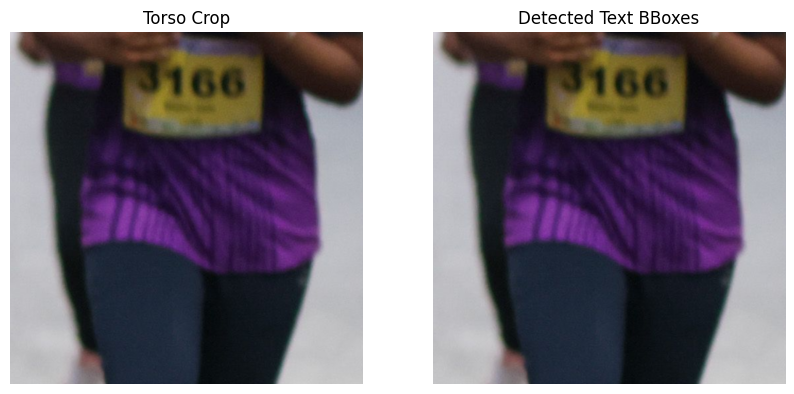

In [49]:
run_craft_on_uploaded_image("/content/test.jpg")


0: 448x640 4 persons, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


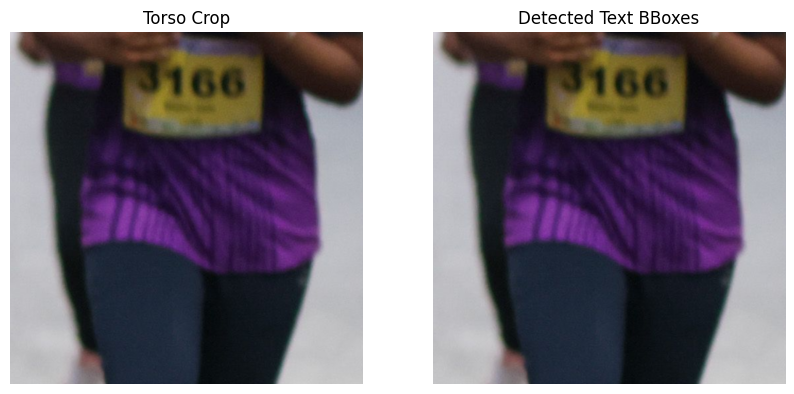


0: 448x640 2 persons, 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


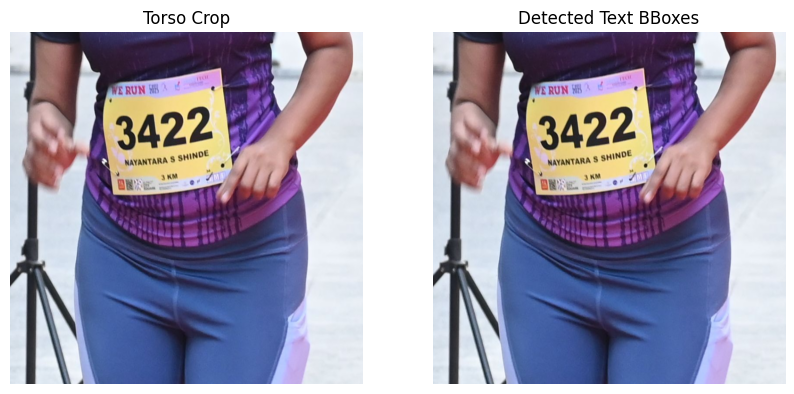


0: 448x640 4 persons, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


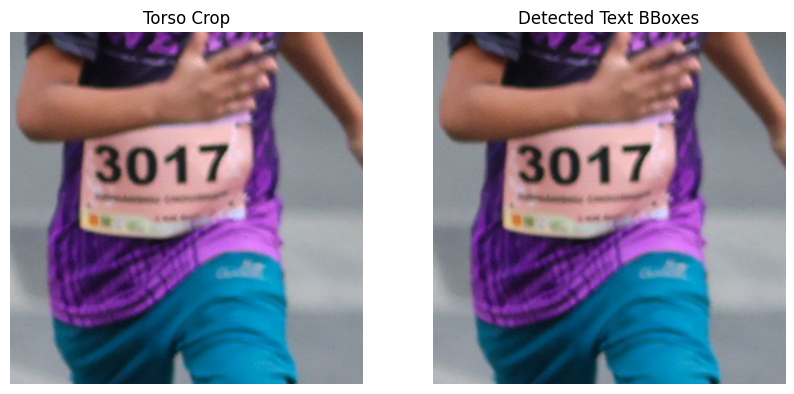

In [50]:
run_craft_on_uploaded_image("/content/test1.jpg")
run_craft_on_uploaded_image("/content/test2.jpg")
run_craft_on_uploaded_image("/content/test3.jpg")

In [52]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import easyocr

# === Load Models ===
human_model = YOLO("/content/human_detector_yolov8.pt")
easyocr_reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

# === Inference Pipeline: Human Detector -> Torso -> EasyOCR ===
def run_easyocr_on_torso(image_path, save_viz=True):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect humans
    results = human_model(image)[0]
    boxes = results.boxes.data.cpu().numpy()
    person_boxes = [b[:4].astype(int) for b in boxes if int(b[5]) == 0]

    for i, (x1, y1, x2, y2) in enumerate(person_boxes):
        torso_top = y1 + (y2 - y1) // 3
        torso_bot = y1 + 2 * (y2 - y1) // 3

        torso_crop = image[torso_top:torso_bot, x1:x2]
        if torso_crop.size == 0:
            continue

        results = easyocr_reader.readtext(torso_crop)

        if save_viz:
            vis = torso_crop.copy()
            for bbox, text, conf in results:
                pts = np.array(bbox).astype(int)
                cv2.polylines(vis, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
                cv2.putText(vis, text, pts[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
            plt.title("EasyOCR Detected BBoxes")
            plt.axis("off")
            plt.show()
            break




0: 448x640 4 persons, 40.2ms
Speed: 3.3ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


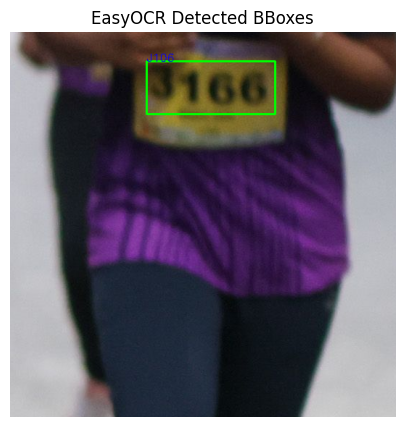


0: 448x640 4 persons, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


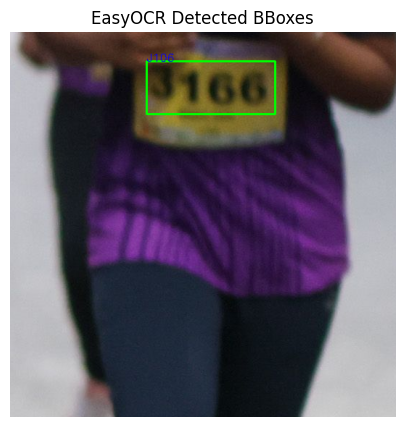


0: 448x640 2 persons, 39.4ms
Speed: 3.4ms preprocess, 39.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


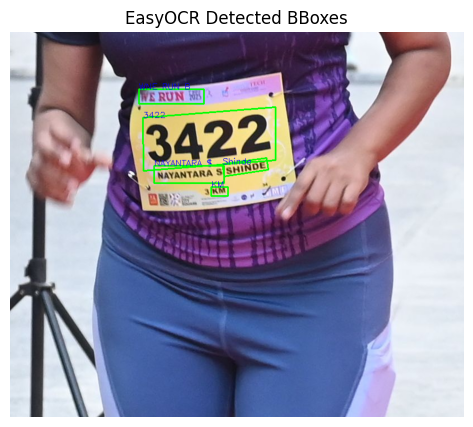


0: 448x640 4 persons, 37.1ms
Speed: 3.2ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


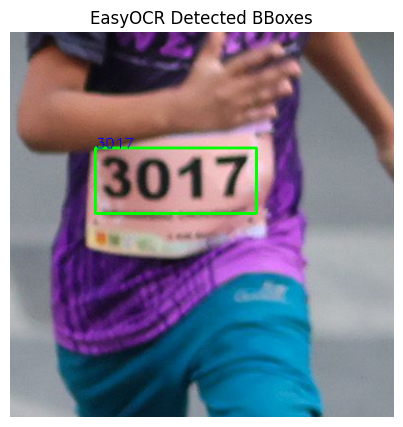

In [53]:

# Example Usage
run_easyocr_on_torso("/content/test.jpg")
run_easyocr_on_torso("/content/test1.jpg")
run_easyocr_on_torso("/content/test2.jpg")
run_easyocr_on_torso("/content/test3.jpg")

In [64]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import easyocr
from sklearn.metrics import jaccard_score
import json


# === Convert JSON to Mask ===
def json_to_mask(json_path, image_shape, img_size):
    with open(json_path, 'r') as f:
        data = json.load(f)

    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    for item in data:
        if 'bbox' in item:
            pts = np.array(item['bbox'], dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [pts], 255)

    mask = cv2.resize(mask, (img_size, img_size))
    return (mask > 127).astype(np.uint8)

# === Evaluation for CRAFT Model ===
def evaluate_craft_model(model, image_dir, label_dir, img_size=768, threshold=0.5):
    image_paths = sorted(Path(image_dir).glob("*.jpg"))
    total_iou = 0
    count = 0

    for img_path in tqdm(image_paths):
        json_path = Path(label_dir) / (img_path.stem + ".json")
        if not json_path.exists():
            continue

        image = cv2.imread(str(img_path))
        if image is None:
            continue

        image_resized = cv2.resize(image, (img_size, img_size))
        mask_gt = json_to_mask(json_path, image.shape, img_size)

        if np.sum(mask_gt) == 0:
            continue  # skip if GT mask is empty

        input_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
        with torch.no_grad():
            pred = model(input_tensor)[0, 0].numpy()

        pred_bin = (pred > threshold).astype(np.uint8)

        if np.sum(pred_bin) == 0:
            continue  # skip if prediction is empty

        iou = jaccard_score(mask_gt.flatten(), pred_bin.flatten(), zero_division=0)
        total_iou += iou
        count += 1

    avg_iou = total_iou / count if count > 0 else 0
    print(f"\n Evaluated {count} images — Mean IoU: {avg_iou:.4f}")

# === Evaluation Only ===
craft_model = UNet()
craft_model.load_state_dict(torch.load("craft_synthetic_trained.pth", map_location="cpu"))
craft_model.eval()

evaluate_craft_model(
    model=craft_model,
    image_dir="/content/CRAFT_SVT/image",
    label_dir="/content/CRAFT_SVT/label"
)


100%|██████████| 100/100 [00:01<00:00, 97.40it/s]


 Evaluated 0 images — Mean IoU: 0.0000
